In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from scipy.linalg import eigh
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from maad import sound
from sklearn.metrics.pairwise import euclidean_distances, polynomial_kernel, cosine_similarity, laplacian_kernel, linear_kernel
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
import seaborn as sns
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [13]:
start = 0
# duration = 300

audio_data, sampling_rate = librosa.load('../../Data/ElephantIsland2014/wav/20140104_120000_AWI251-01_AU0231_250Hz.wav', sr=250, offset=start)

duration = librosa.get_duration(y=audio_data, sr=sampling_rate)
duration

300.0

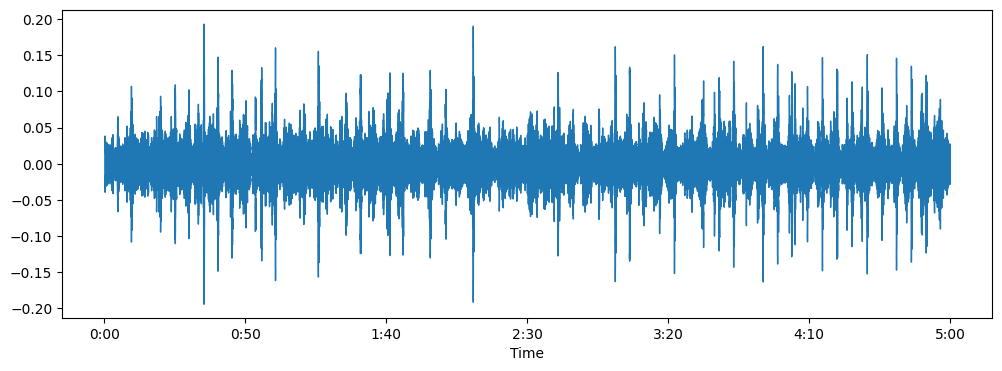

In [14]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data, sr=sampling_rate)
plt.show()
# librosa.display.specshow(audio_data)
# plt.show

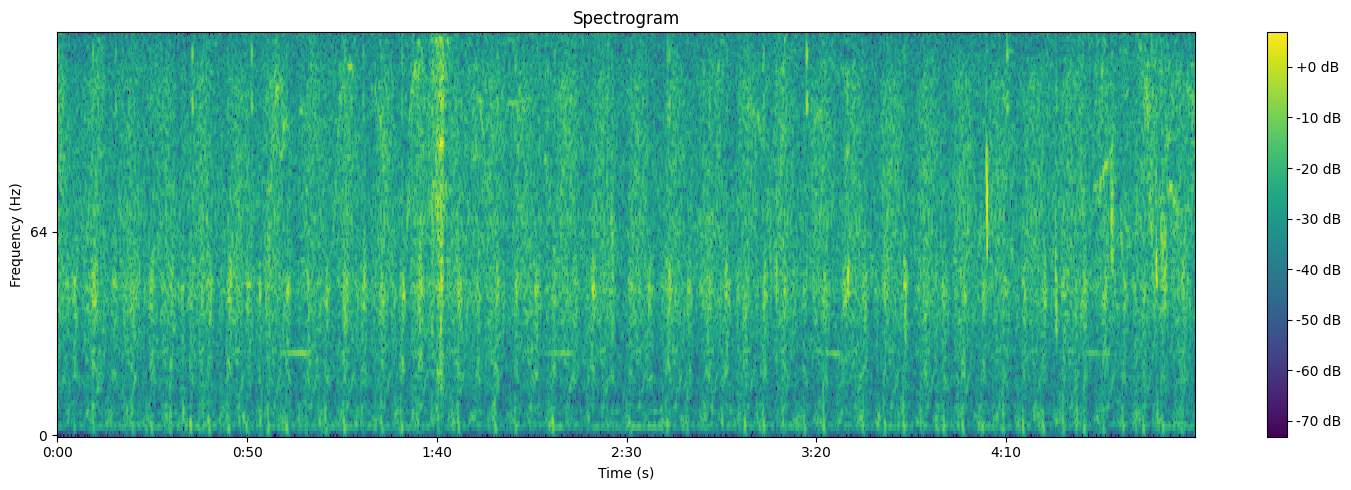

In [15]:
audio_data = librosa.effects.preemphasis(audio_data)

# window_length = 314
# hop_length = 85
# fft_size = 314
n_mels=80
window_length = 256
hop_length = 64
fft_size = 256

D = librosa.stft(audio_data, n_fft=fft_size, hop_length=hop_length, win_length=window_length, window='hann')
spectrogram = librosa.amplitude_to_db(np.abs(D))
power_spectrum=np.abs(D)**2

# Plot the spectrogram
plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()



C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\librosa\display.py:1255: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  if __same_axes(x_axis, y_axis, axes.get_xlim(), axes.get_ylim()) and auto_aspect:


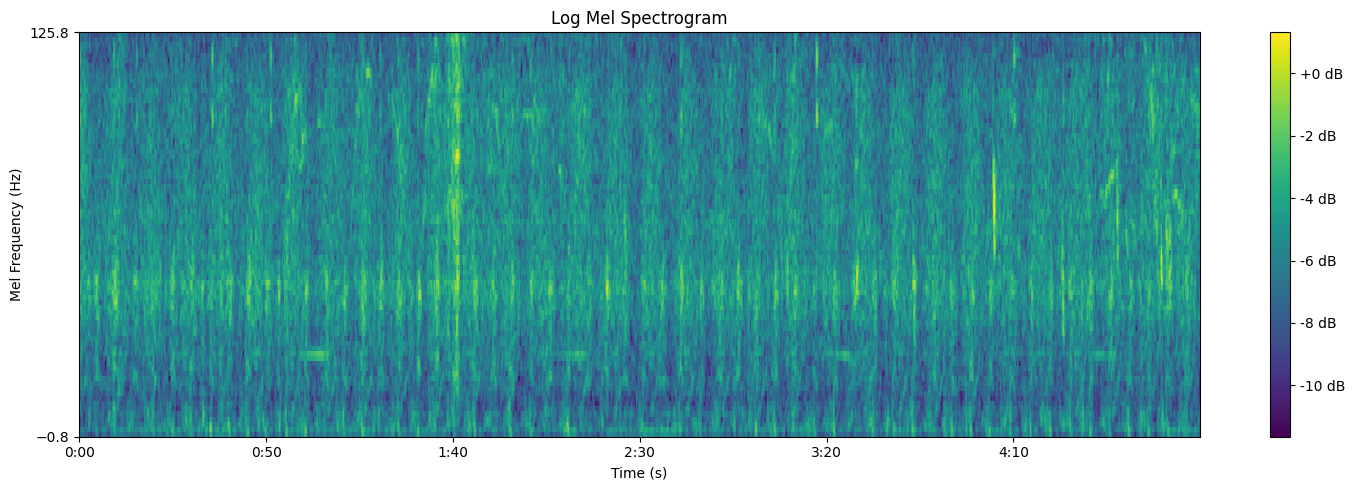

In [16]:
mel_filter_bank = librosa.filters.mel(sr=sampling_rate, n_fft=fft_size, n_mels=n_mels)
mel_spectrum = np.dot(mel_filter_bank, power_spectrum)

# Step 7: Take the logarithm of the Mel spectrum
log_mel_spectrum = np.log(mel_spectrum + 1e-9)  # Add a small value to avoid log(0)
plt.figure(figsize=(15, 5))
librosa.display.specshow(log_mel_spectrum, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency (Hz)')
plt.tight_layout()
plt.show()

In [6]:
def extract_features(audio_data, sampling_rate, num_mfcc=10, n_fft=256, hop_length=64):

    # Bandpass filter applied
    filtered_audio = sound.select_bandwidth(audio_data, sampling_rate, fcut=(20,80), forder=5, ftype='bandpass')

    # Spectrogram
    Sxx_filtered, tn_filtered, fn_filtered, ext_filtered = sound.spectrogram(filtered_audio, sampling_rate)
    
    # Noise reduction
    clean_audio, noise_profile, BGNxx = sound.remove_background(Sxx_filtered,sampling_rate, N=1024)

    #  Extracting MFCCs, Deltas, Chroma and Spectral Contrasts
    mfccs = librosa.feature.mfcc(S=clean_audio, n_fft=fft_size, n_mfcc=num_mfcc)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    chroma = librosa.feature.chroma_stft(S=clean_audio, sr=sampling_rate, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(S=clean_audio,sr=sampling_rate, fmin=20, n_bands=3)

    # Standardizing the features
    scaler = StandardScaler()
    mfccs_scaled = scaler.fit_transform(mfccs.T).T
    delta_scaled = scaler.fit_transform(mfccs_delta.T).T
    chroma_scaled = scaler.fit_transform(chroma.T).T
    spectral_scaled = scaler.fit_transform(spectral_contrast.T).T

    # Plot the spectrogram using matplotlib
    plt.figure(figsize=(15, 5))
    plt.imshow(Sxx_filtered, aspect='auto', extent=ext_filtered, origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Filtered Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    return mfccs_scaled, delta_scaled, chroma_scaled, spectral_scaled




In [7]:
# pca = PCA(n_components=12)  
# mfccs_pca = pca.fit_transform(mfccs_combined_scaled.T)

# plt.figure(figsize=(15, 5))
# librosa.display.specshow(mfccs_pca.T, sr=sampling_rate, hop_length=hop_length, x_axis='time', cmap='coolwarm')
# plt.colorbar(label='PCA MFCC Coefficients')
# plt.title('Standardized and PCA-Transformed MFCC Spectrogram')
# plt.xlabel('Time (s)')
# plt.ylabel('MFCC Coefficients')
# plt.tight_layout()
# plt.show()

# explained_variance = pca.explained_variance_ratio_
# cumulative_variance = explained_variance.cumsum()

# print("Explained variance by each component:", explained_variance)
# print("Cumulative variance explained by the components:", cumulative_variance)

# plt.figure(figsize=(8, 4))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
# plt.title('Cumulative Variance Explained by PCA Components')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Variance Explained')
# plt.grid(True)
# plt.show()

In [8]:
from matplotlib.ticker import FuncFormatter
def time_ticks(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f'{minutes}:{seconds:02d}'

def clustering(X, affinity_matrix, n_clusters=2, clustering_method="kmeans"):
   
    #Degree matrix
    degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))
    epsilon = 1e-5  # Adjust this value as needed
    degree_matrix += np.eye(degree_matrix.shape[0]) * epsilon

    min_threshold = 1e-5  # Set a minimum threshold to avoid small values causing issues
    degree_matrix = np.clip(degree_matrix, min_threshold, None)

    sqrt_deg_matrix = np.diag(1.0 / np.sqrt(np.diag(degree_matrix)))
    norm_laplacian_matrix = np.eye(degree_matrix.shape[0]) - sqrt_deg_matrix @ affinity_matrix @ sqrt_deg_matrix

    #Eigenvalue decomp
    eig_values, eig_vectors = eigh(norm_laplacian_matrix)
    idx = eig_values.argsort()
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    k = 3
    feature_vector = eig_vectors[:, :k]


    
    # Clustering
    if clustering_method == 'kmeans':
        cluster = KMeans(n_clusters=n_clusters, n_init=20)
    elif clustering_method == 'dbscan':
        cluster = DBSCAN(eps=0.5, min_samples=5)
    elif clustering_method == 'gmm':
        cluster = GaussianMixture(n_components=n_clusters)

    labels = cluster.fit_predict(feature_vector)

    # Check the number of unique labels
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print("Warning: Only one cluster found. Silhouette score cannot be calculated.")
        return labels, None
    
    
    silhouette = silhouette_score(X, labels)
    
    # print(silhouette)

    return labels, silhouette
     # Determine optimal number of eigenvectors (k) to use
    




C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


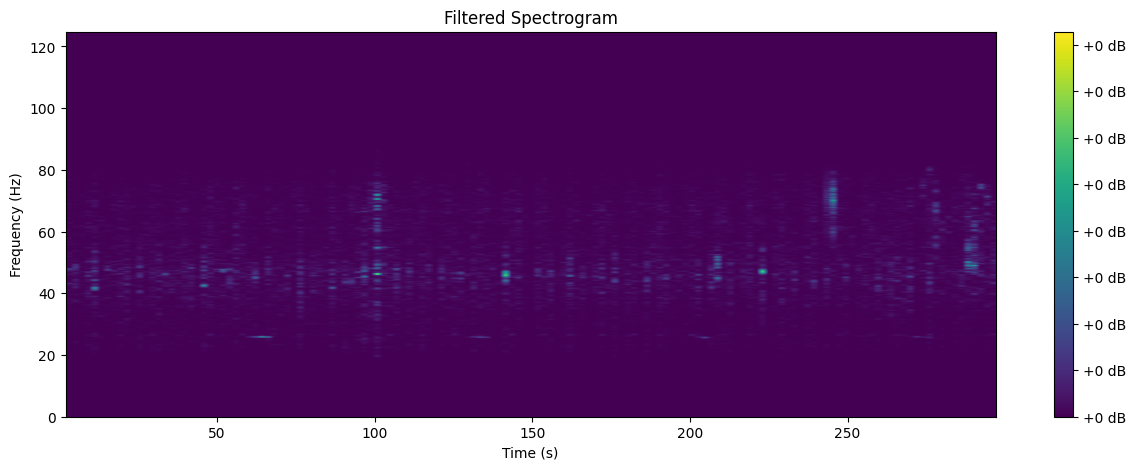

Feature Set: mfccs, Affinity: rbf, Method: kmeans, Silhouette: 0.8541892486184659


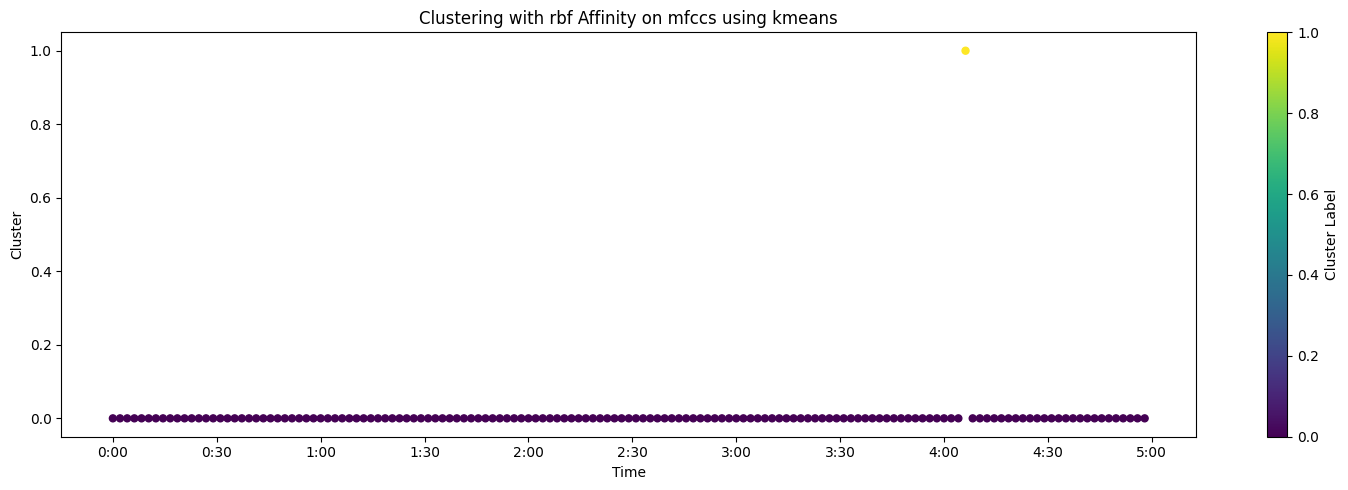

Feature Set: mfccs, Affinity: rbf, Method: dbscan, Silhouette: 0.8353658705119897


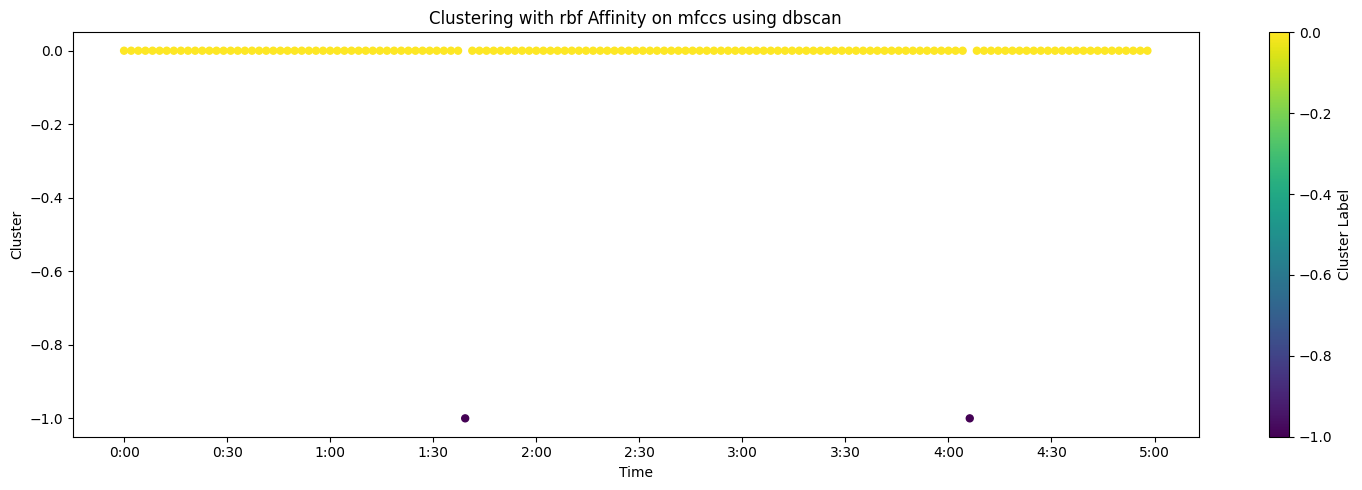

Feature Set: mfccs, Affinity: rbf, Method: gmm, Silhouette: 0.7892874390190351


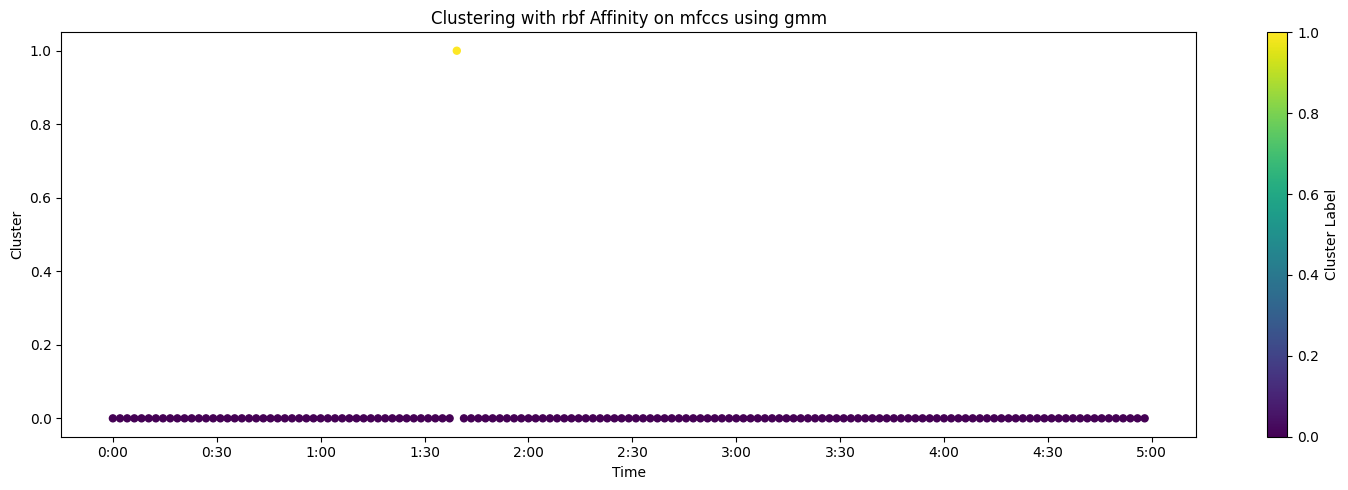

Feature Set: mfccs, Affinity: cosine, Method: kmeans, Silhouette: 0.4244169750023667


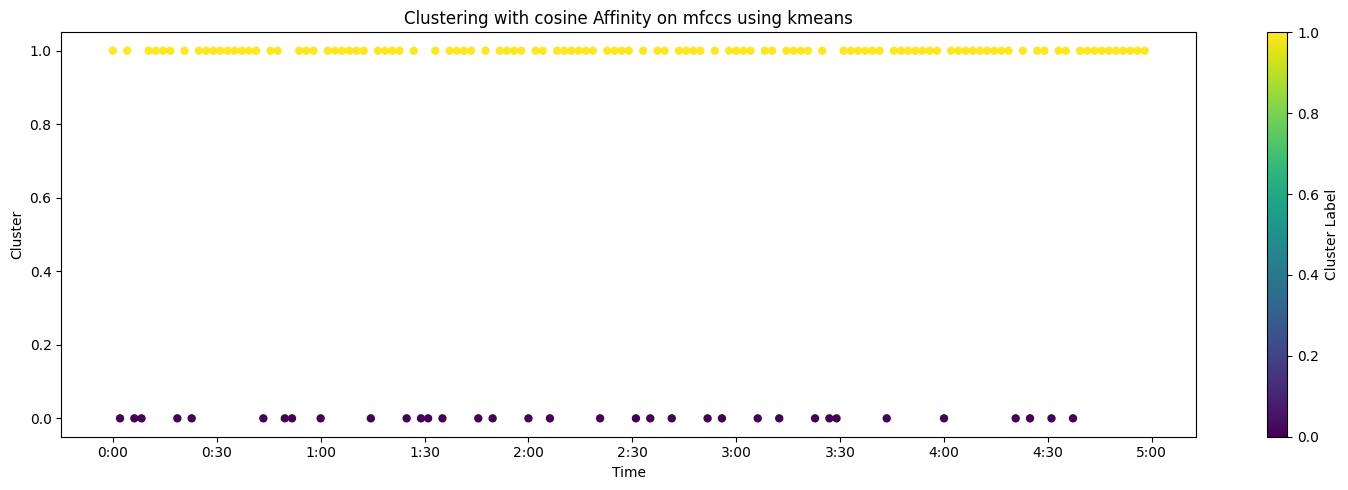

Feature Set: mfccs, Affinity: cosine, Method: dbscan, Silhouette: None


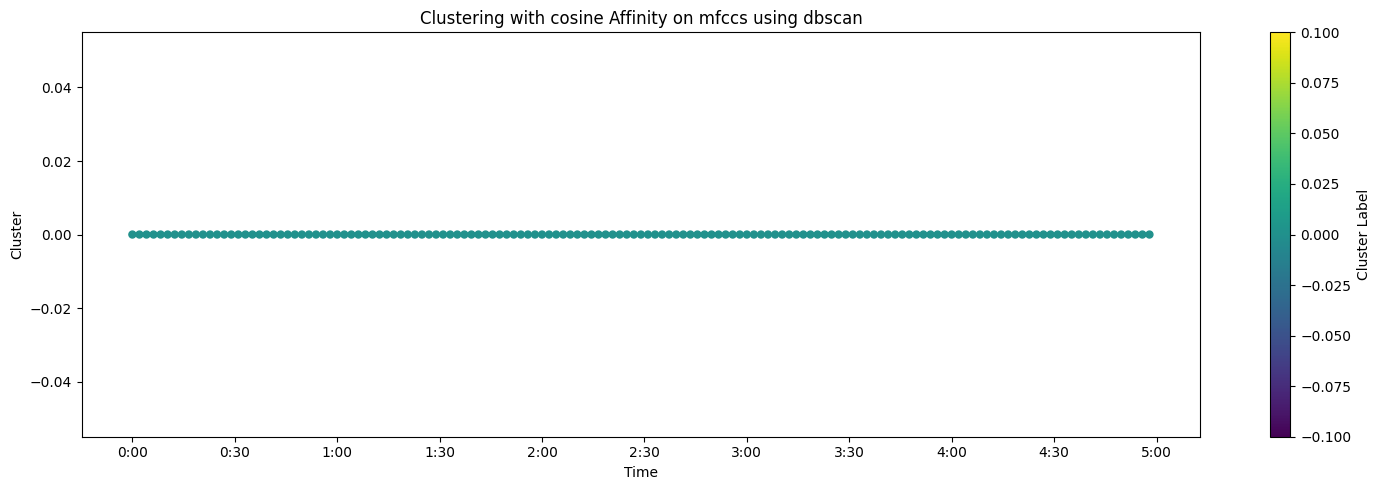

Feature Set: mfccs, Affinity: cosine, Method: gmm, Silhouette: 0.45607884661200926


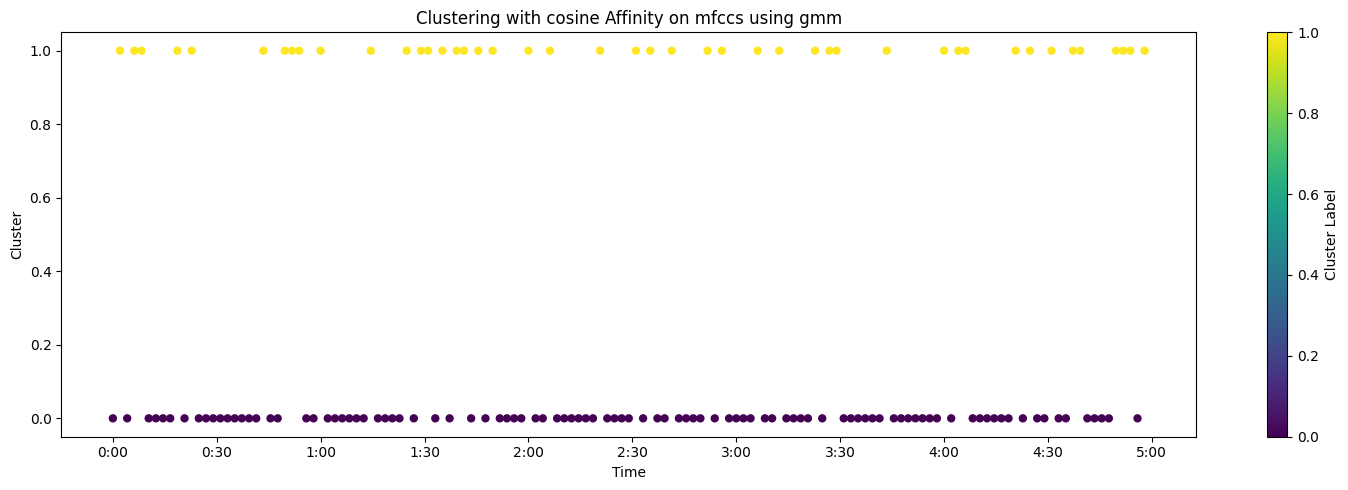

Feature Set: mfccs, Affinity: polynomial, Method: kmeans, Silhouette: 0.8541892486184659


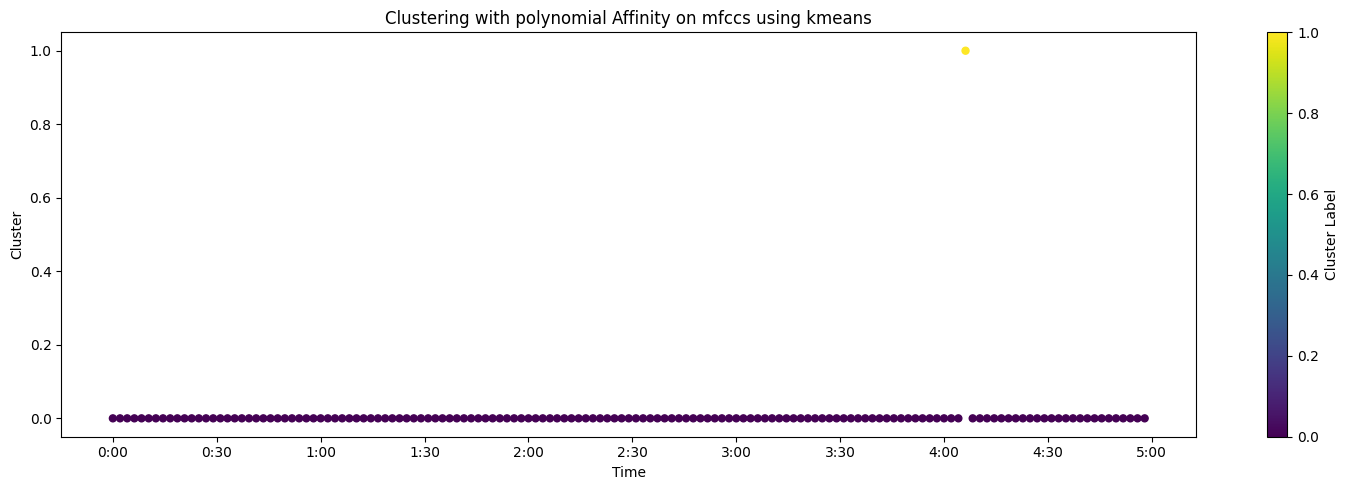

Feature Set: mfccs, Affinity: polynomial, Method: dbscan, Silhouette: 0.8541892486184659


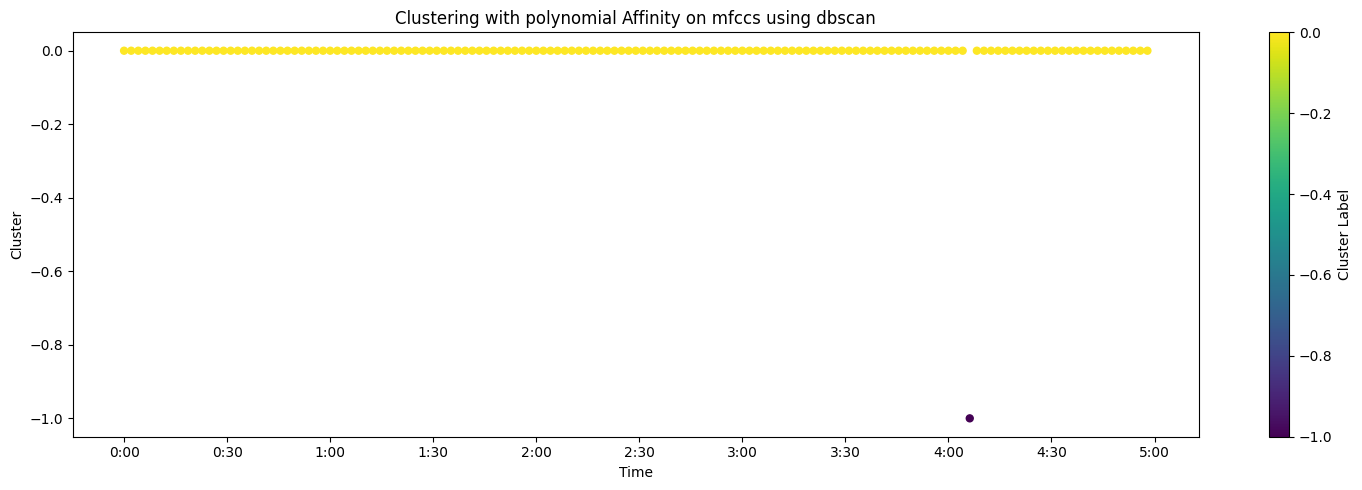

Feature Set: mfccs, Affinity: polynomial, Method: gmm, Silhouette: 0.8541892486184659


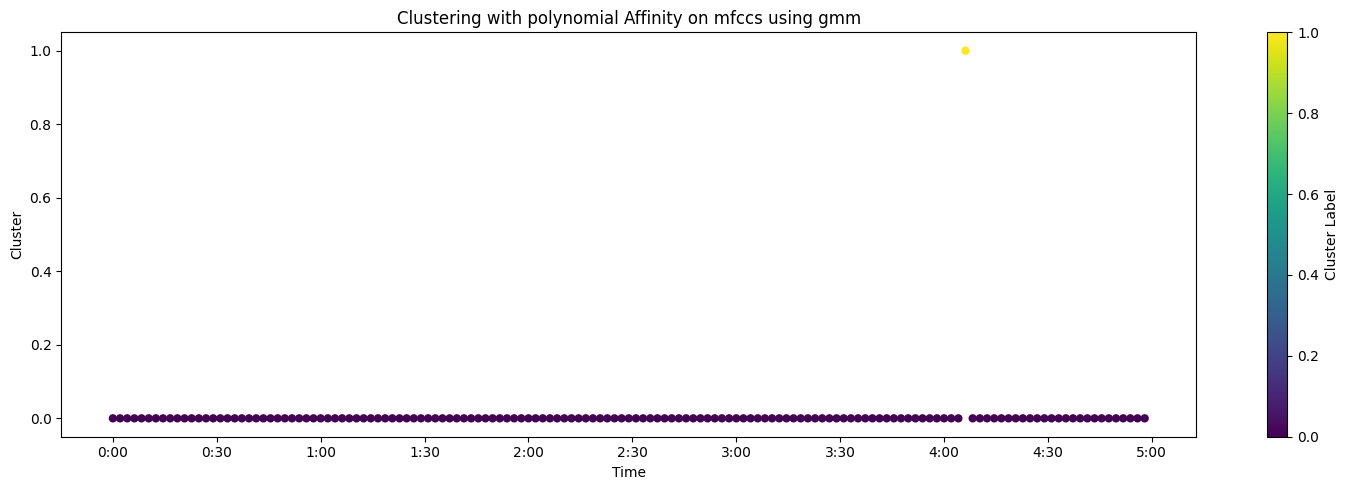

Feature Set: mfccs, Affinity: linear, Method: kmeans, Silhouette: 0.8353658705119897


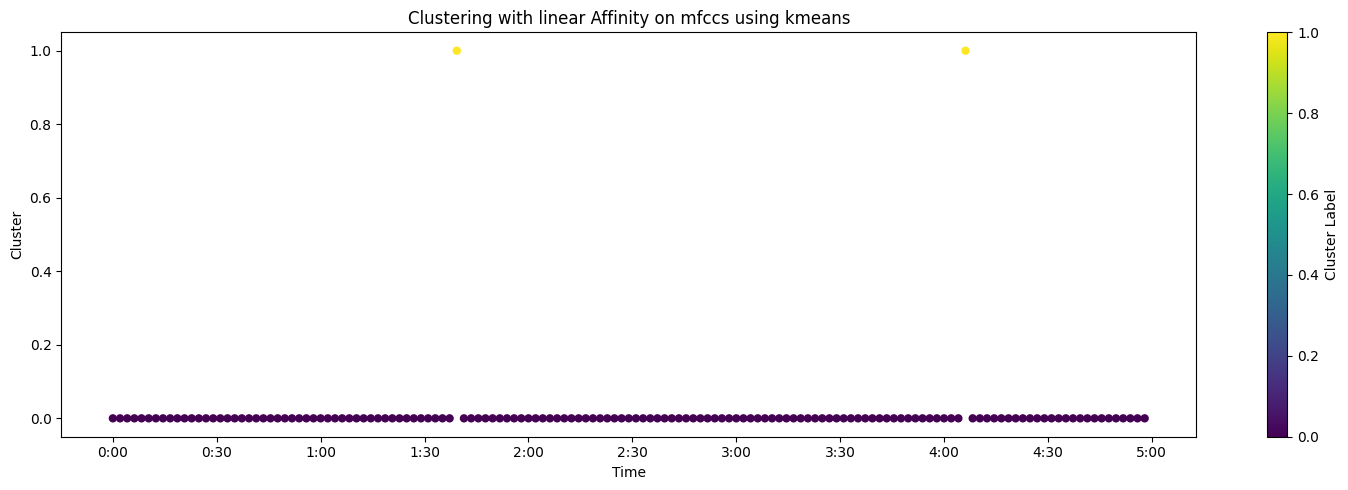

Feature Set: mfccs, Affinity: linear, Method: dbscan, Silhouette: 0.8541892486184659


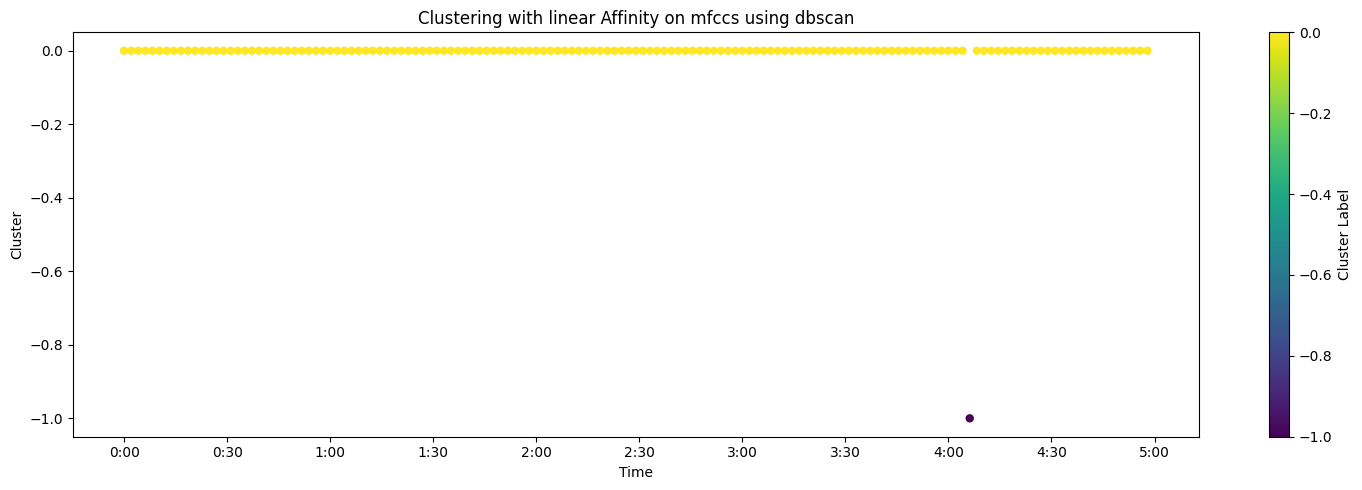

Feature Set: mfccs, Affinity: linear, Method: gmm, Silhouette: 0.6271121955500123


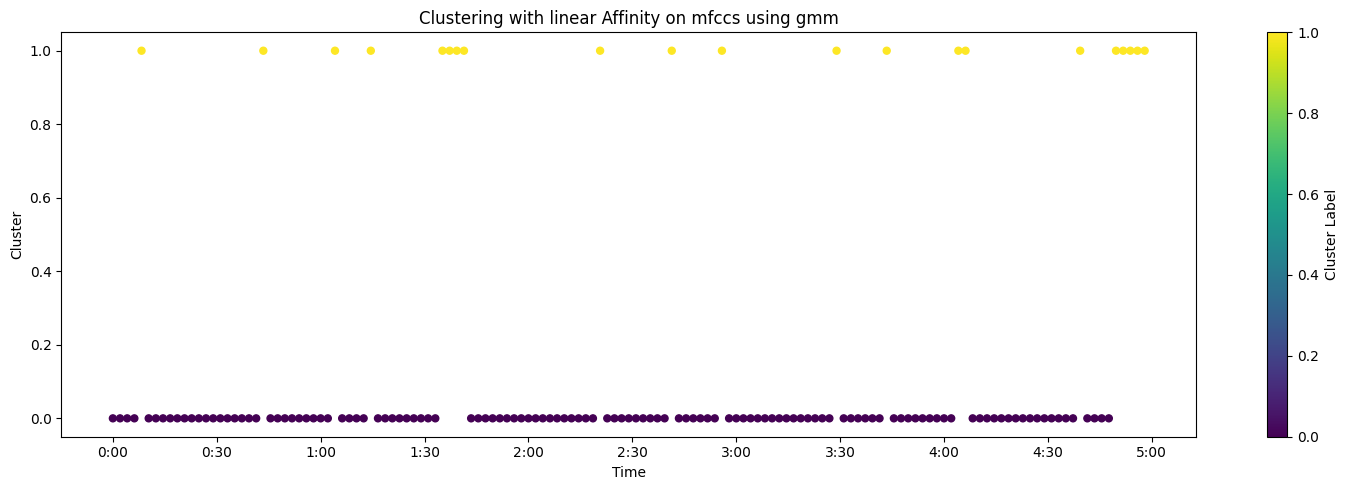

Feature Set: mfccs, Affinity: dot_product, Method: kmeans, Silhouette: 0.7784011698283854


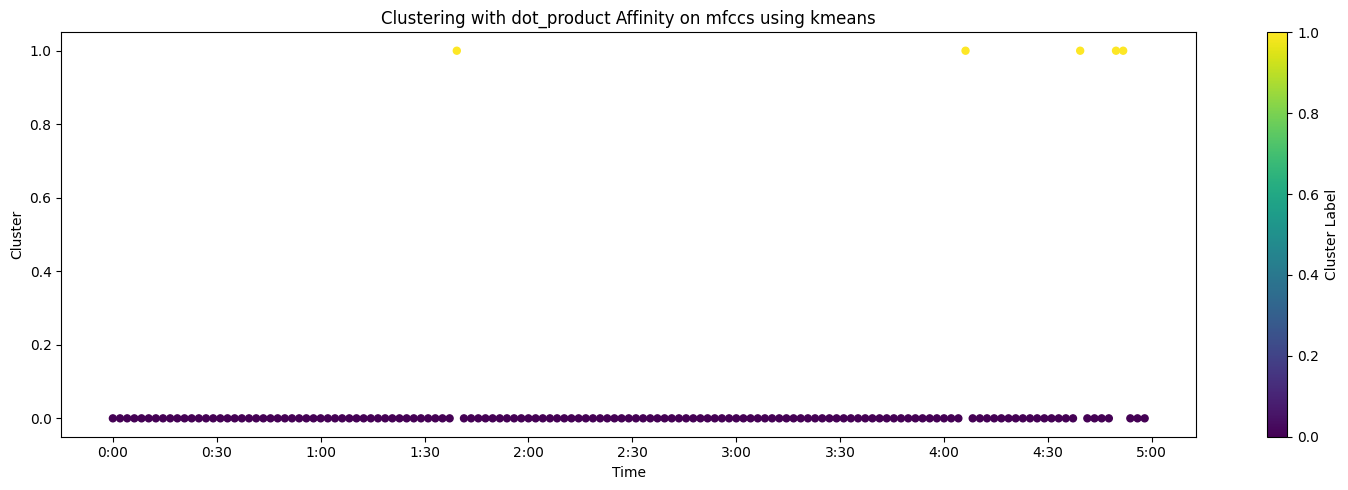

Feature Set: mfccs, Affinity: dot_product, Method: dbscan, Silhouette: 0.8541892486184659


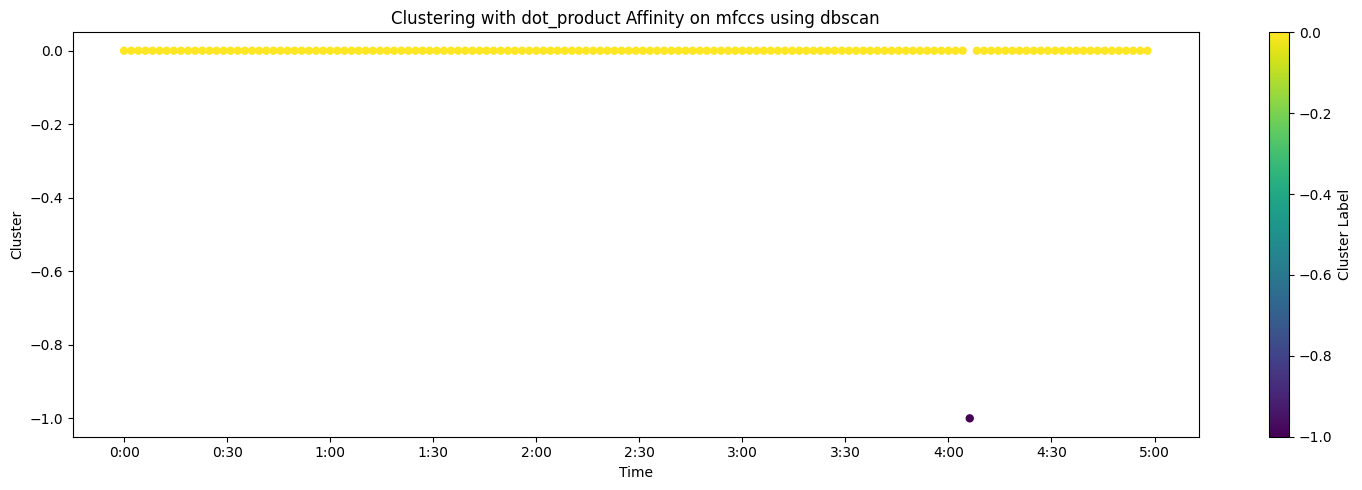

Feature Set: mfccs, Affinity: dot_product, Method: gmm, Silhouette: 0.6407645135854094


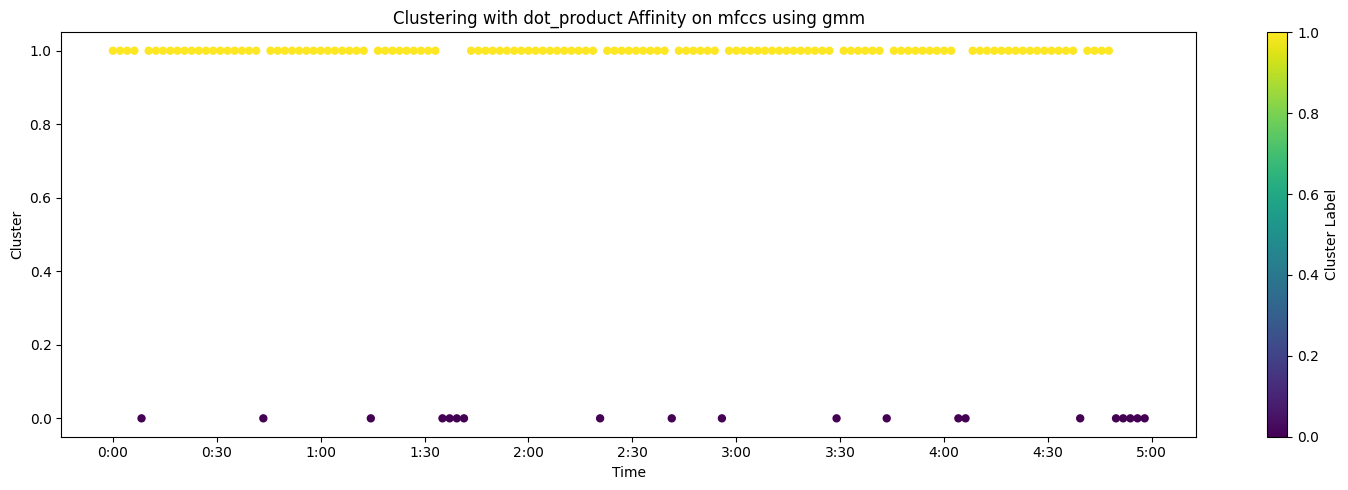

Feature Set: delta, Affinity: rbf, Method: kmeans, Silhouette: 0.6823251093874292


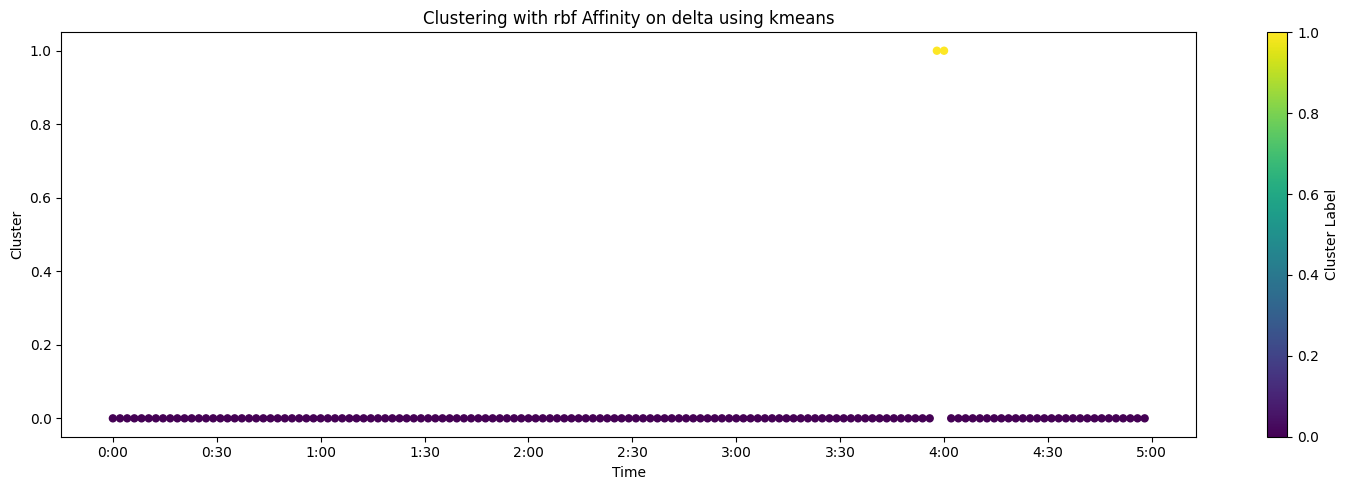

Feature Set: delta, Affinity: rbf, Method: dbscan, Silhouette: 0.6823251093874292


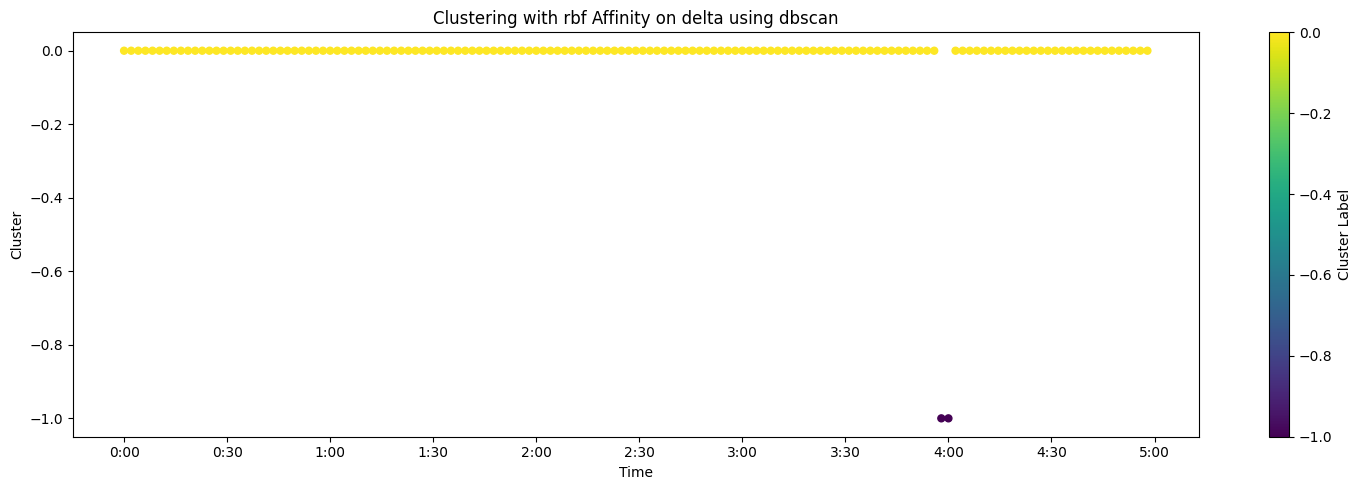

Feature Set: delta, Affinity: rbf, Method: gmm, Silhouette: 0.6742943066301939


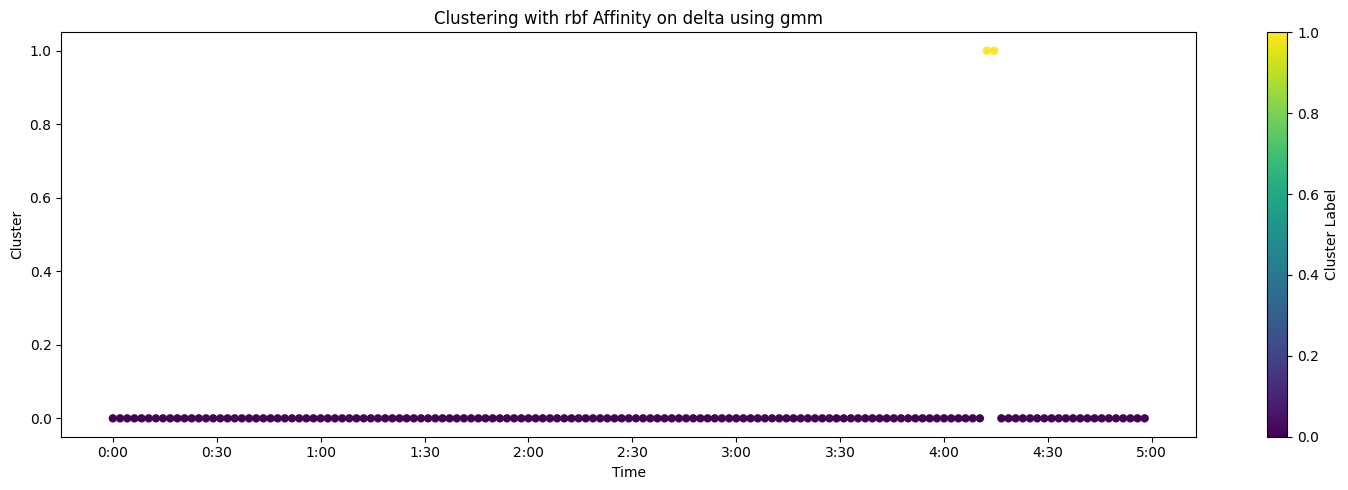

Feature Set: delta, Affinity: cosine, Method: kmeans, Silhouette: 0.2712003081186394


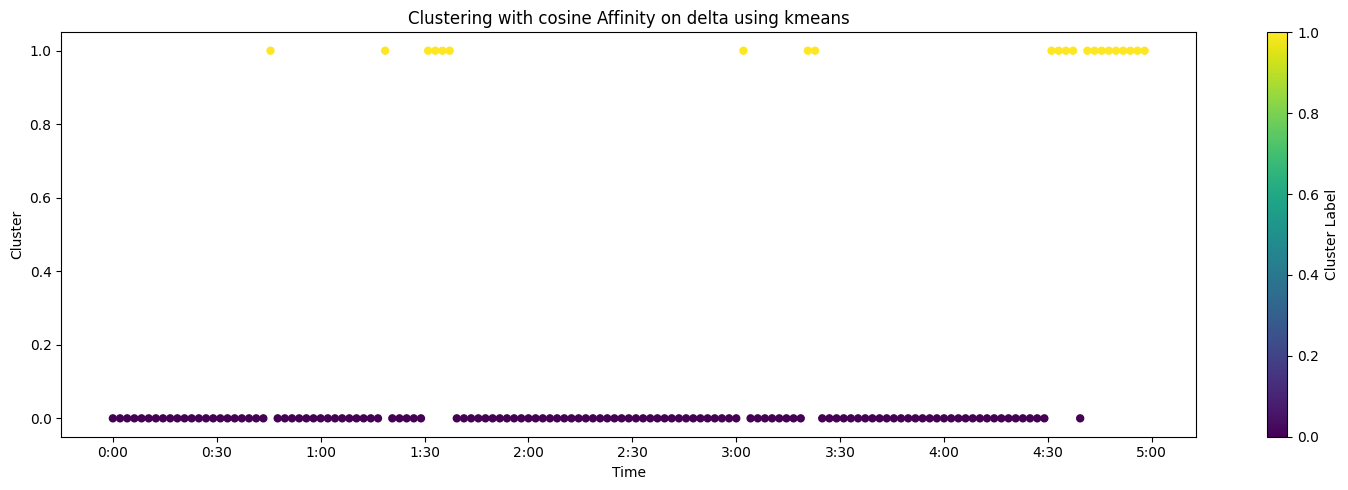

Feature Set: delta, Affinity: cosine, Method: dbscan, Silhouette: None


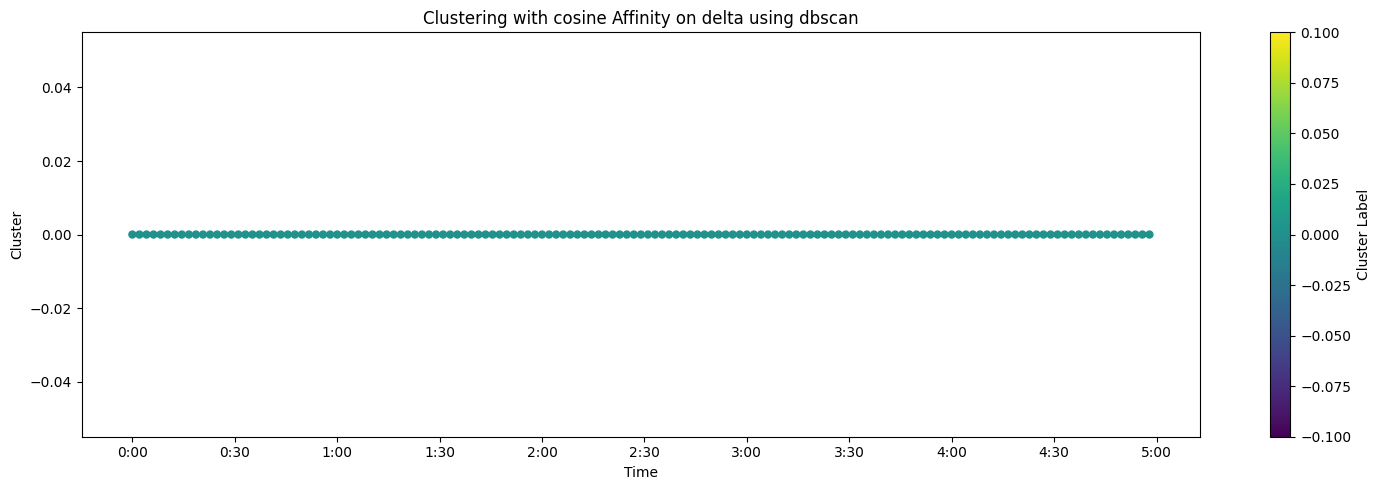

Feature Set: delta, Affinity: cosine, Method: gmm, Silhouette: 0.2540158550196219


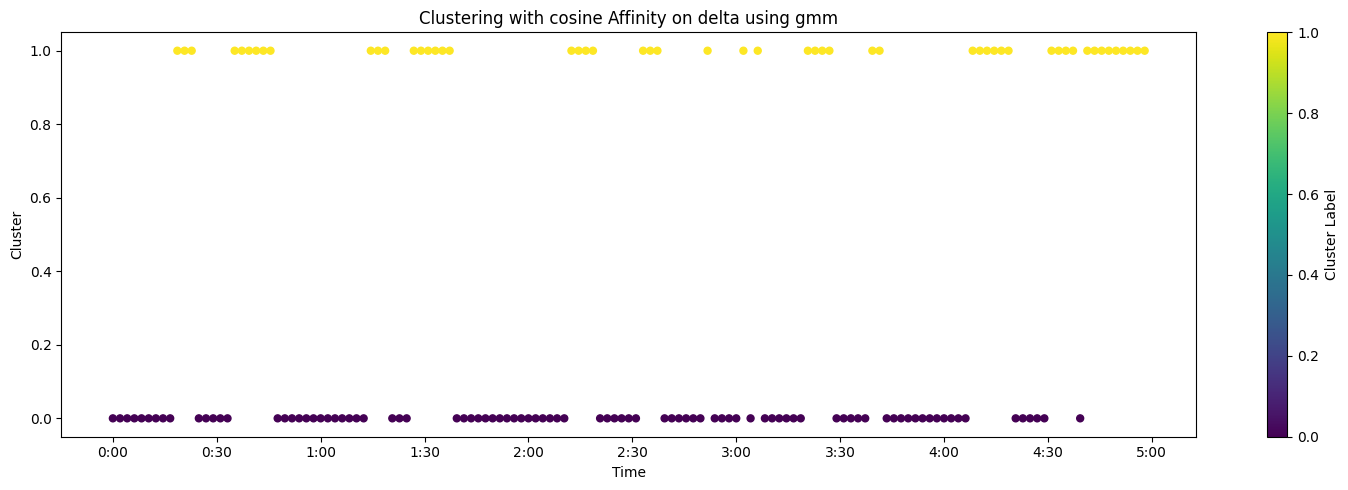

Feature Set: delta, Affinity: polynomial, Method: kmeans, Silhouette: 0.5123271979433293


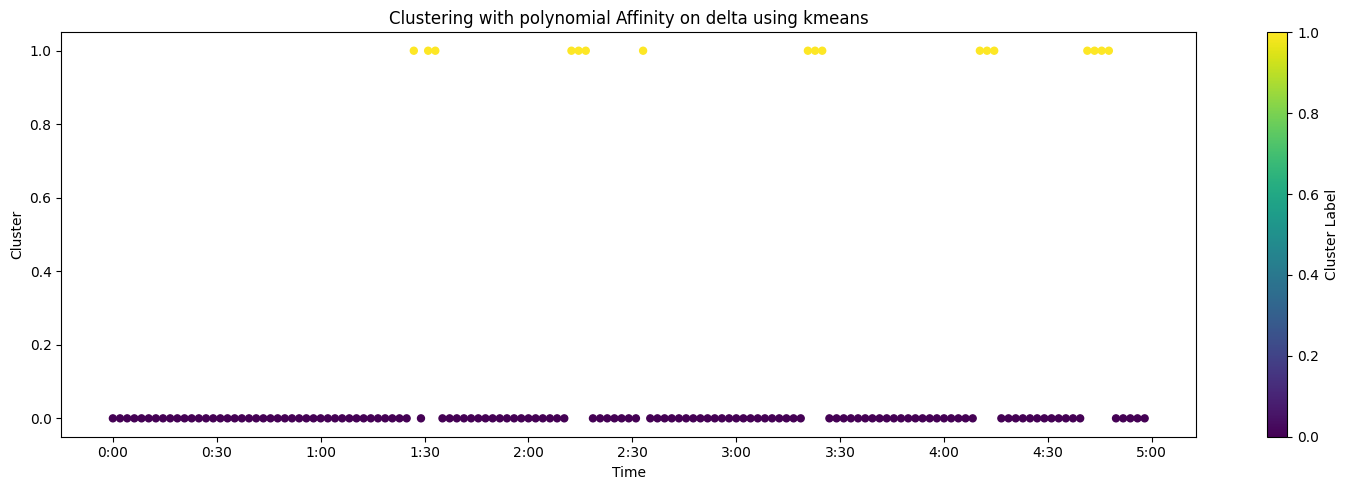

Feature Set: delta, Affinity: polynomial, Method: dbscan, Silhouette: None


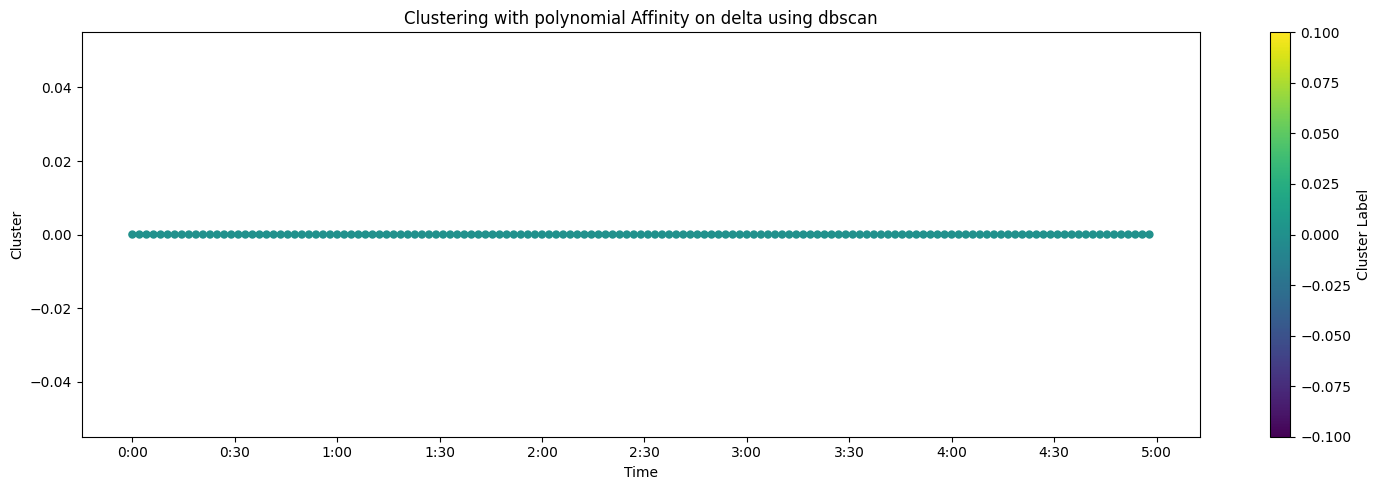

Feature Set: delta, Affinity: polynomial, Method: gmm, Silhouette: 0.6823251093874292


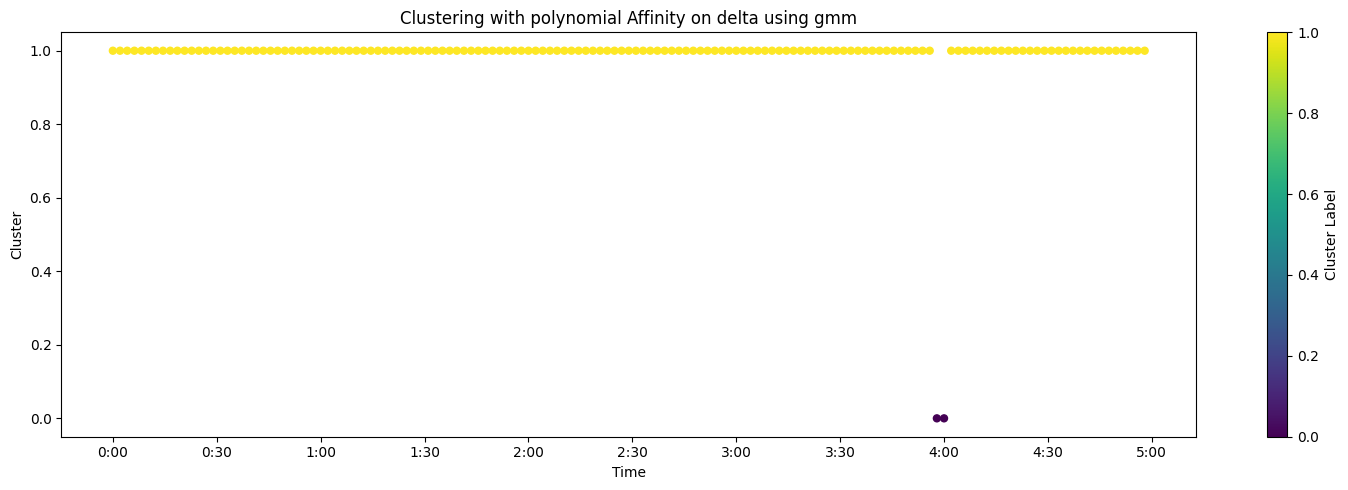

Feature Set: delta, Affinity: linear, Method: kmeans, Silhouette: 0.2359898102233215


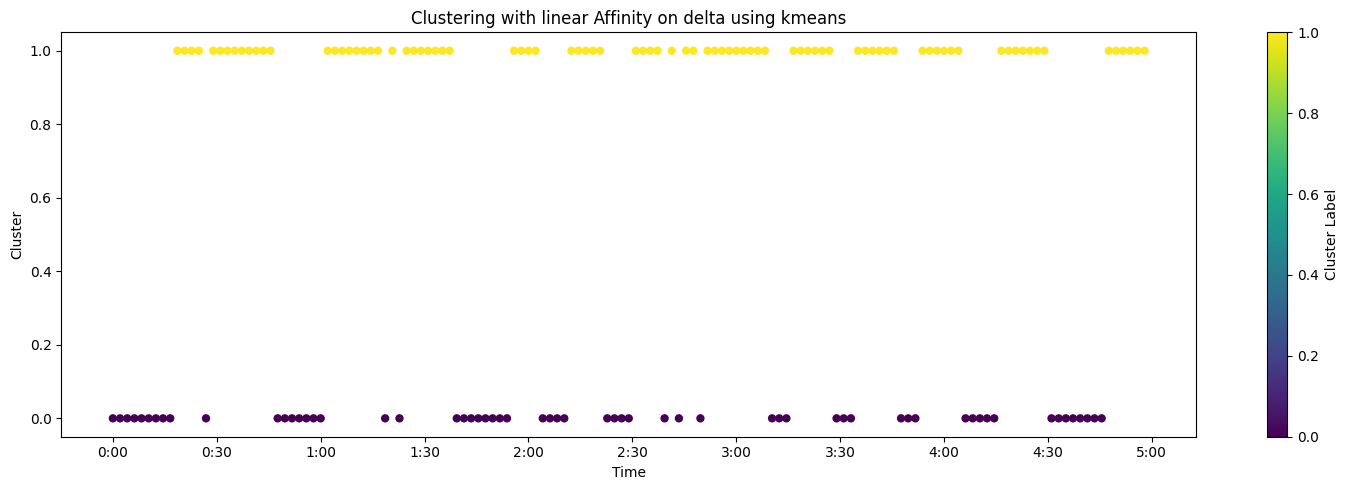

Feature Set: delta, Affinity: linear, Method: dbscan, Silhouette: None


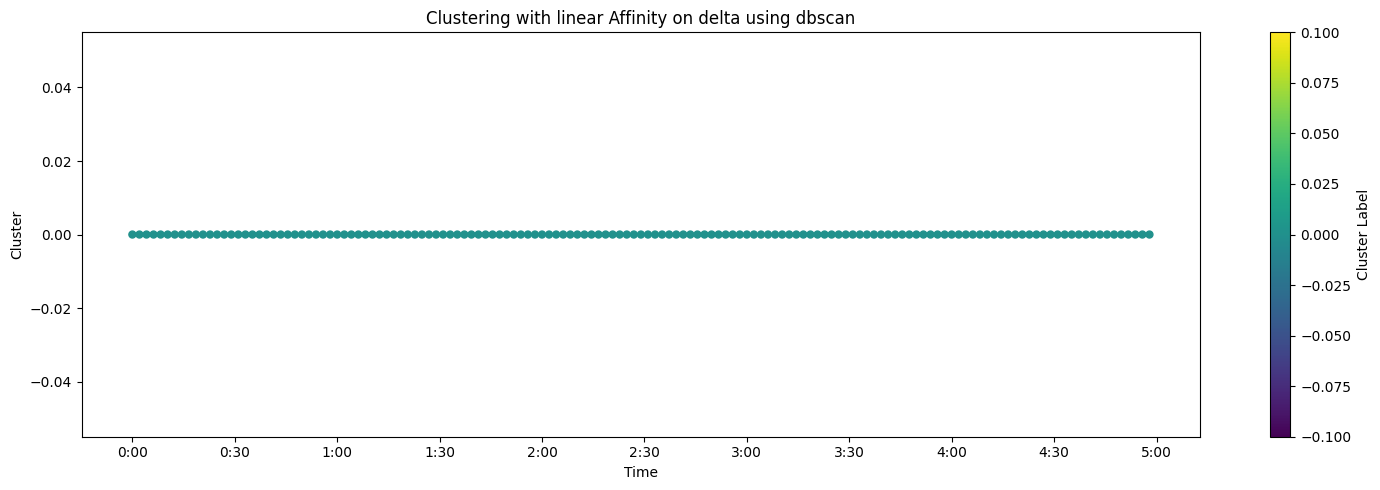

Feature Set: delta, Affinity: linear, Method: gmm, Silhouette: 0.3535155975714758


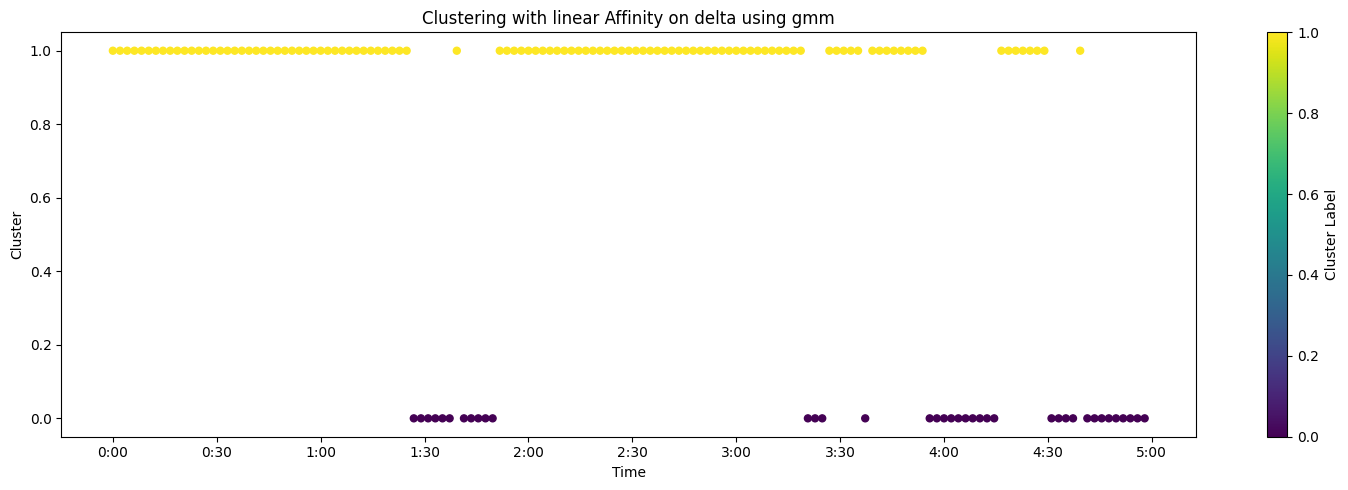

Feature Set: delta, Affinity: dot_product, Method: kmeans, Silhouette: 0.2359898102233215


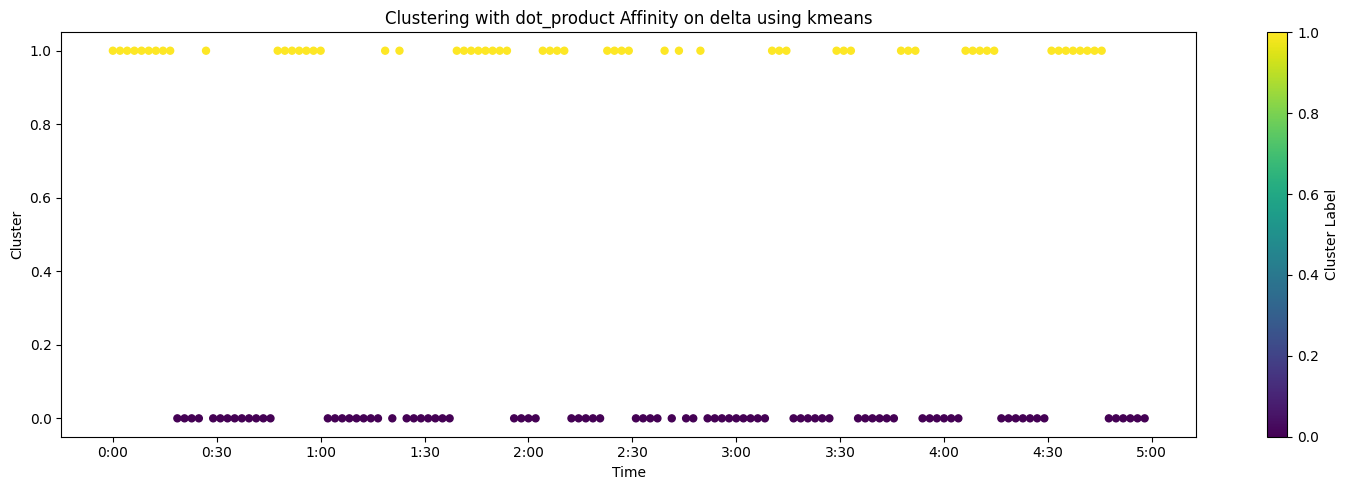

Feature Set: delta, Affinity: dot_product, Method: dbscan, Silhouette: None


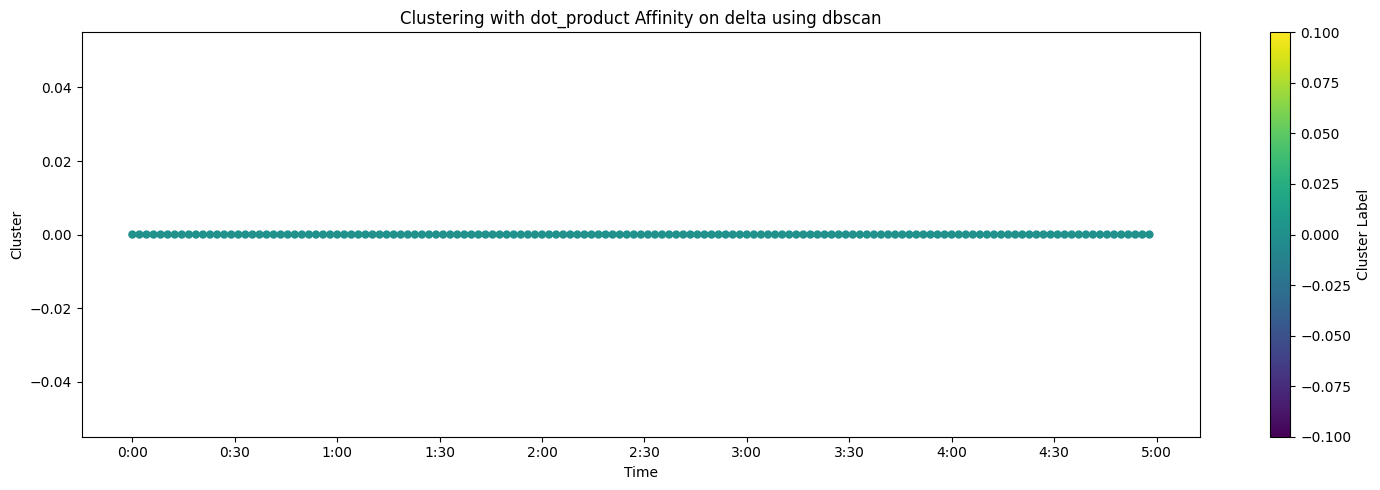

Feature Set: delta, Affinity: dot_product, Method: gmm, Silhouette: 0.3535155975714758


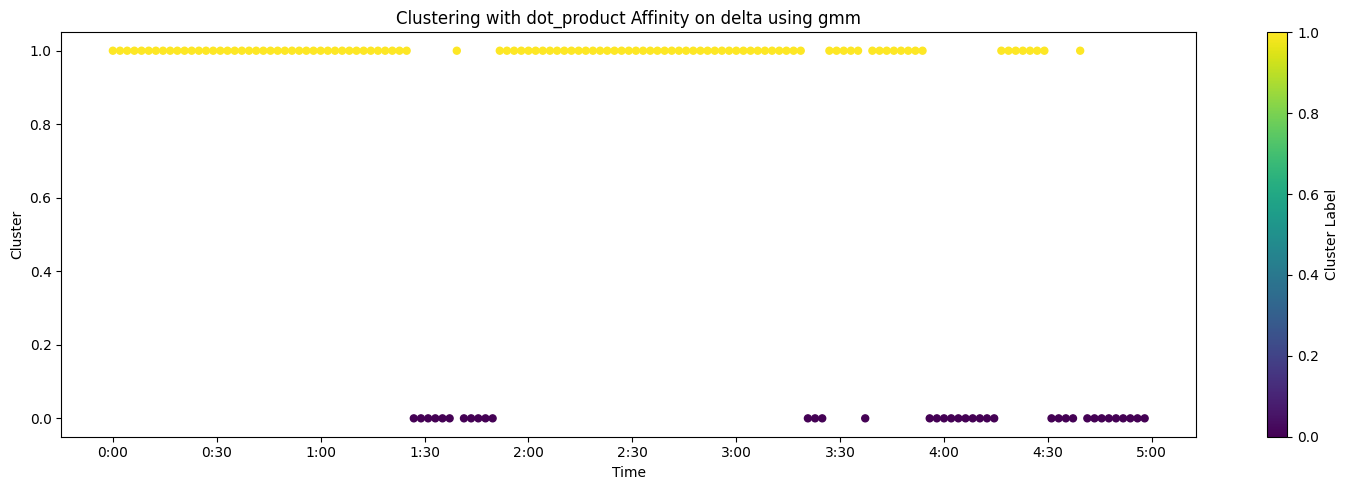

Feature Set: chroma, Affinity: rbf, Method: kmeans, Silhouette: 0.23636435805000716


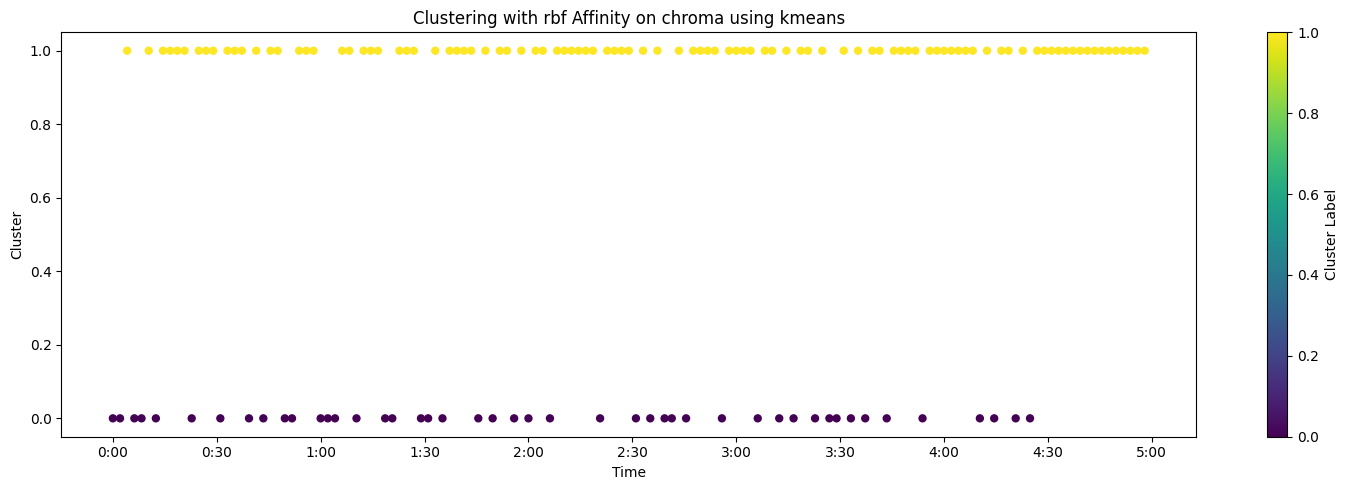

Feature Set: chroma, Affinity: rbf, Method: dbscan, Silhouette: None


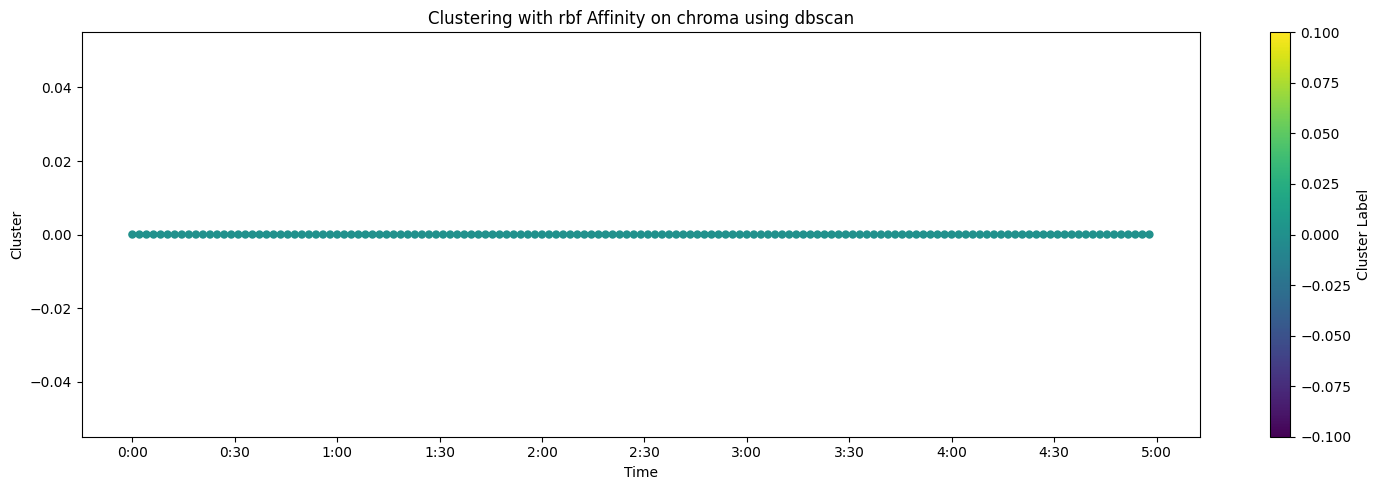

Feature Set: chroma, Affinity: rbf, Method: gmm, Silhouette: 0.21360965900857687


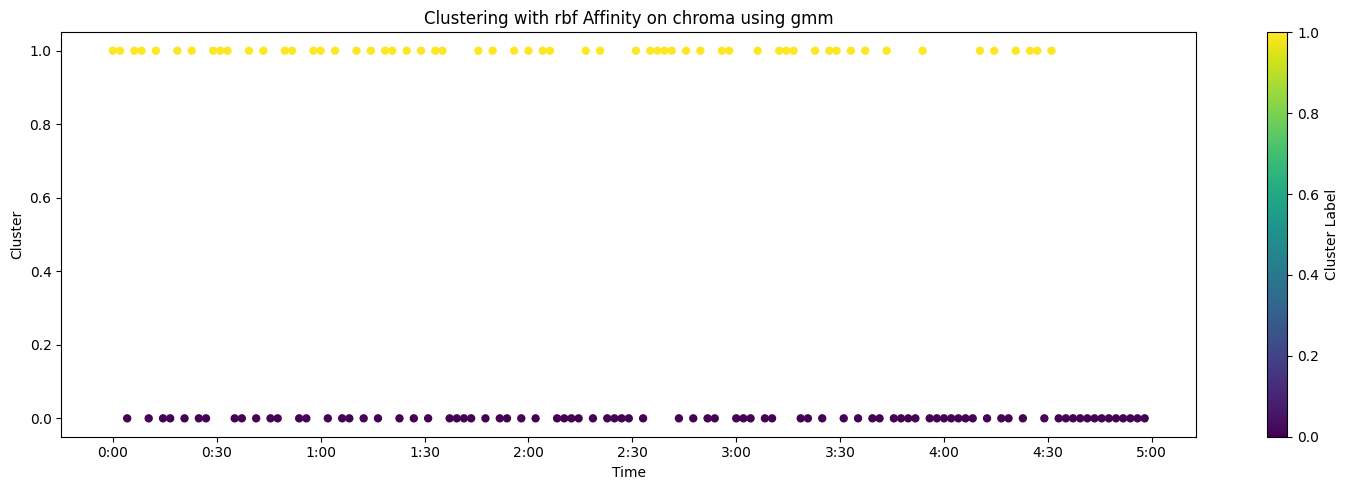

Feature Set: chroma, Affinity: cosine, Method: kmeans, Silhouette: 0.22418274374057304


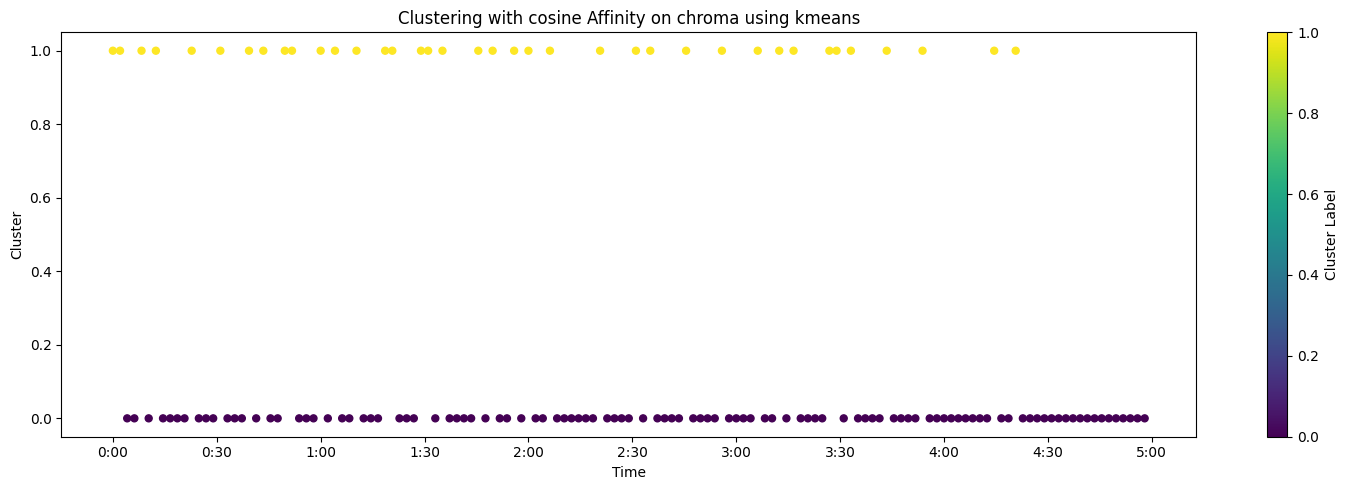

Feature Set: chroma, Affinity: cosine, Method: dbscan, Silhouette: None


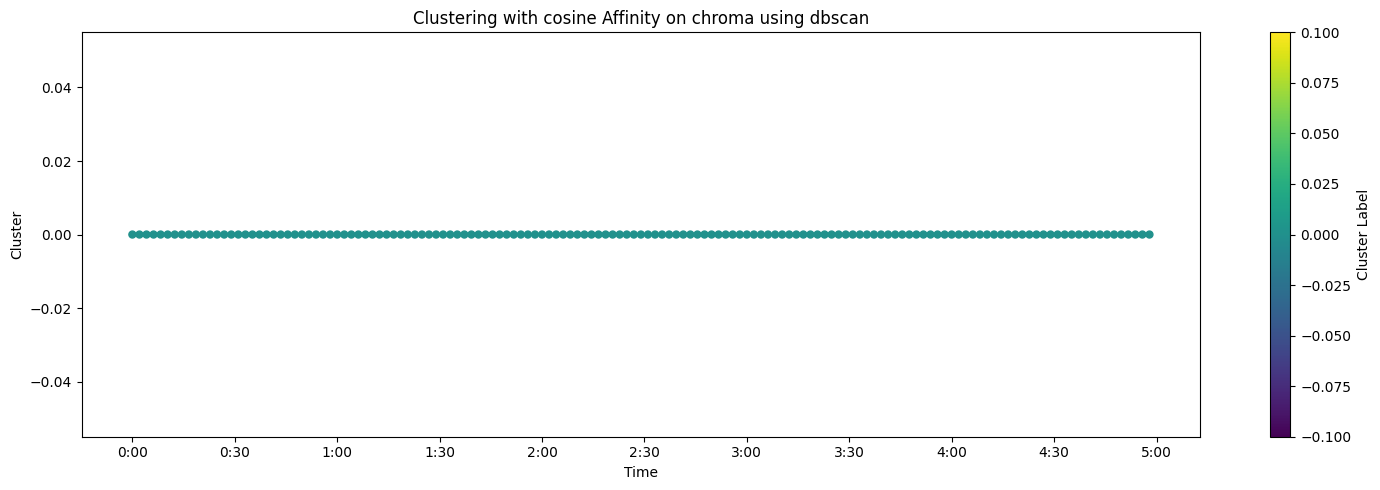

Feature Set: chroma, Affinity: cosine, Method: gmm, Silhouette: 0.21499919074928553


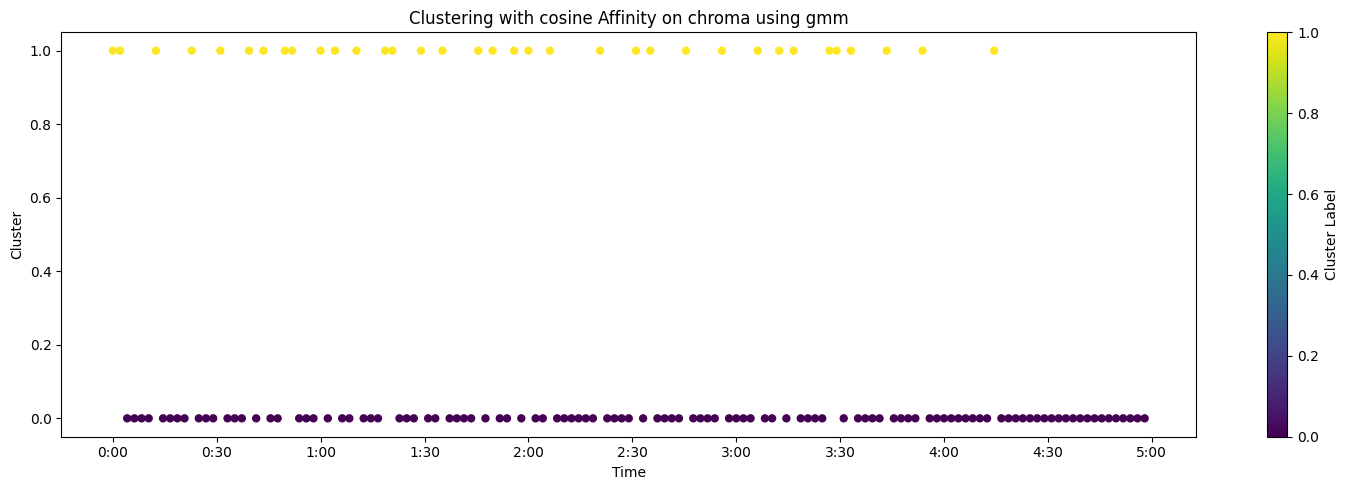

Feature Set: chroma, Affinity: polynomial, Method: kmeans, Silhouette: 0.23684089317837406


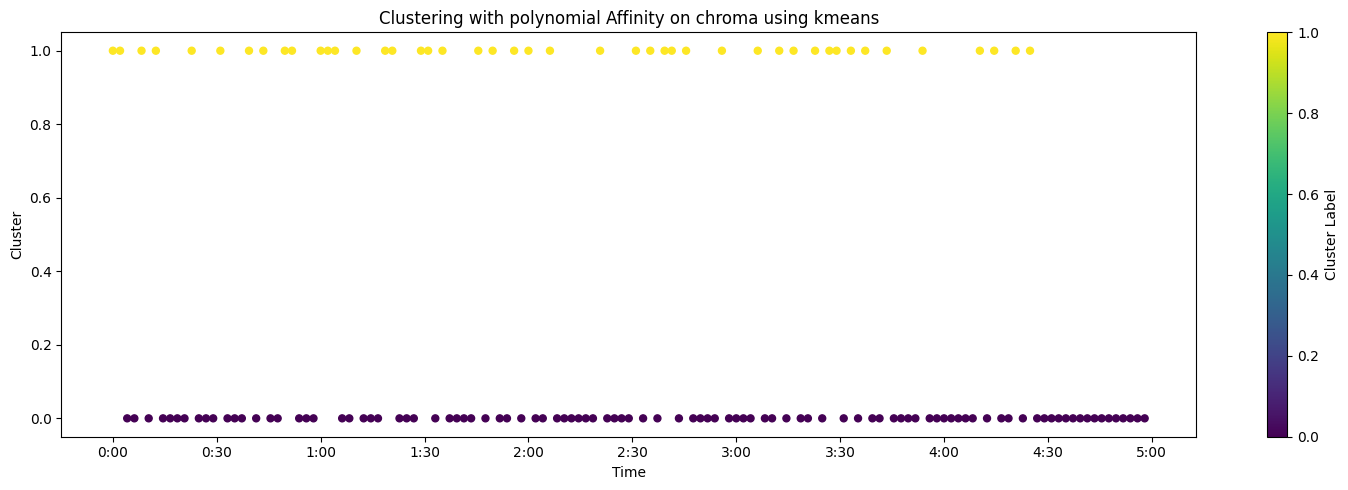

Feature Set: chroma, Affinity: polynomial, Method: dbscan, Silhouette: None


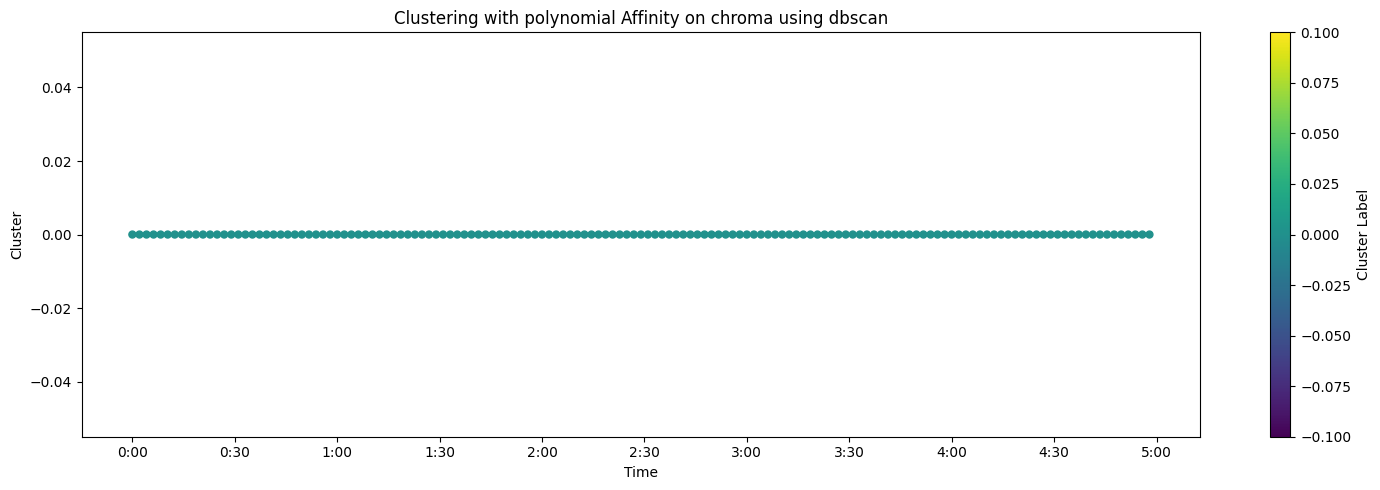

Feature Set: chroma, Affinity: polynomial, Method: gmm, Silhouette: 0.23526145888684202


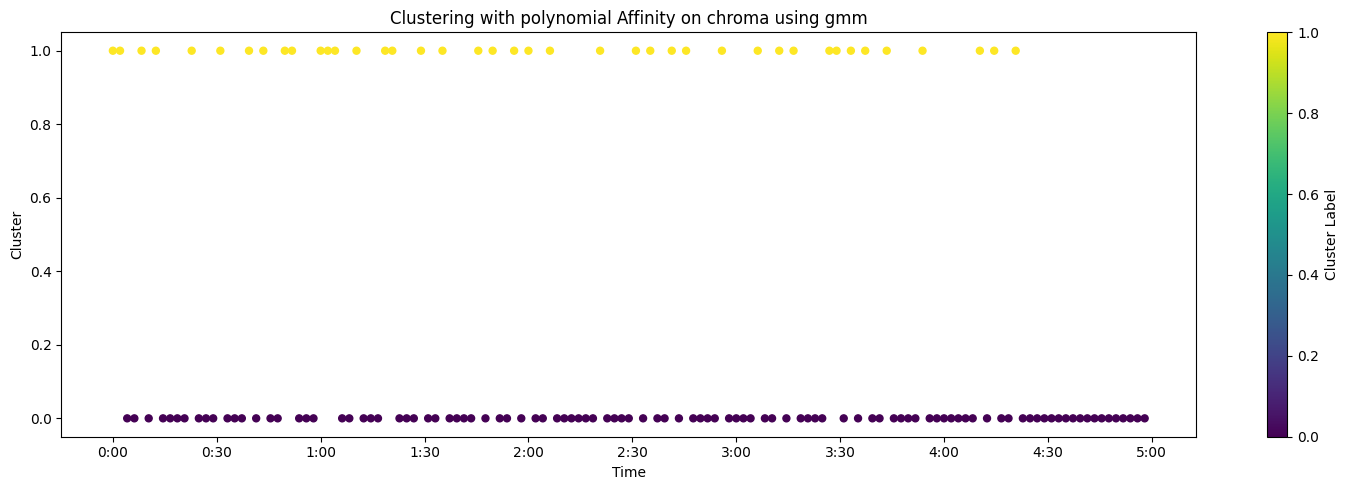

Feature Set: chroma, Affinity: linear, Method: kmeans, Silhouette: 0.22575680311118362


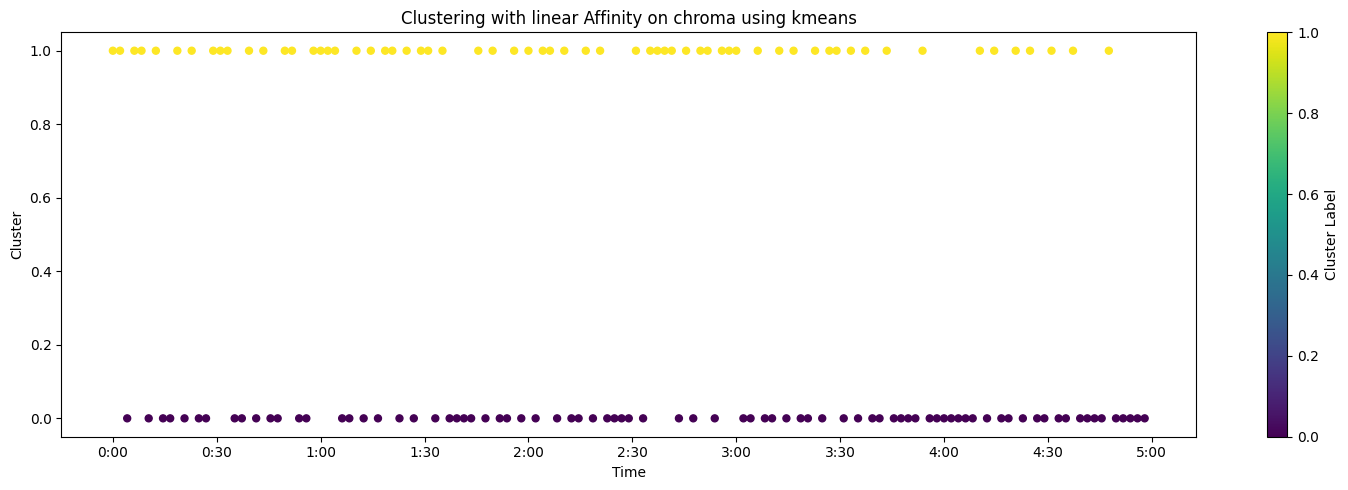

Feature Set: chroma, Affinity: linear, Method: dbscan, Silhouette: None


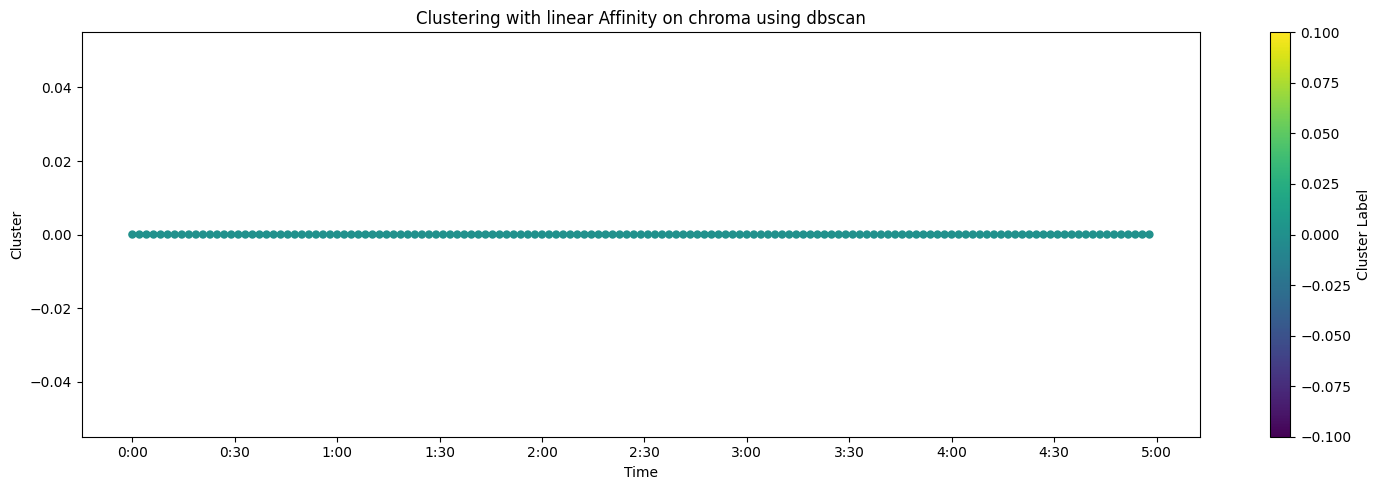

Feature Set: chroma, Affinity: linear, Method: gmm, Silhouette: 0.2031914960099951


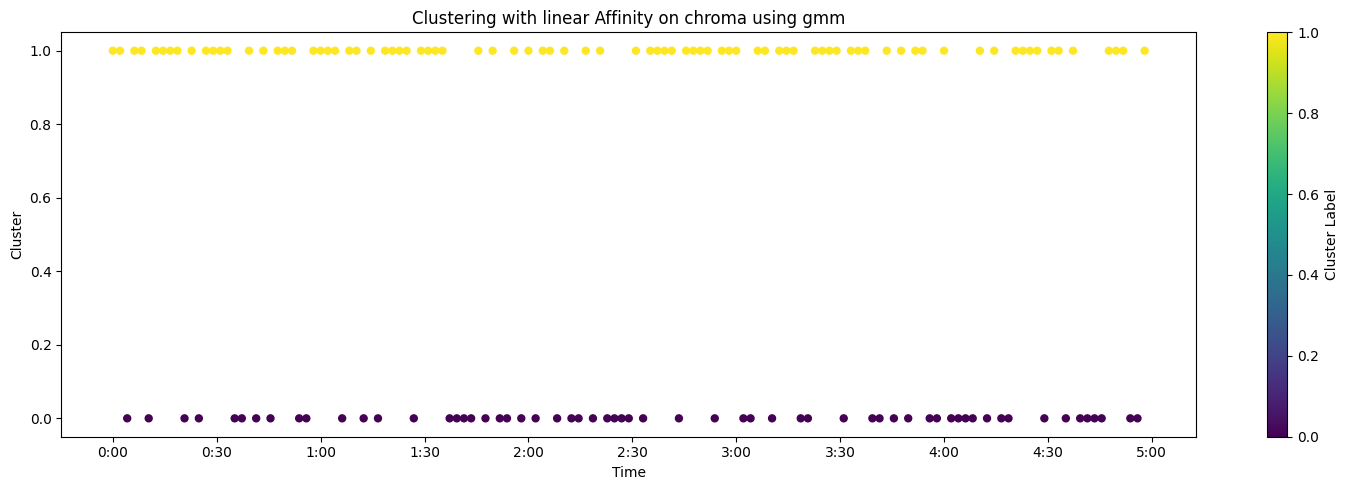

Feature Set: chroma, Affinity: dot_product, Method: kmeans, Silhouette: 0.21762639912541573


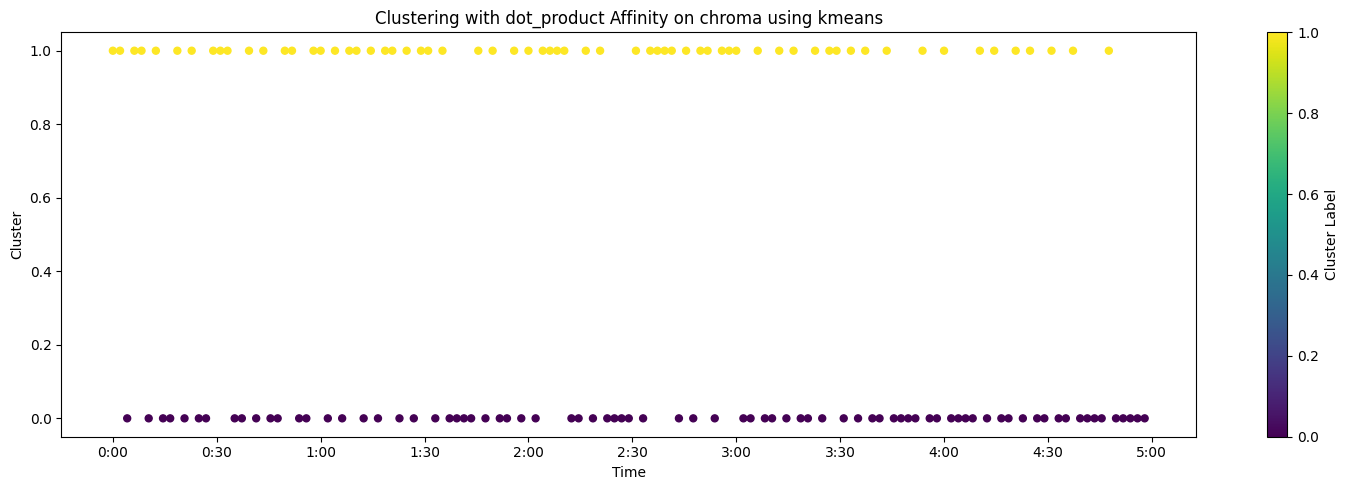

Feature Set: chroma, Affinity: dot_product, Method: dbscan, Silhouette: None


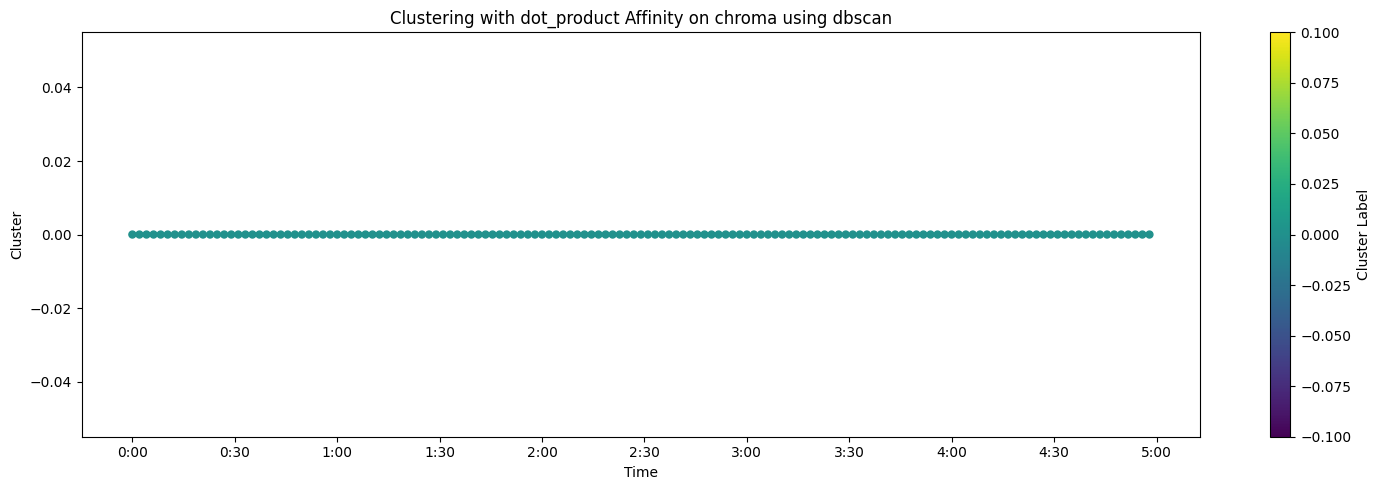

Feature Set: chroma, Affinity: dot_product, Method: gmm, Silhouette: 0.2031914960099951


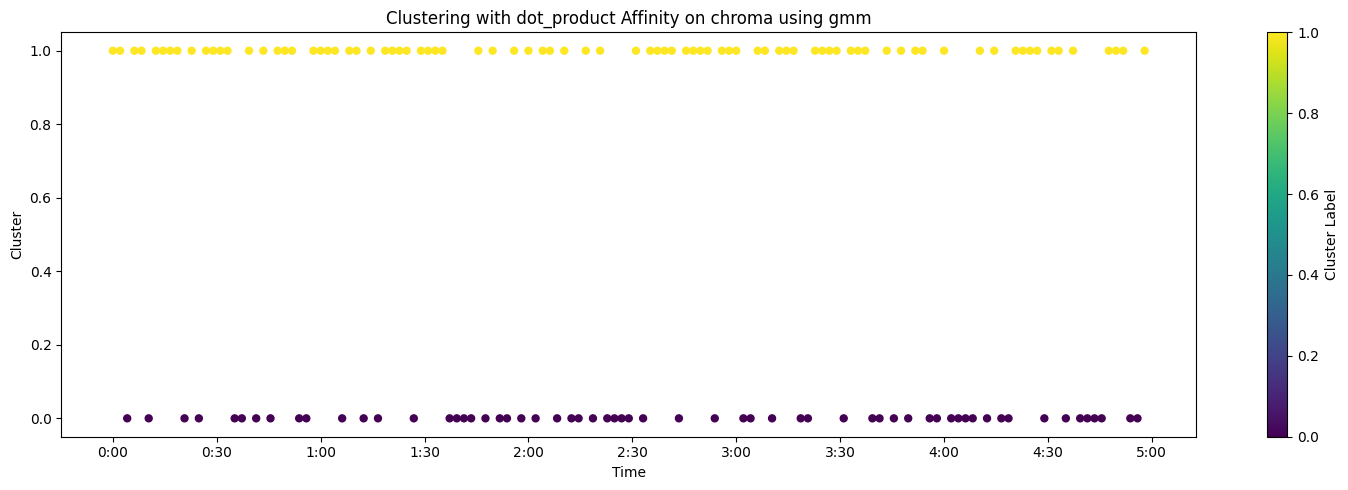

Feature Set: spectral, Affinity: rbf, Method: kmeans, Silhouette: 0.49855536722365923


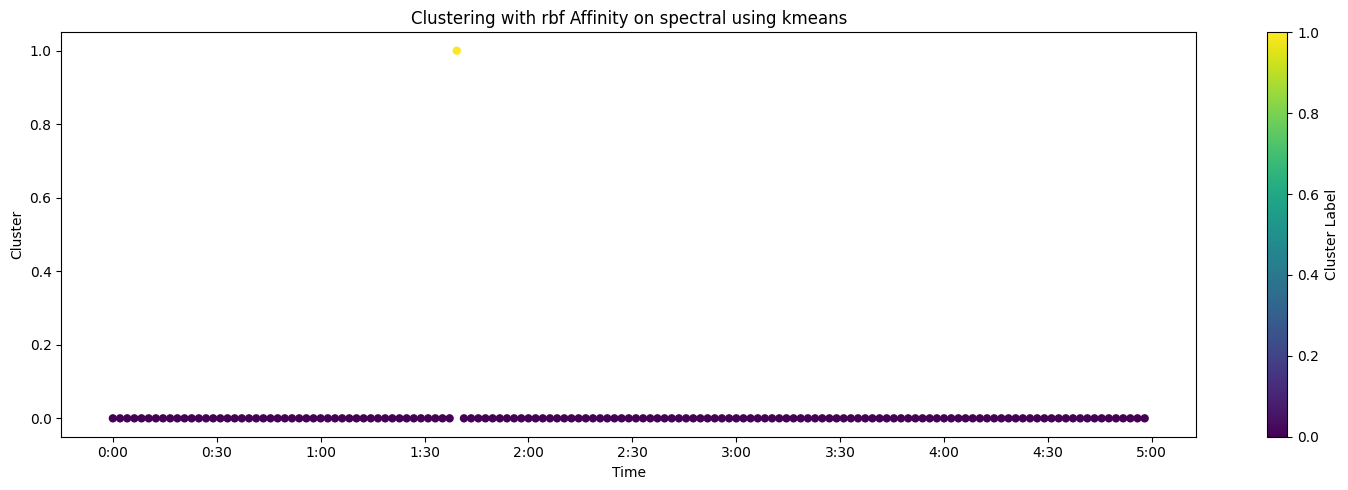

Feature Set: spectral, Affinity: rbf, Method: dbscan, Silhouette: 0.49855536722365923


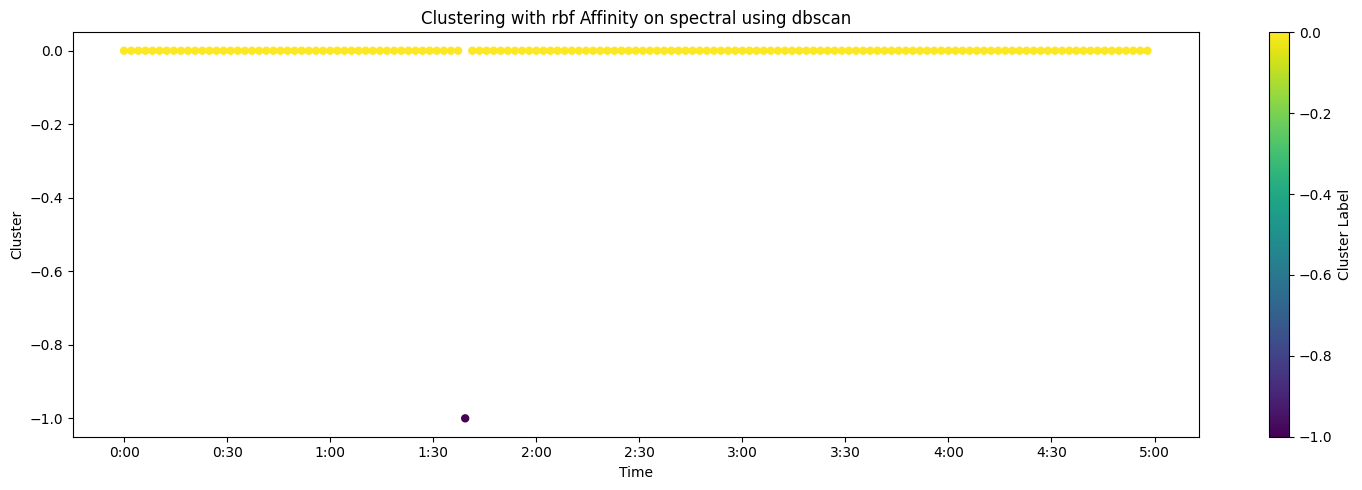

Feature Set: spectral, Affinity: rbf, Method: gmm, Silhouette: 0.49855536722365923


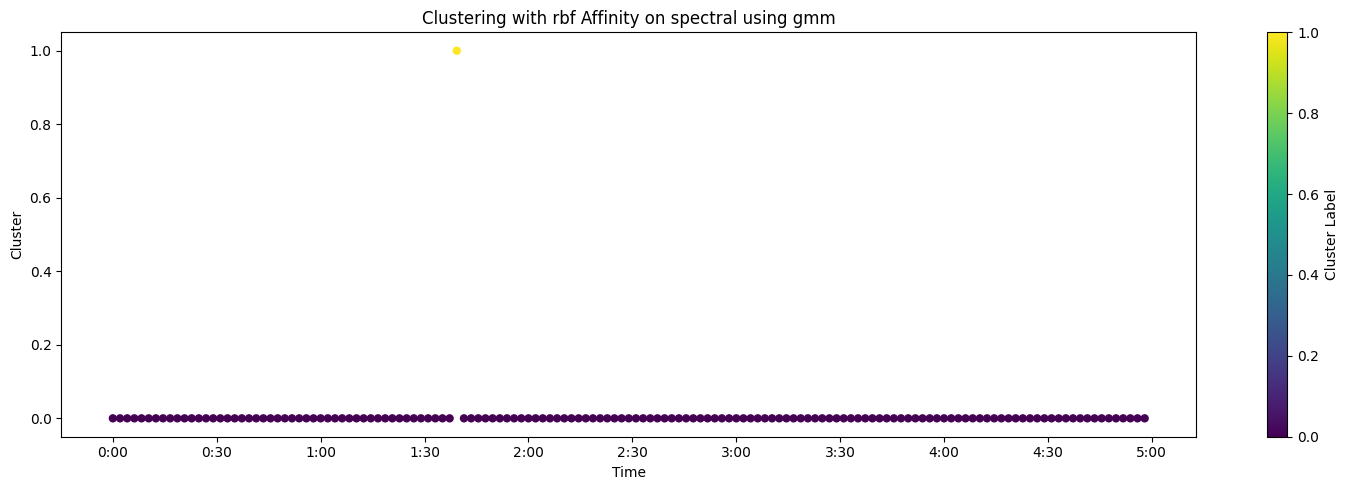

Feature Set: spectral, Affinity: cosine, Method: kmeans, Silhouette: 0.2589332201088379


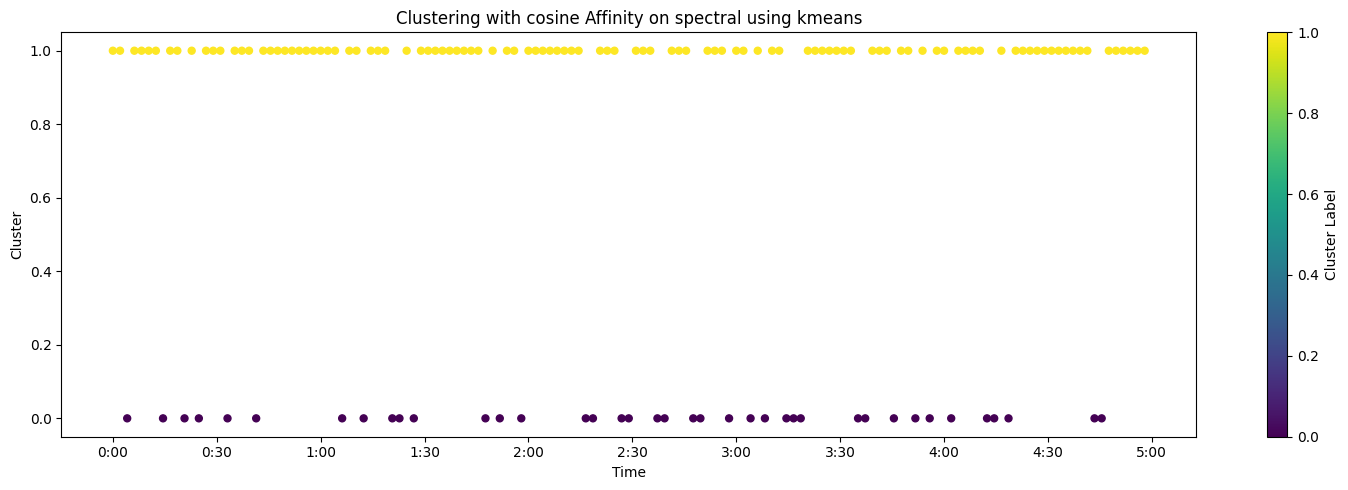

Feature Set: spectral, Affinity: cosine, Method: dbscan, Silhouette: None


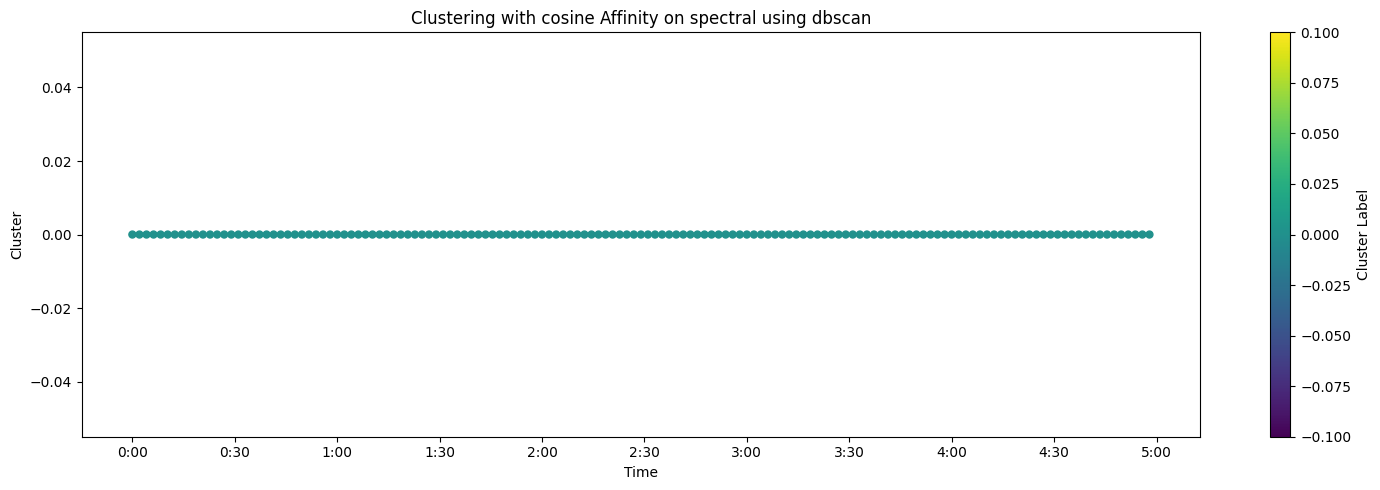

Feature Set: spectral, Affinity: cosine, Method: gmm, Silhouette: 0.23393116371901598


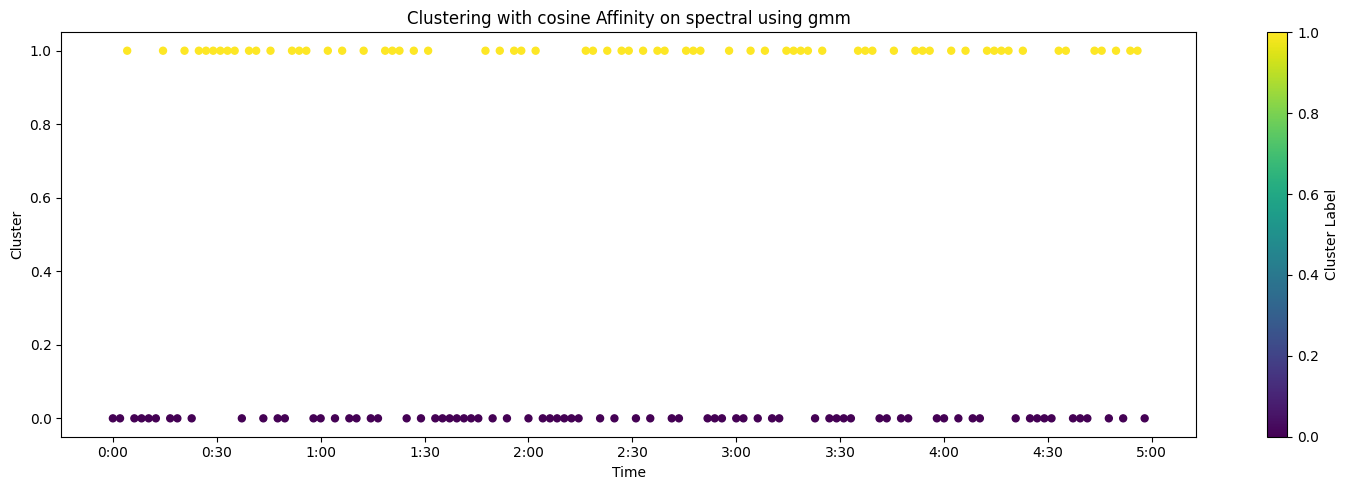

Feature Set: spectral, Affinity: polynomial, Method: kmeans, Silhouette: 0.304115694499641


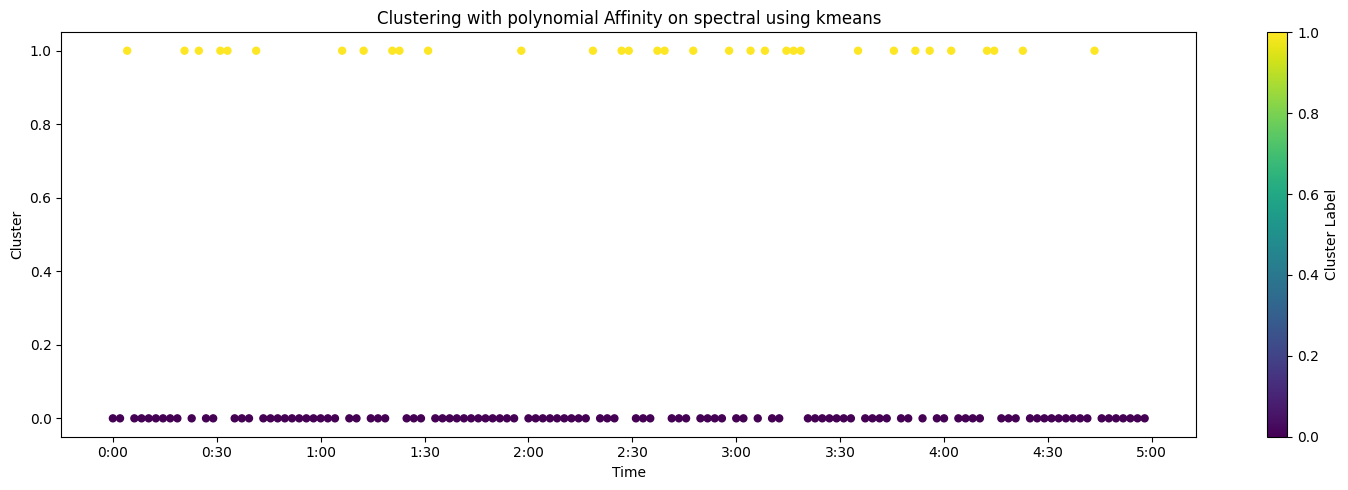

Feature Set: spectral, Affinity: polynomial, Method: dbscan, Silhouette: None


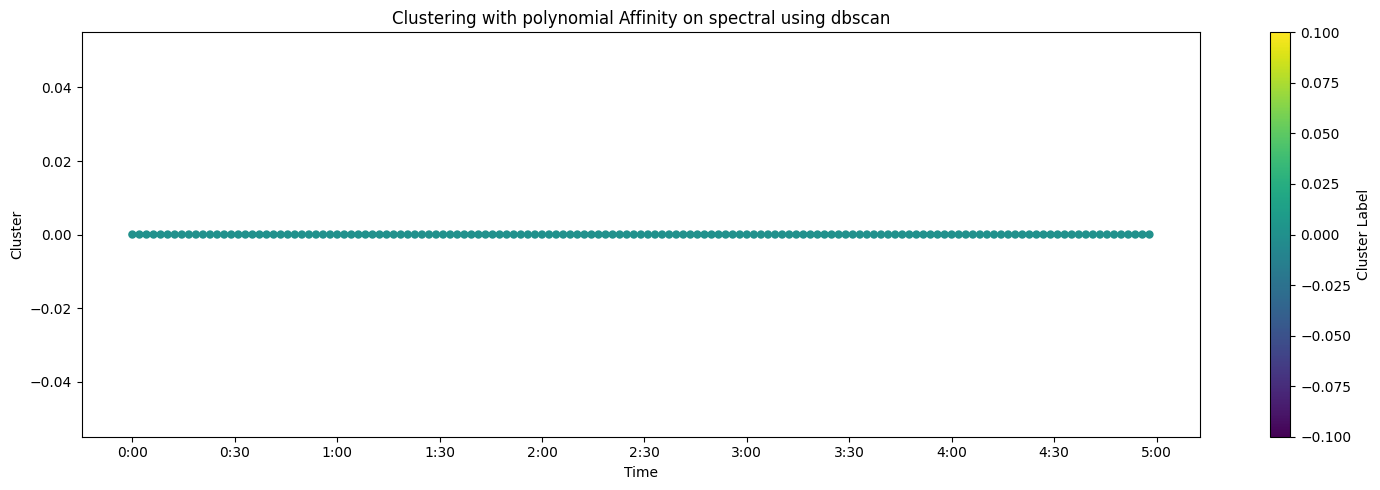

Feature Set: spectral, Affinity: polynomial, Method: gmm, Silhouette: 0.2914006386734461


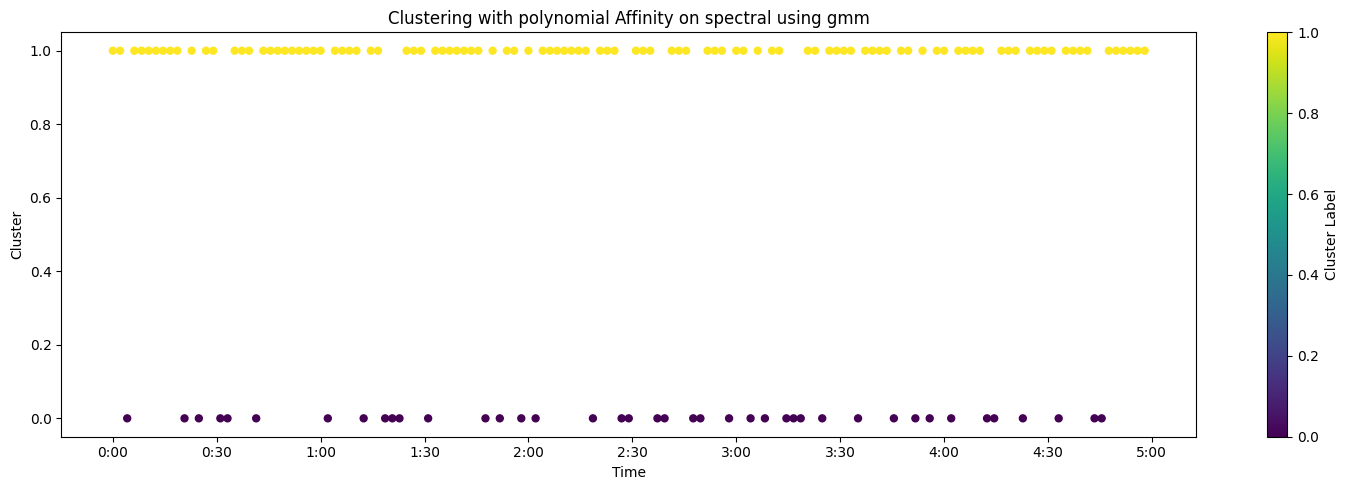

Feature Set: spectral, Affinity: linear, Method: kmeans, Silhouette: 0.2066280253315233


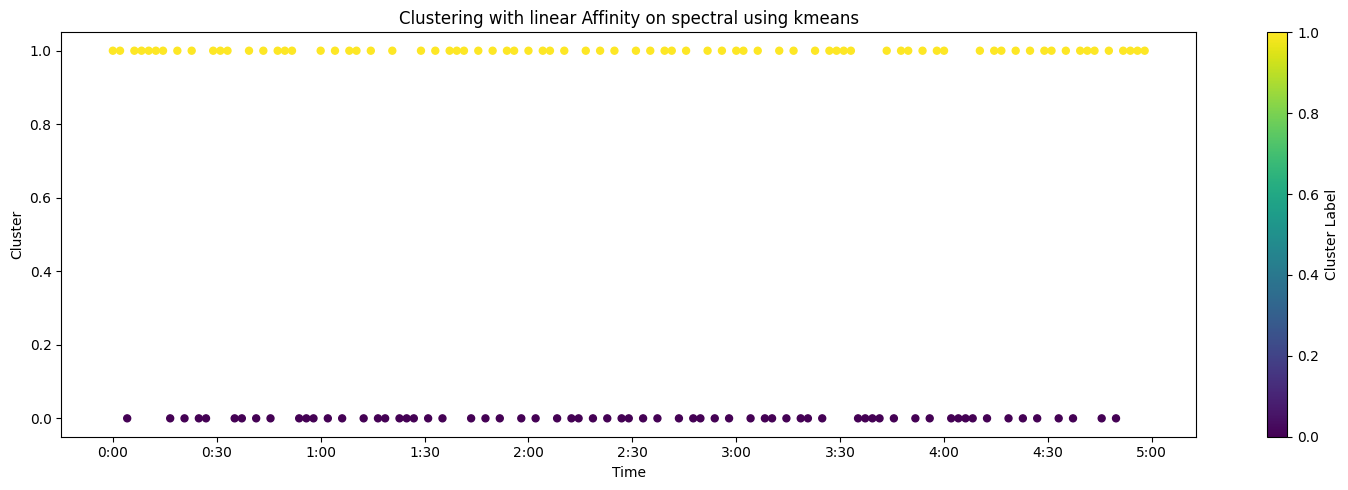

Feature Set: spectral, Affinity: linear, Method: dbscan, Silhouette: None


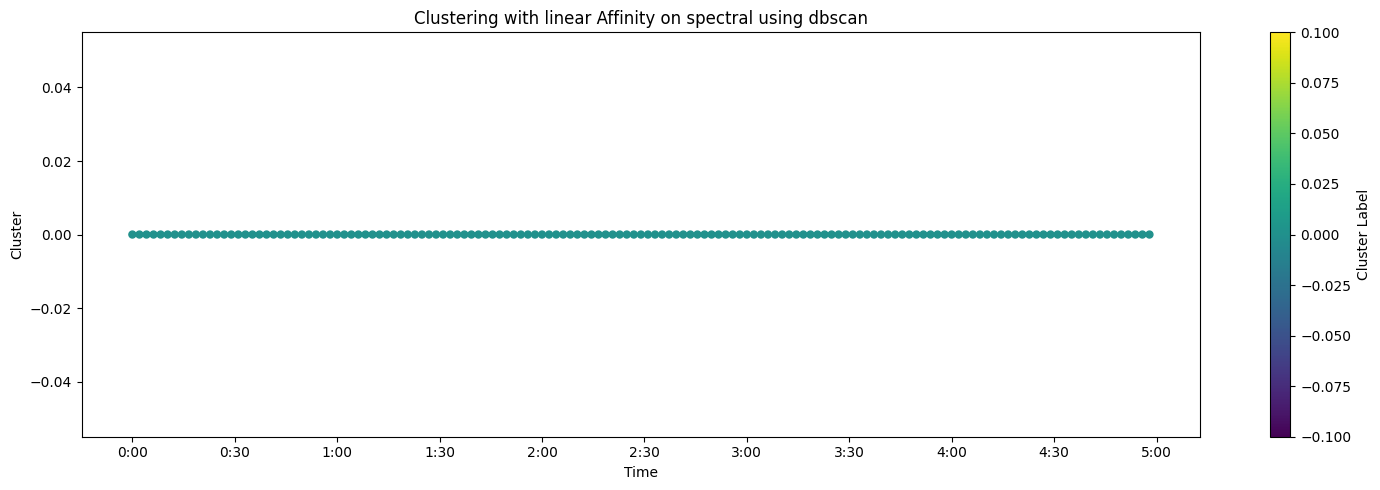

Feature Set: spectral, Affinity: linear, Method: gmm, Silhouette: 0.2512214334245804


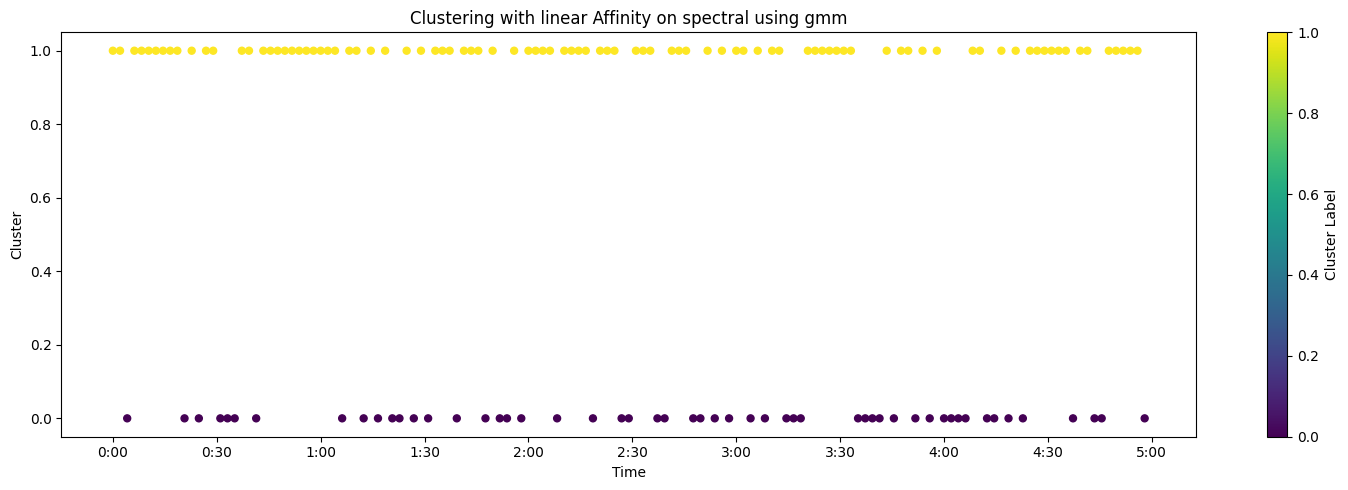

Feature Set: spectral, Affinity: dot_product, Method: kmeans, Silhouette: 0.20894140486903448


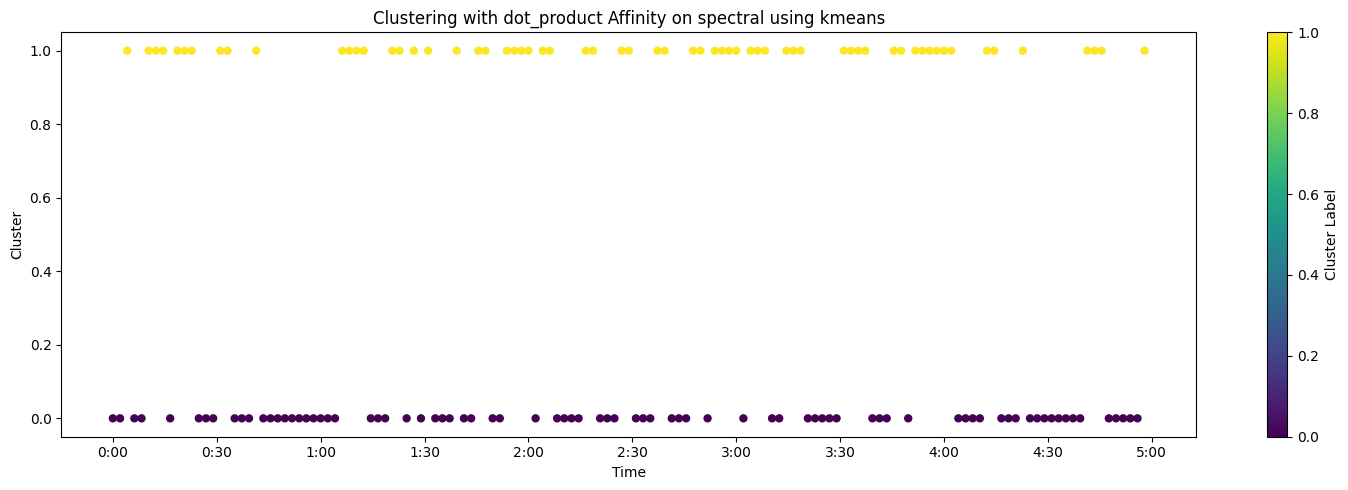

Feature Set: spectral, Affinity: dot_product, Method: dbscan, Silhouette: None


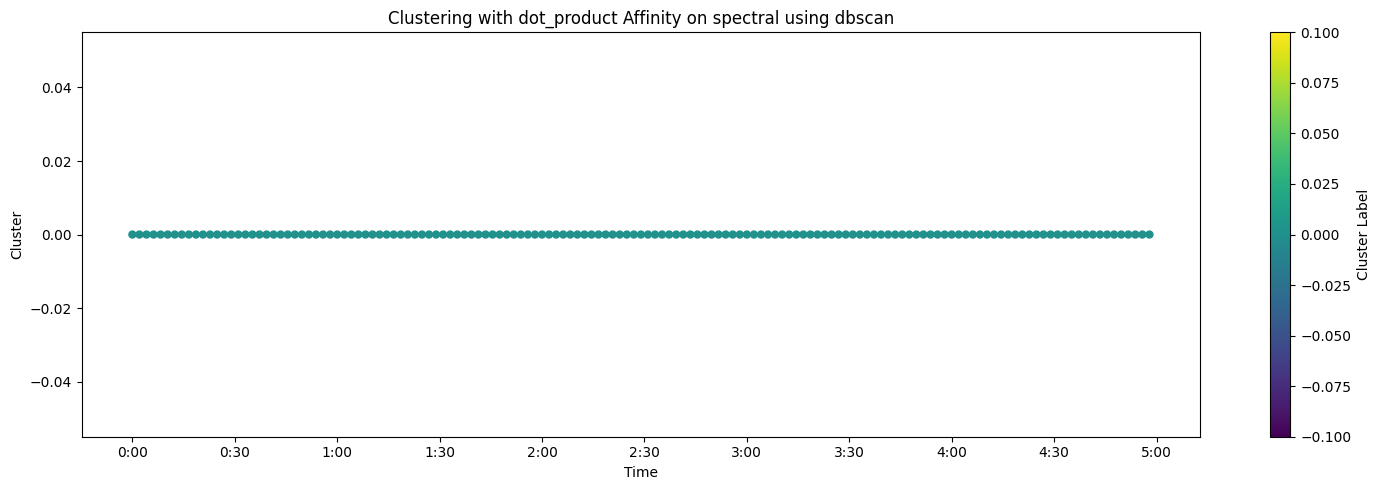

Feature Set: spectral, Affinity: dot_product, Method: gmm, Silhouette: 0.2172667787032727


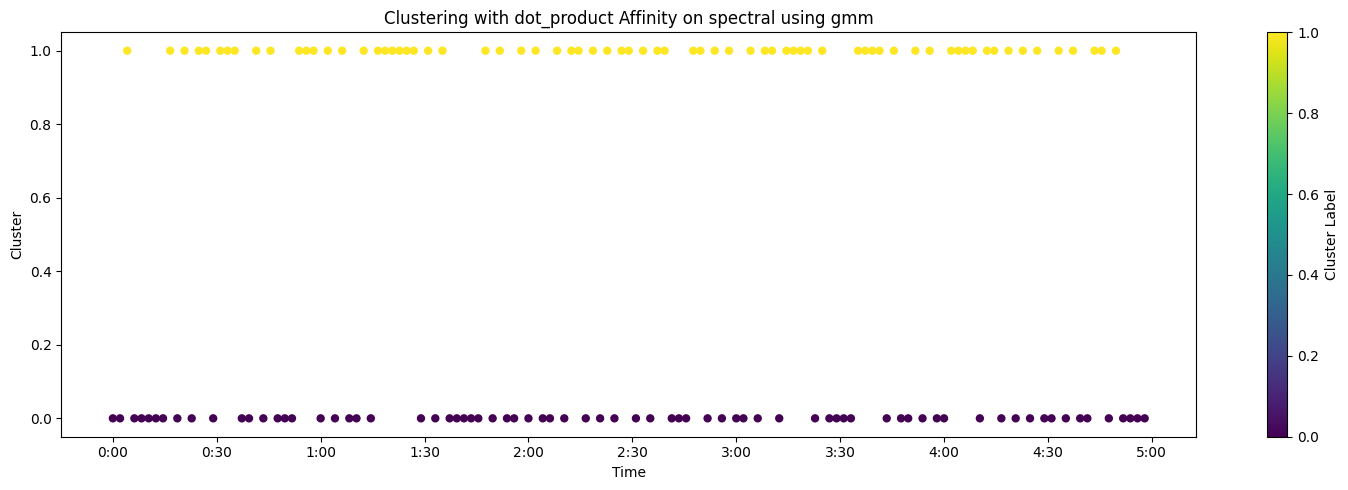

Feature Set: mfccs_delta, Affinity: rbf, Method: kmeans, Silhouette: 0.7348416919579379


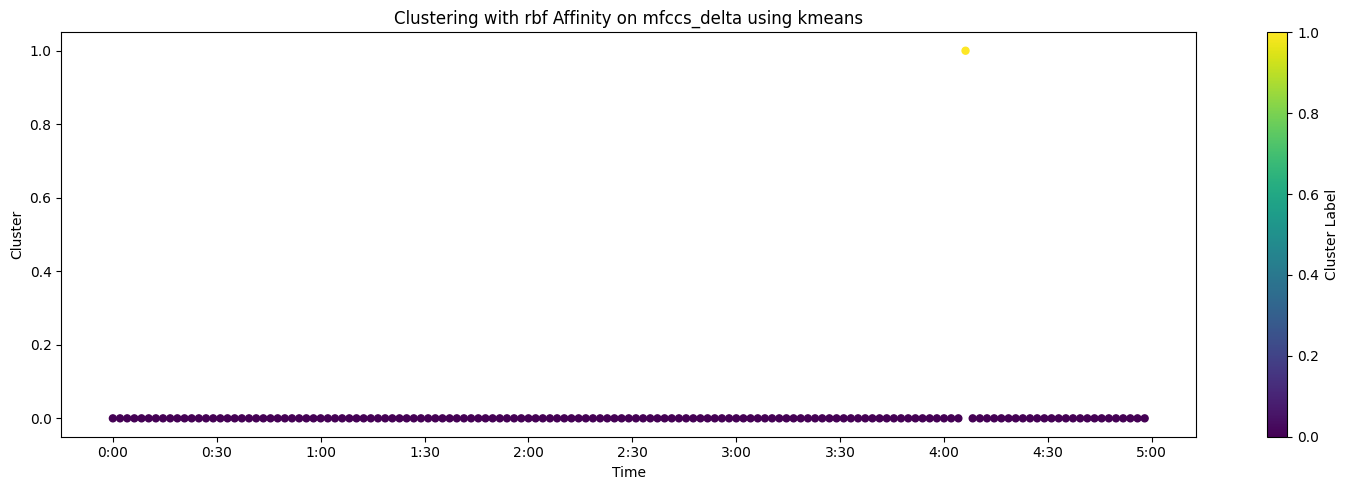

Feature Set: mfccs_delta, Affinity: rbf, Method: dbscan, Silhouette: 0.698908142911146


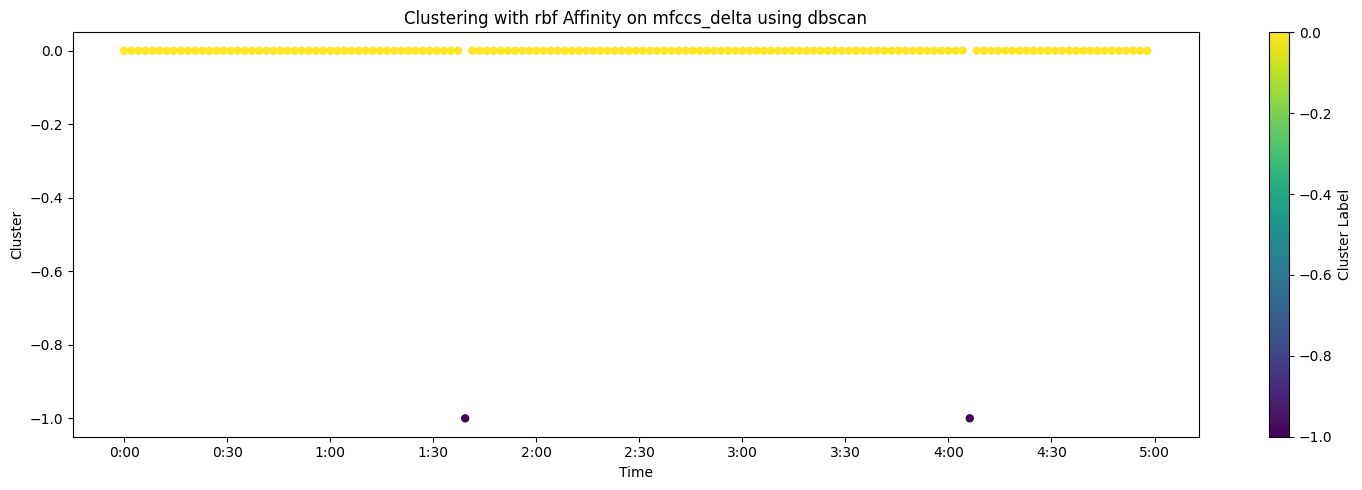

Feature Set: mfccs_delta, Affinity: rbf, Method: gmm, Silhouette: 0.6312629140318322


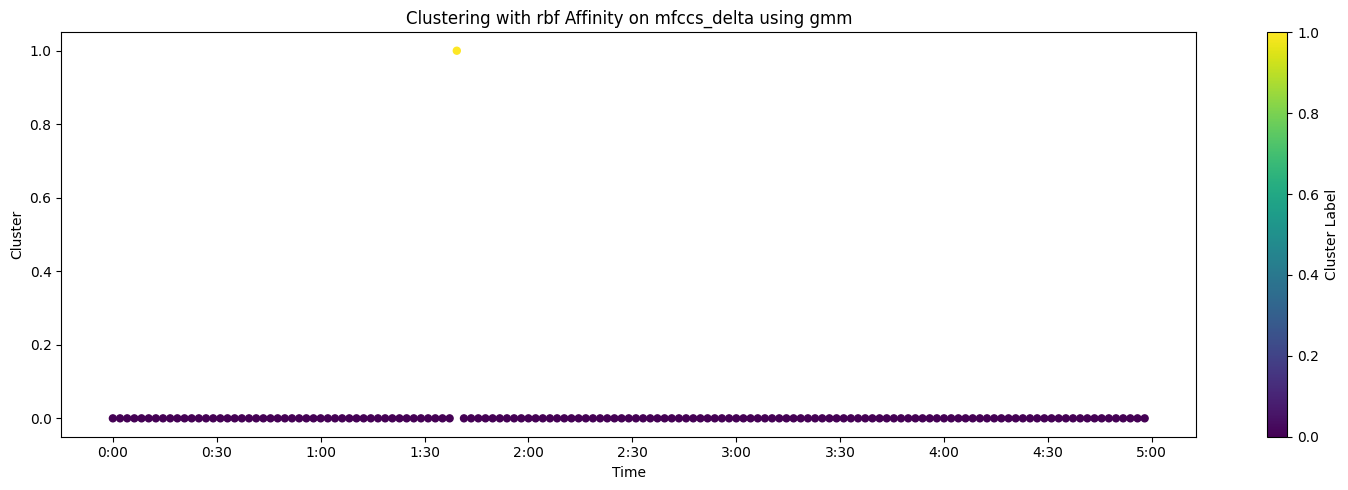

Feature Set: mfccs_delta, Affinity: cosine, Method: kmeans, Silhouette: 0.2004972133207275


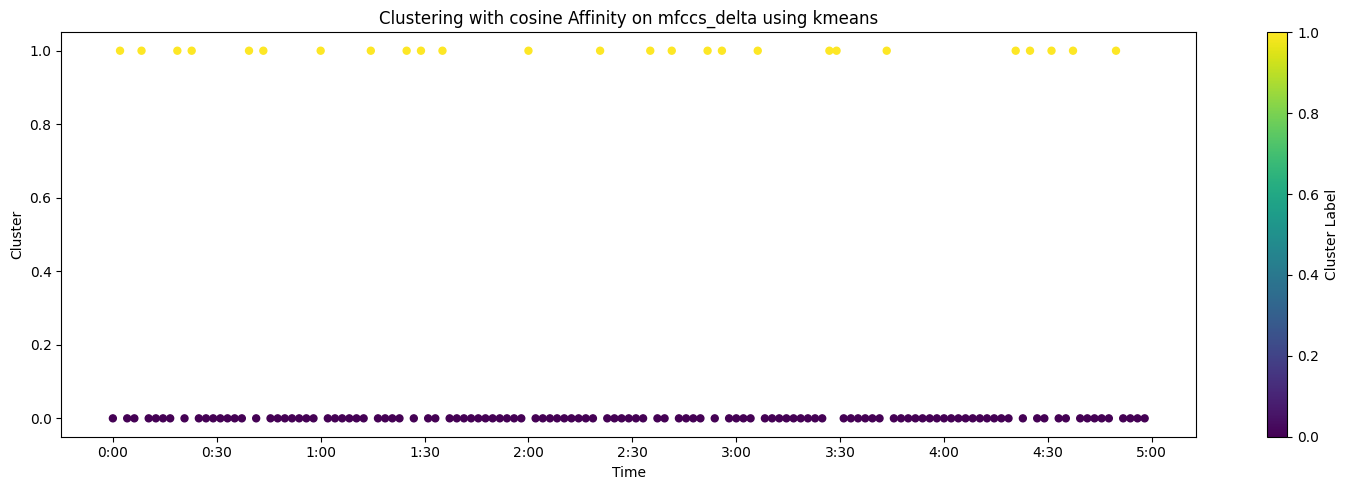

Feature Set: mfccs_delta, Affinity: cosine, Method: dbscan, Silhouette: None


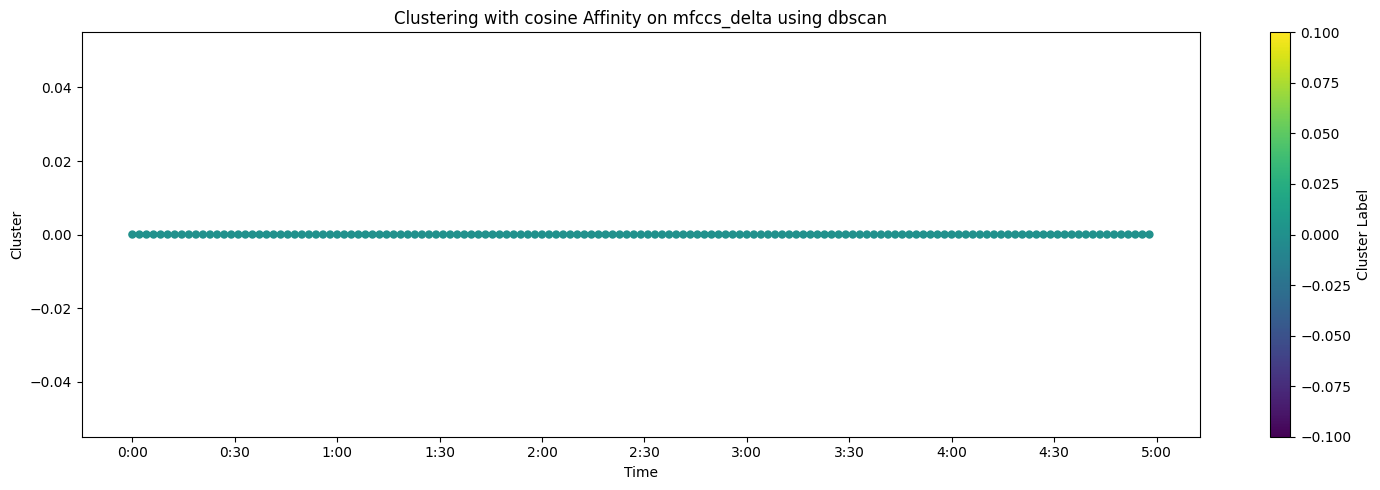

Feature Set: mfccs_delta, Affinity: cosine, Method: gmm, Silhouette: 0.2218325831717798


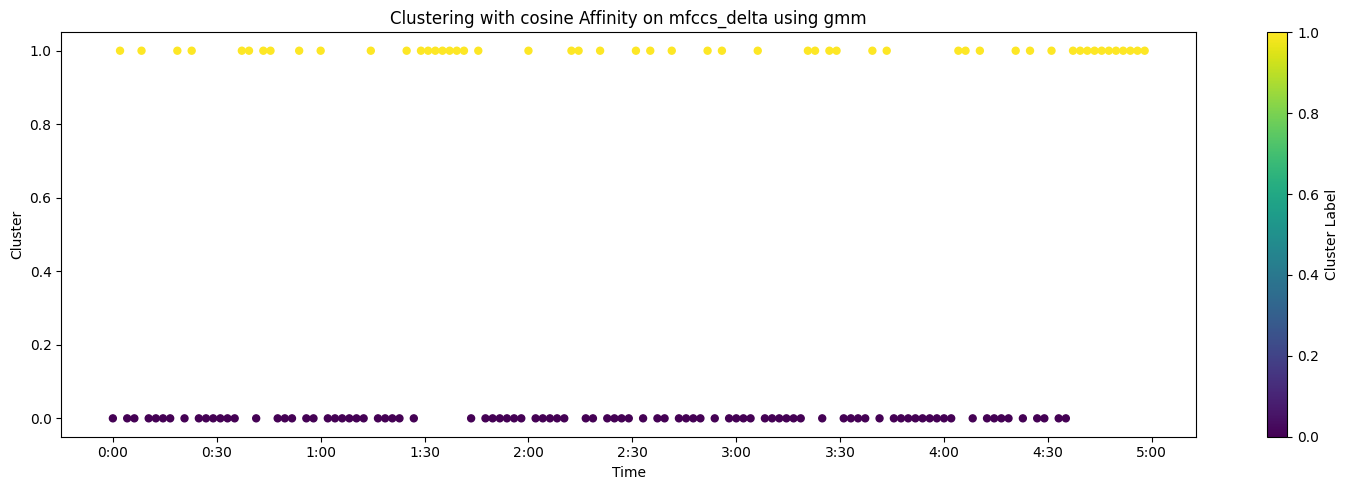

Feature Set: mfccs_delta, Affinity: polynomial, Method: kmeans, Silhouette: 0.7348416919579379


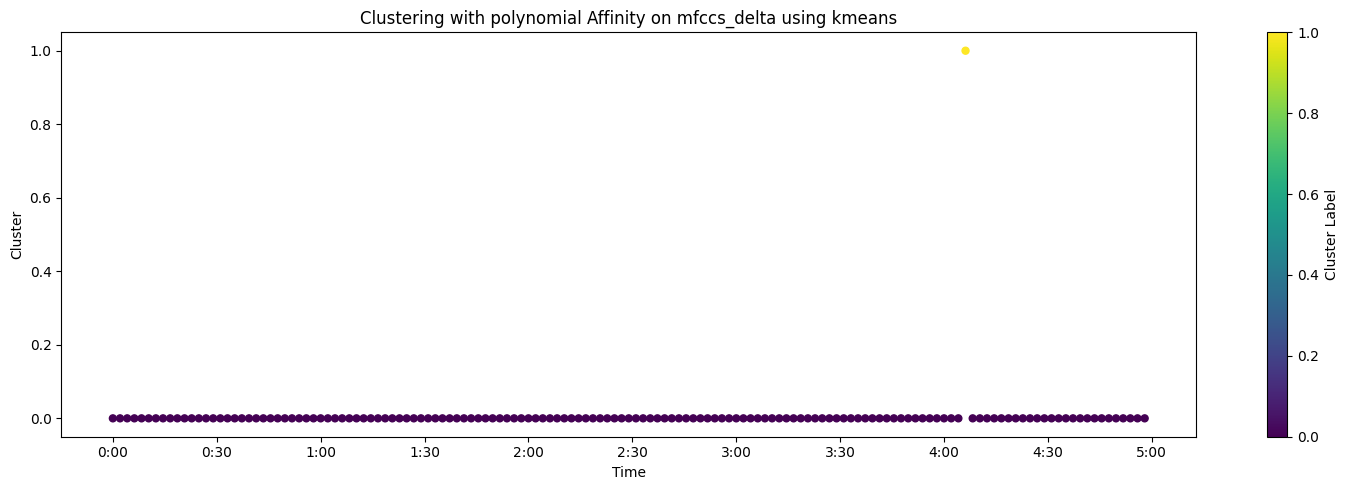

Feature Set: mfccs_delta, Affinity: polynomial, Method: dbscan, Silhouette: 0.7348416919579379


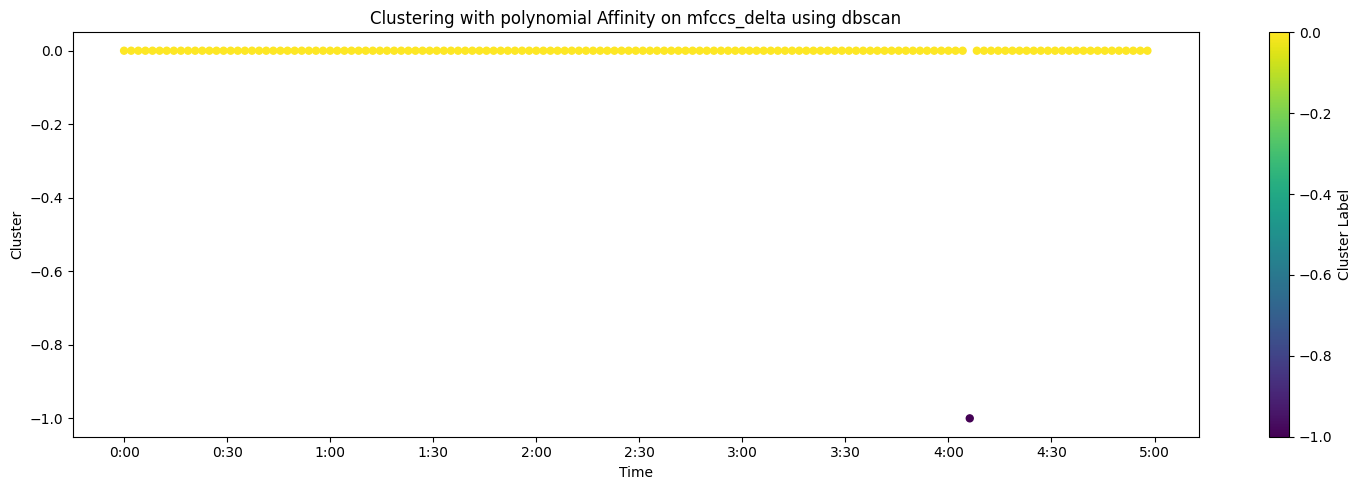

Feature Set: mfccs_delta, Affinity: polynomial, Method: gmm, Silhouette: 0.5438842929606451


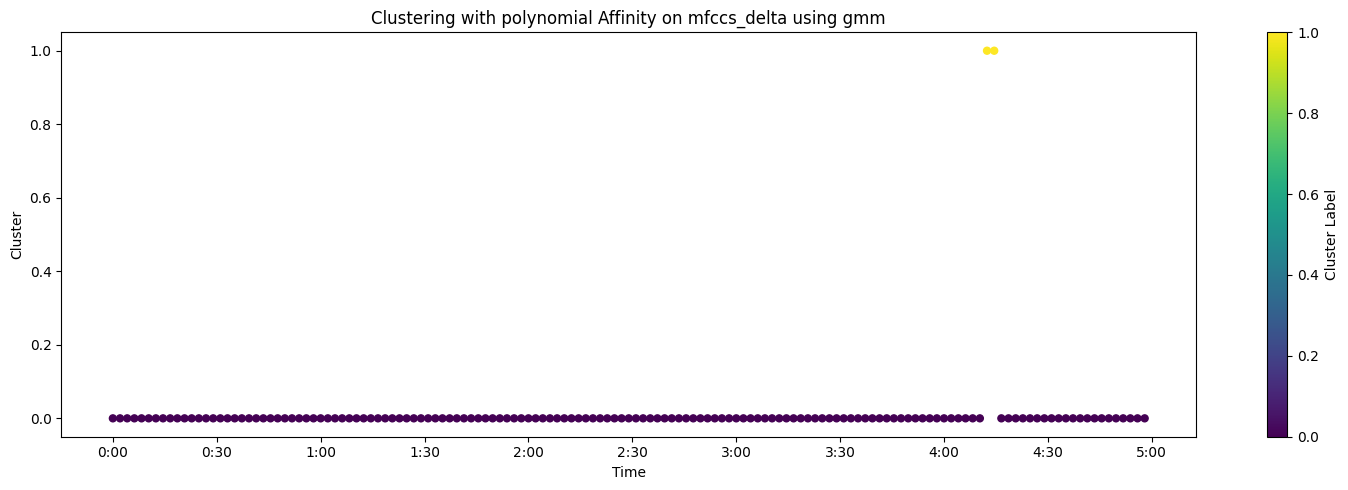

Feature Set: mfccs_delta, Affinity: linear, Method: kmeans, Silhouette: 0.2294808189194309


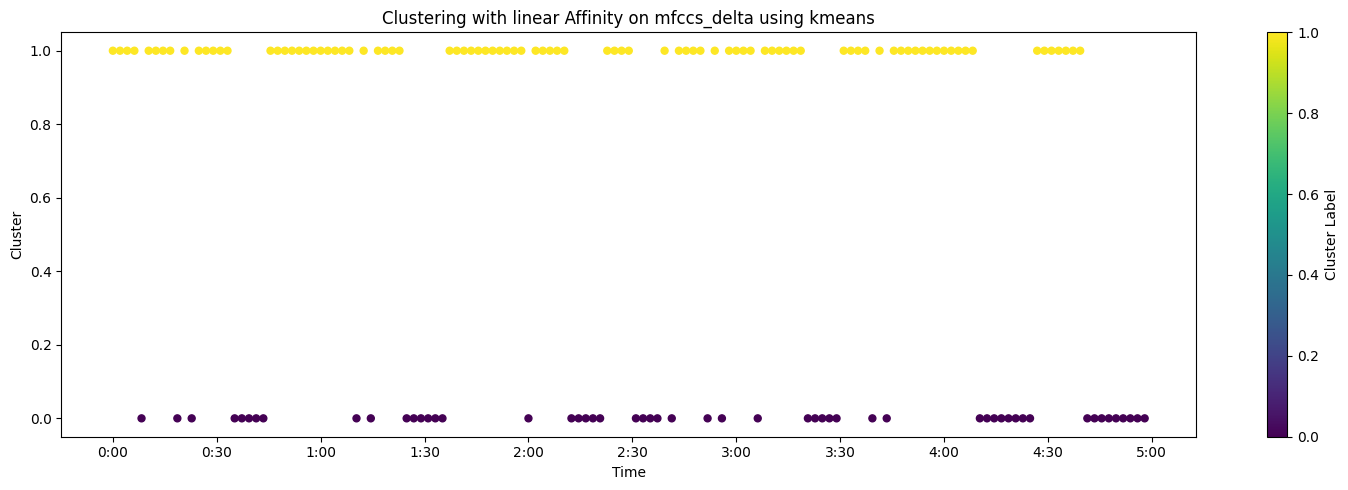

Feature Set: mfccs_delta, Affinity: linear, Method: dbscan, Silhouette: None


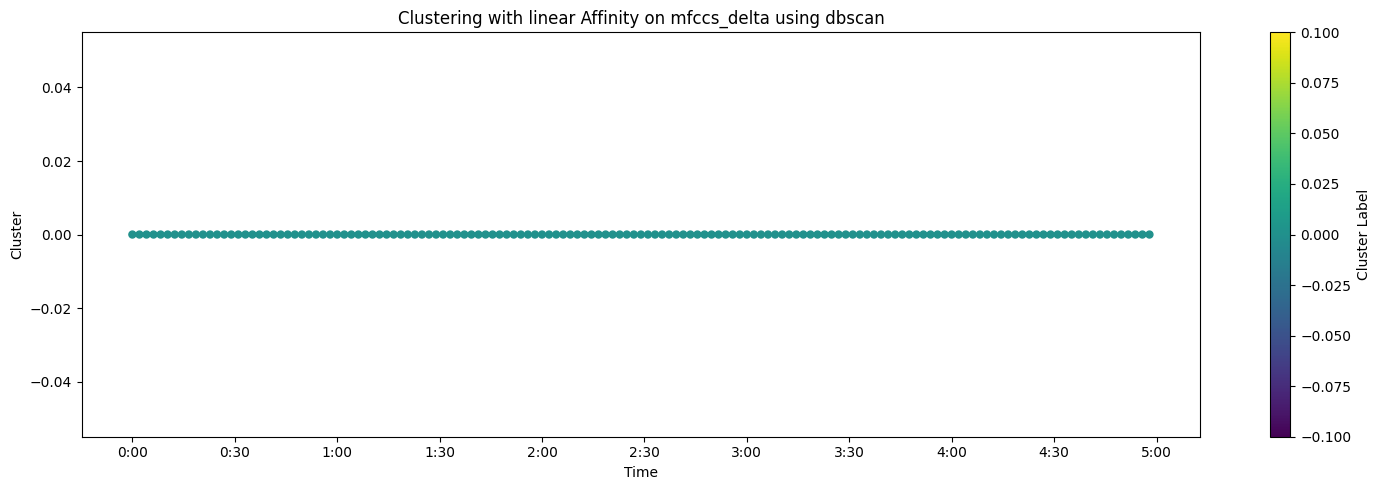

Feature Set: mfccs_delta, Affinity: linear, Method: gmm, Silhouette: 0.261726400546684


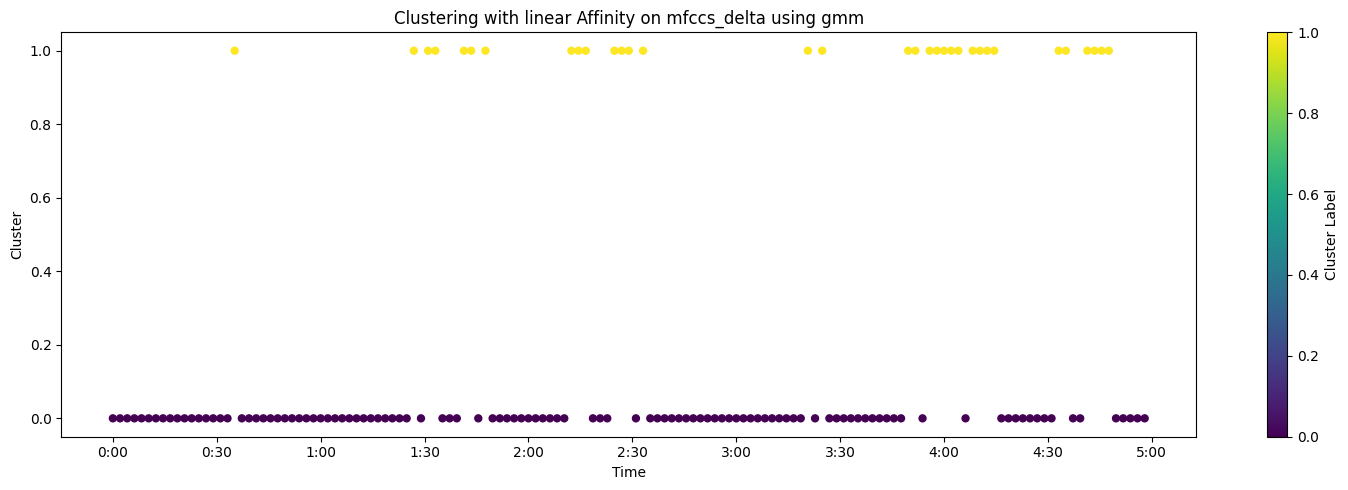

Feature Set: mfccs_delta, Affinity: dot_product, Method: kmeans, Silhouette: 0.2294808189194309


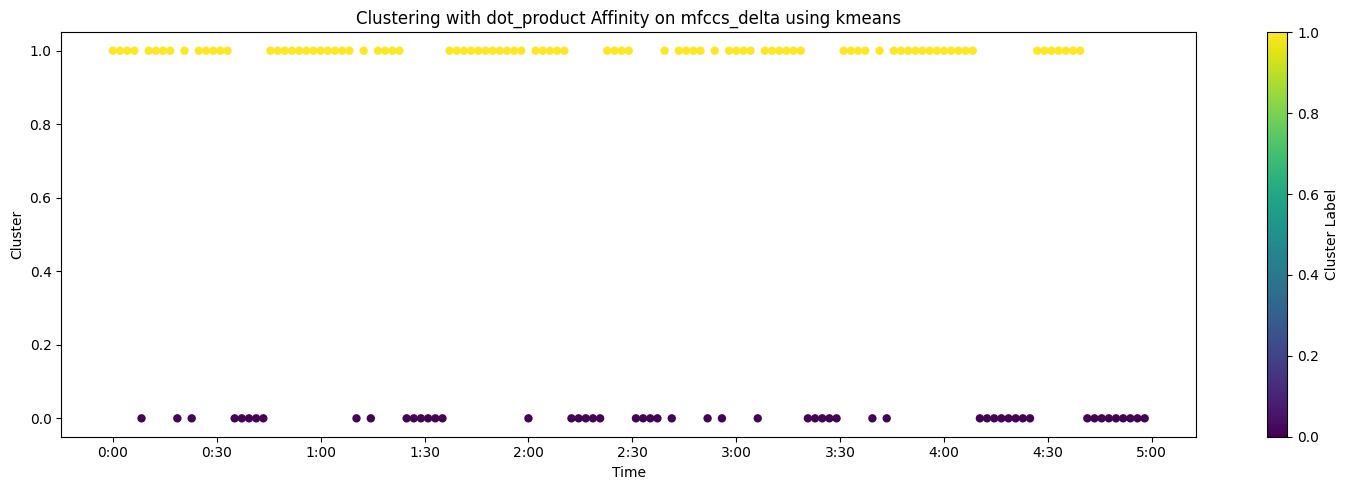

Feature Set: mfccs_delta, Affinity: dot_product, Method: dbscan, Silhouette: None


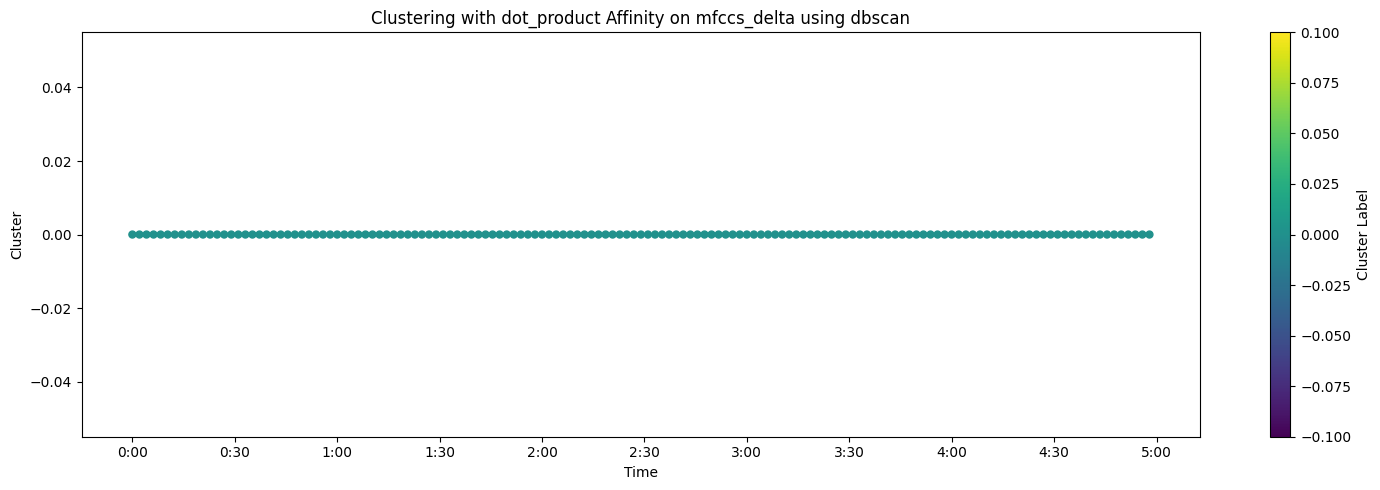

Feature Set: mfccs_delta, Affinity: dot_product, Method: gmm, Silhouette: 0.27179117642540346


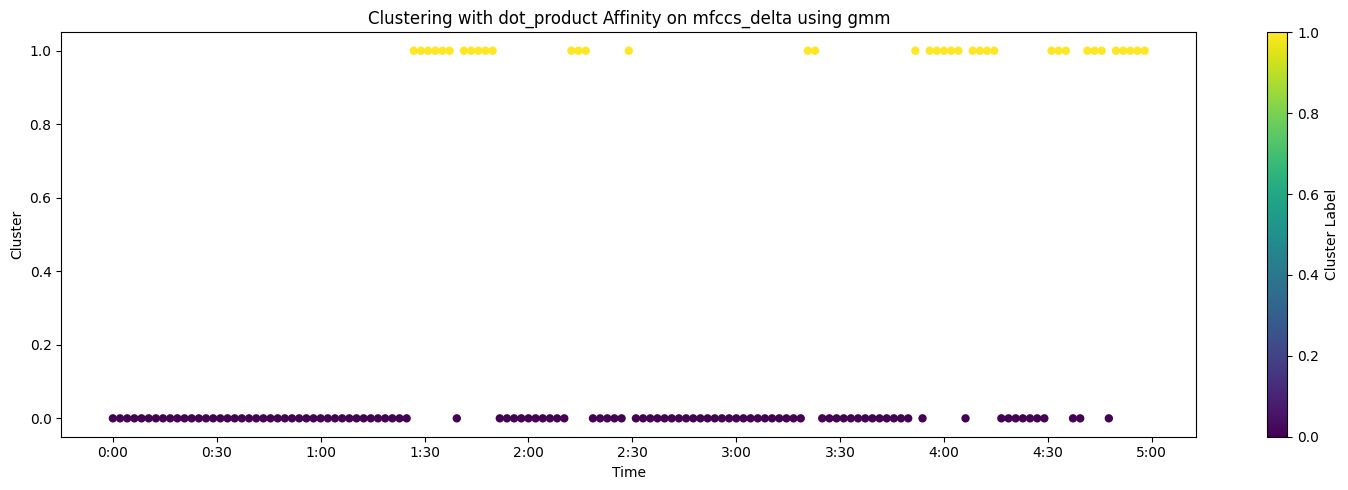

Feature Set: mfccs_chroma, Affinity: rbf, Method: kmeans, Silhouette: 0.7038948357684964


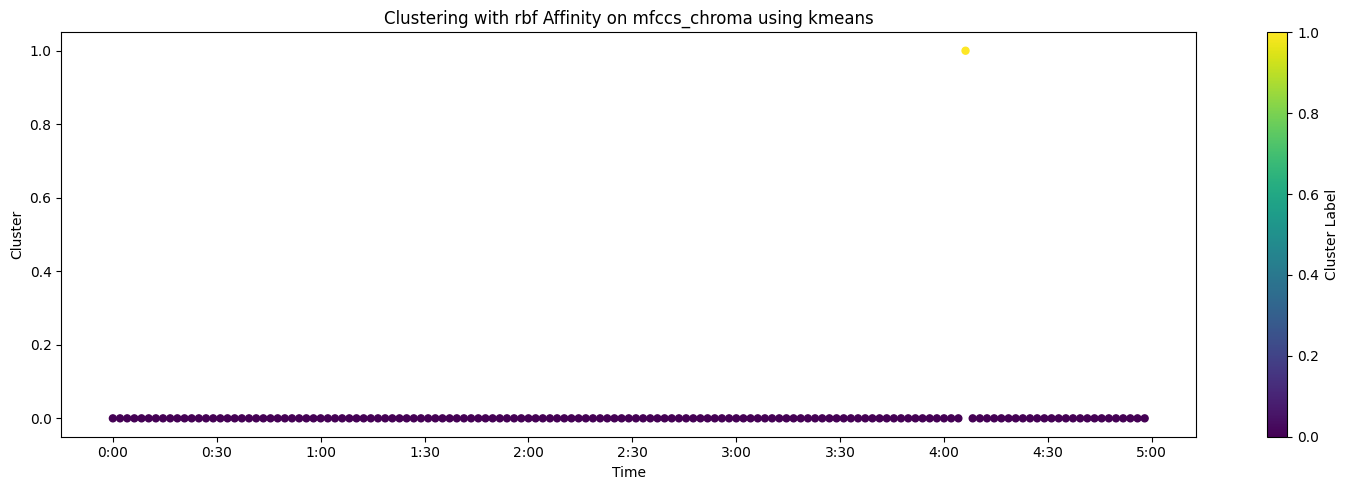

Feature Set: mfccs_chroma, Affinity: rbf, Method: dbscan, Silhouette: 0.6621776279041891


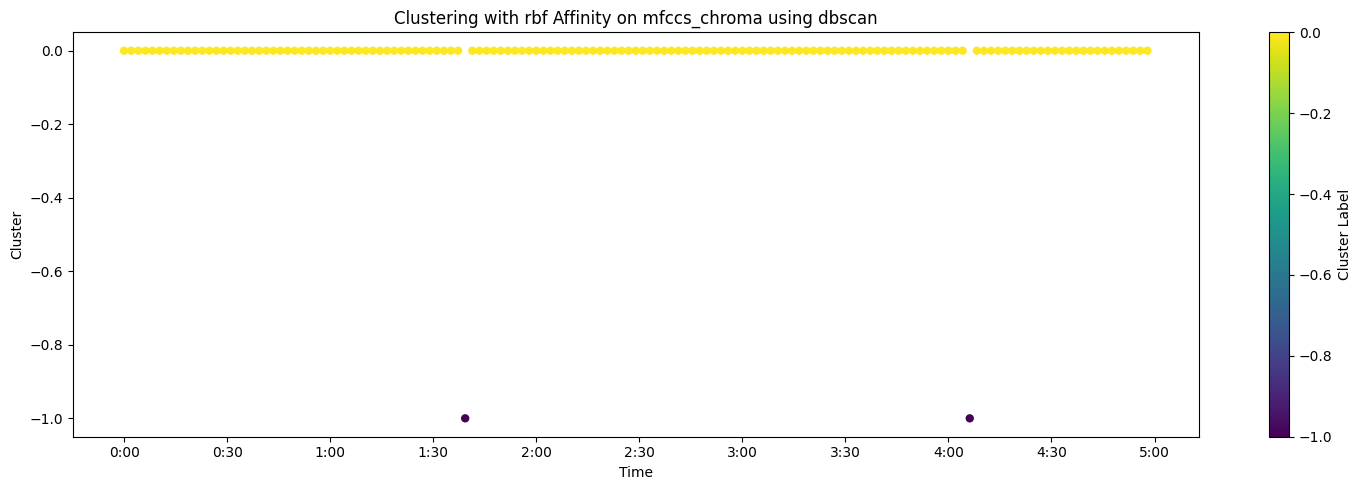

Feature Set: mfccs_chroma, Affinity: rbf, Method: gmm, Silhouette: 0.5866999763307235


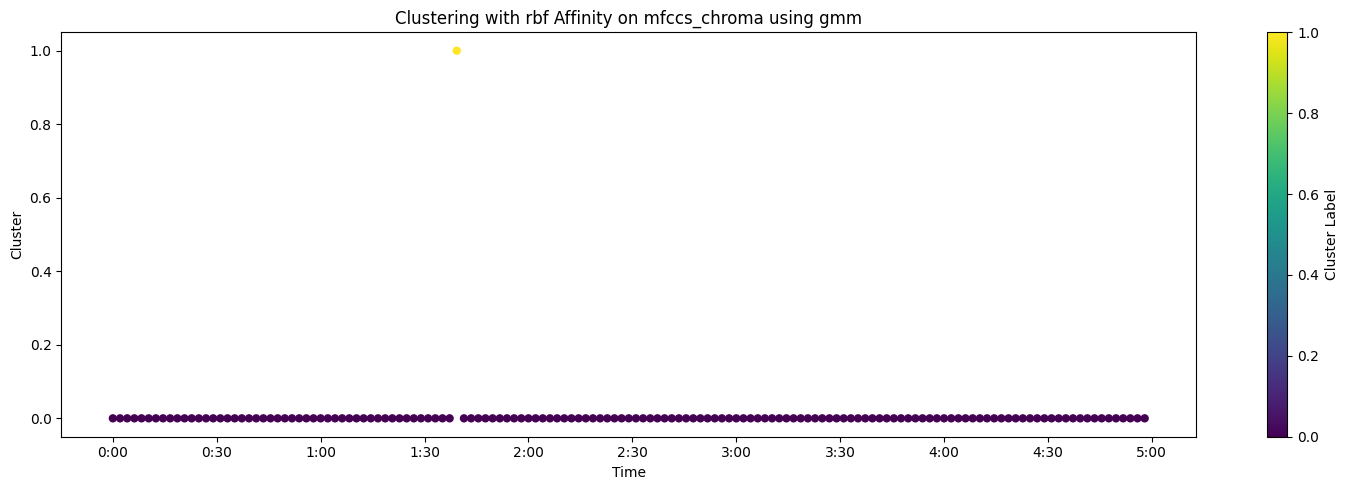

Feature Set: mfccs_chroma, Affinity: cosine, Method: kmeans, Silhouette: 0.1662264034659135


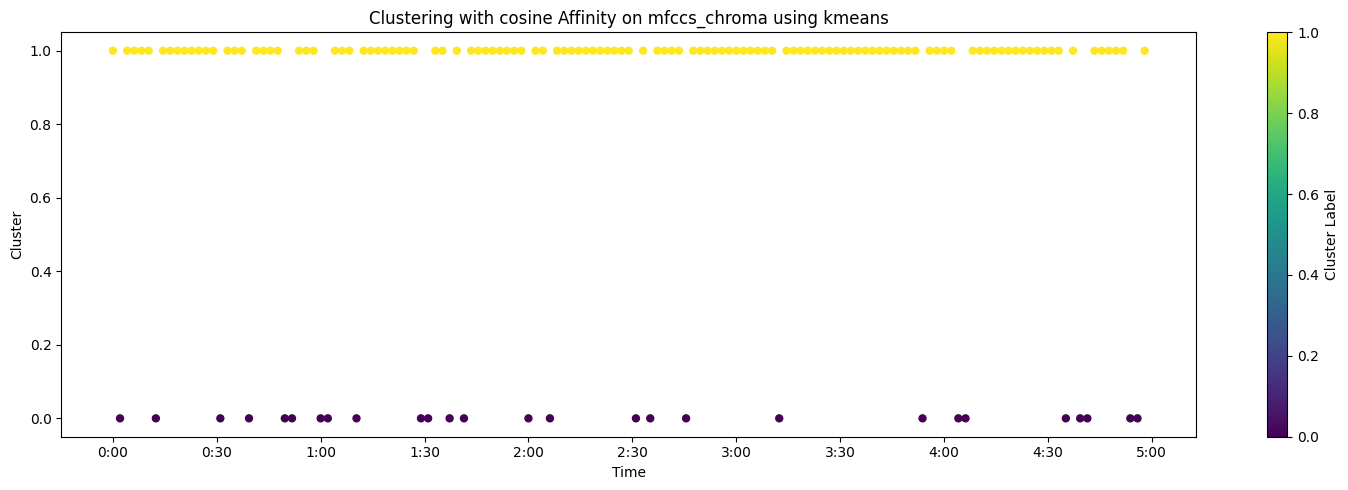

Feature Set: mfccs_chroma, Affinity: cosine, Method: dbscan, Silhouette: None


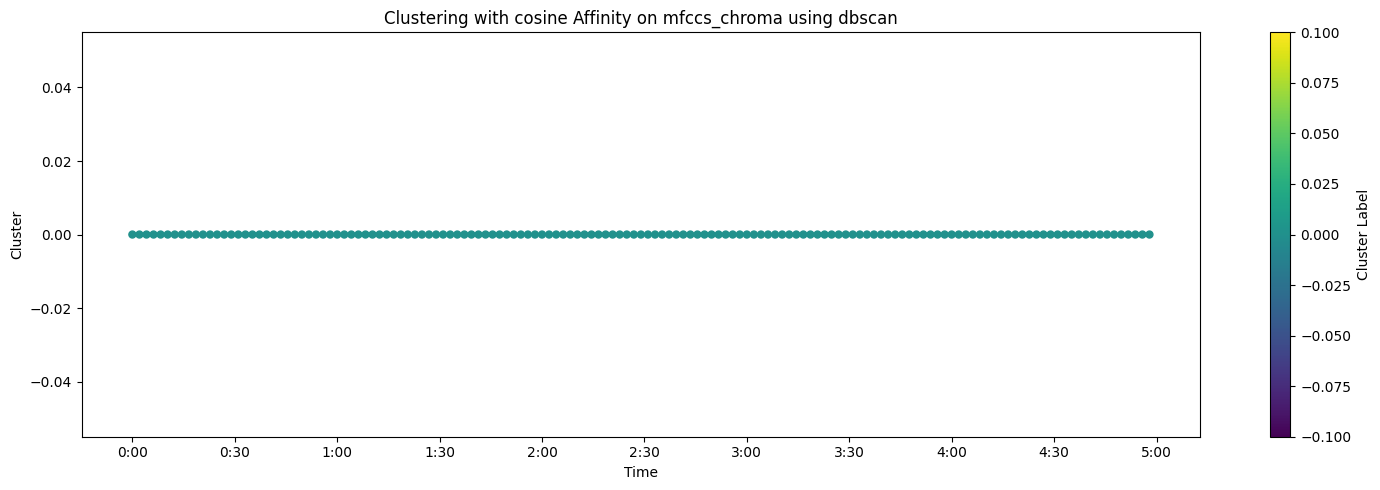

Feature Set: mfccs_chroma, Affinity: cosine, Method: gmm, Silhouette: 0.2375768235945768


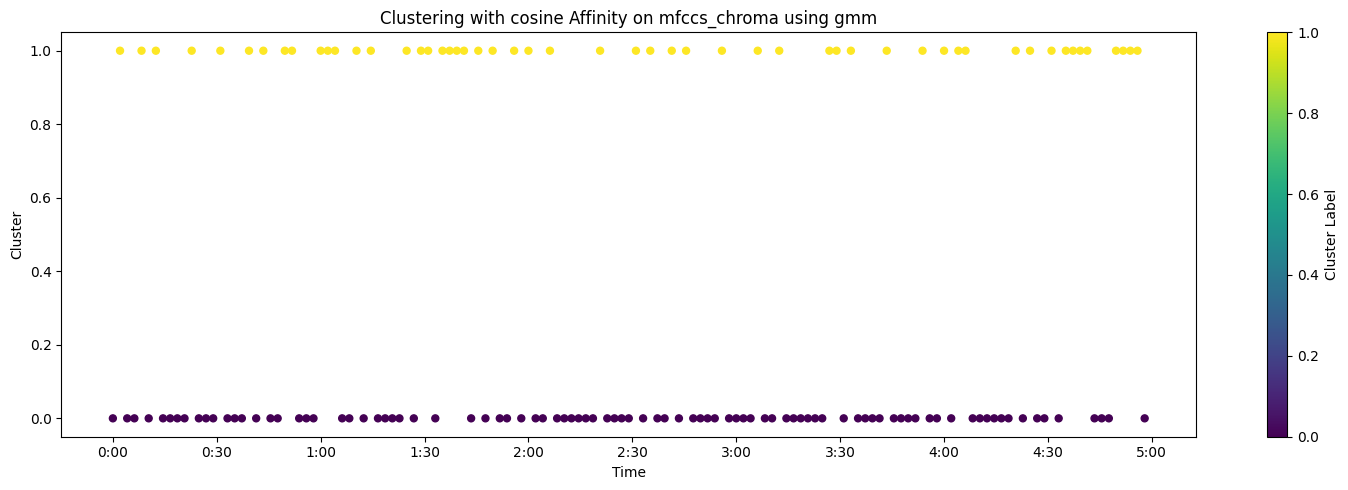

Feature Set: mfccs_chroma, Affinity: polynomial, Method: kmeans, Silhouette: 0.7038948357684964


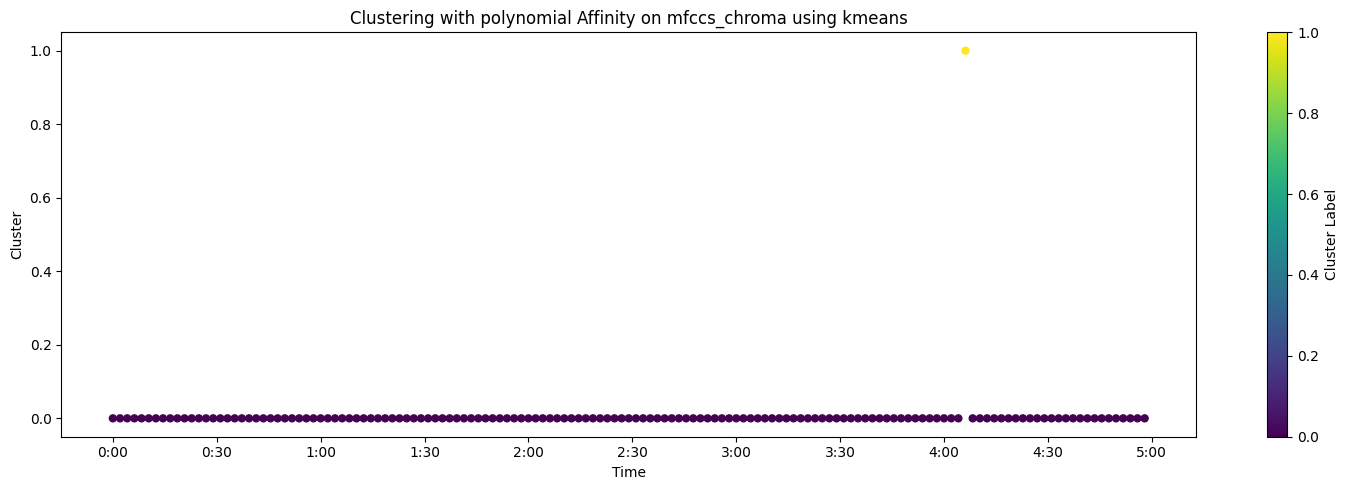

Feature Set: mfccs_chroma, Affinity: polynomial, Method: dbscan, Silhouette: 0.7038948357684964


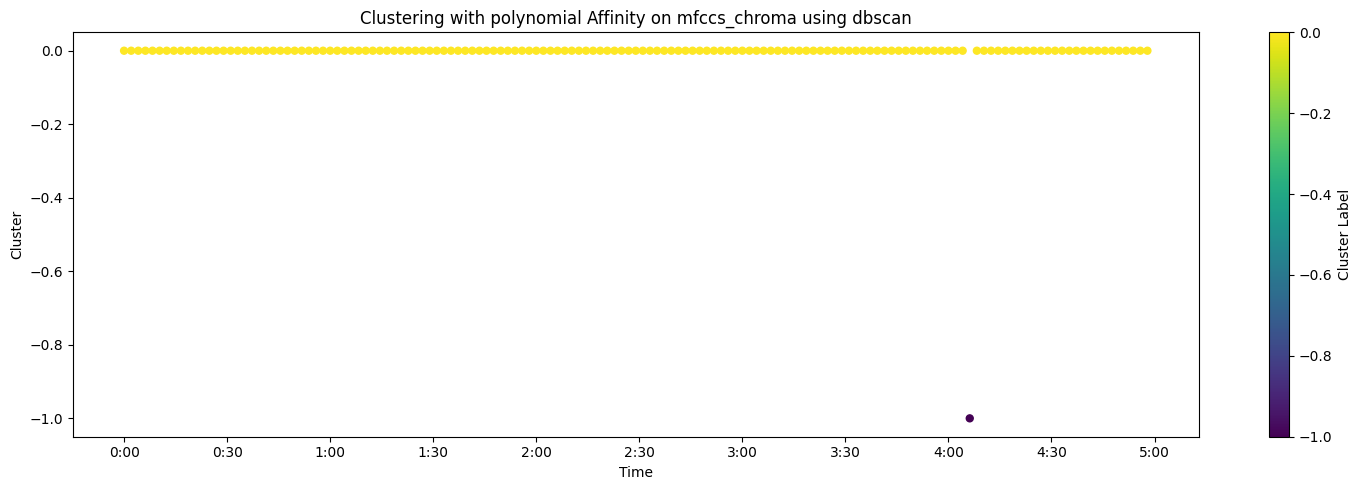

Feature Set: mfccs_chroma, Affinity: polynomial, Method: gmm, Silhouette: 0.20830286233818832


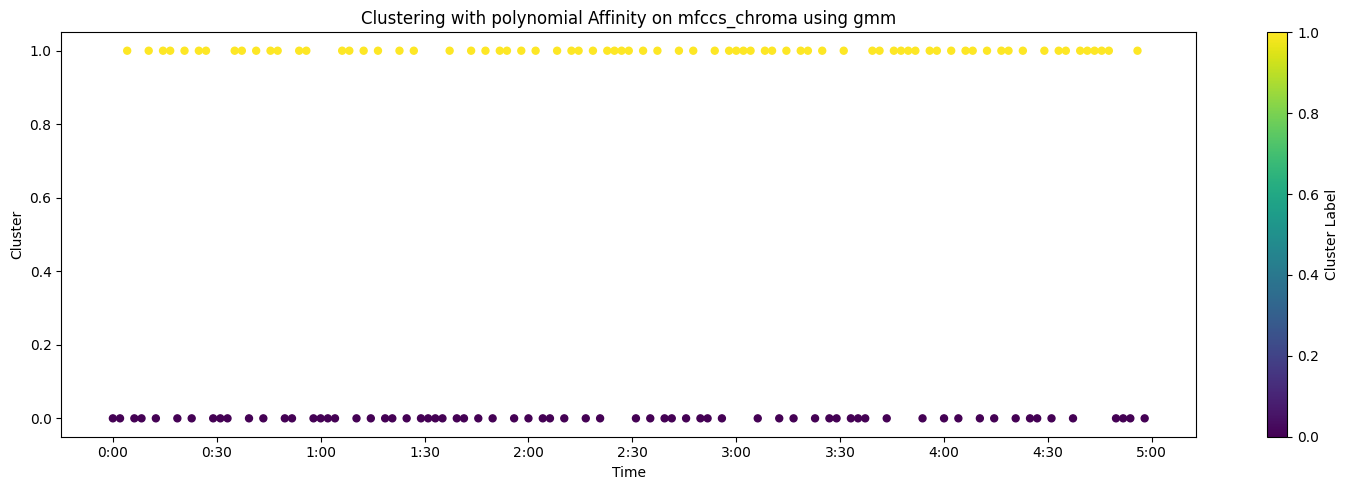

Feature Set: mfccs_chroma, Affinity: linear, Method: kmeans, Silhouette: 0.5097930823816945


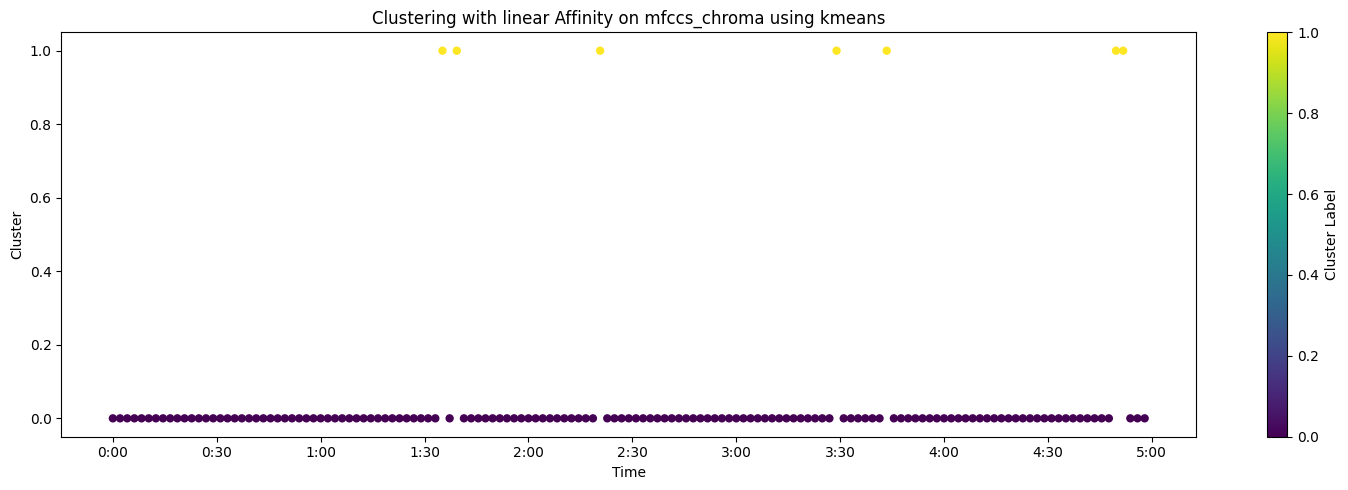

Feature Set: mfccs_chroma, Affinity: linear, Method: dbscan, Silhouette: None


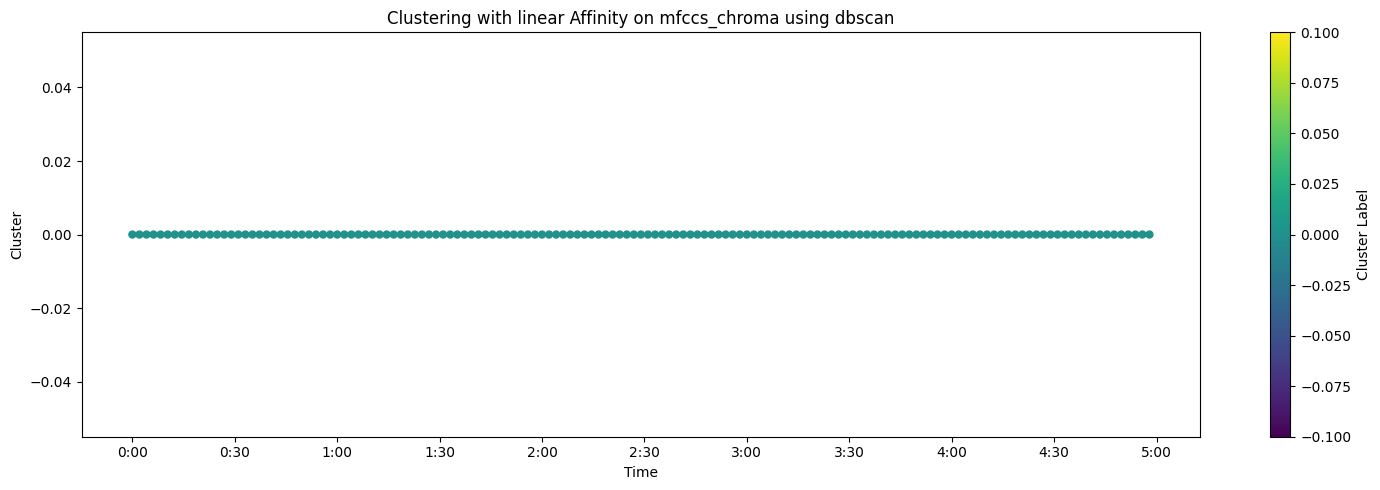

Feature Set: mfccs_chroma, Affinity: linear, Method: gmm, Silhouette: 0.3956079108240425


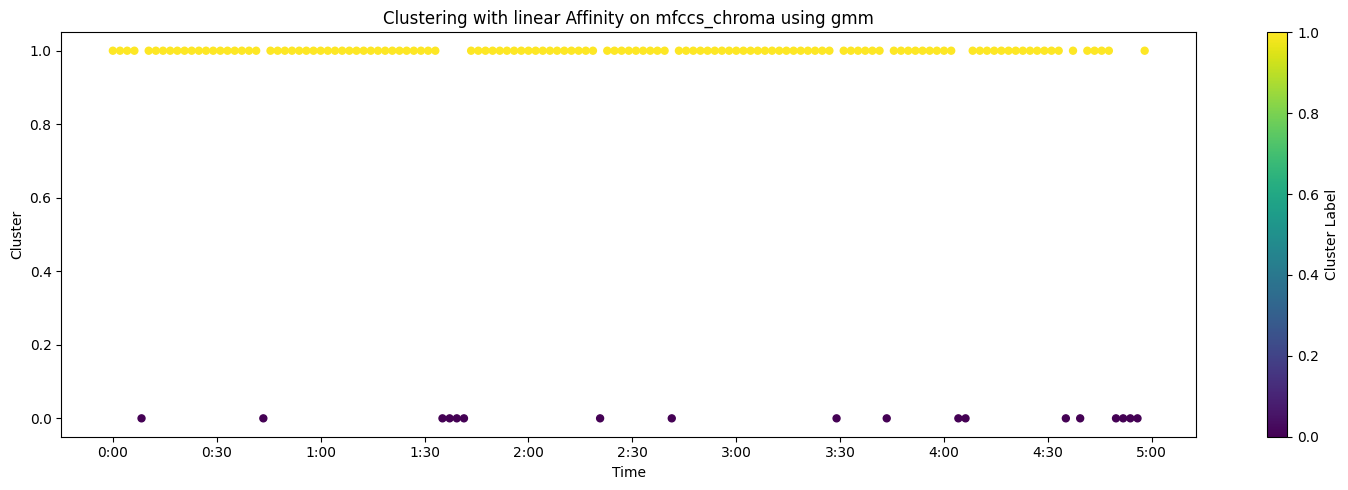

Feature Set: mfccs_chroma, Affinity: dot_product, Method: kmeans, Silhouette: 0.5097930823816945


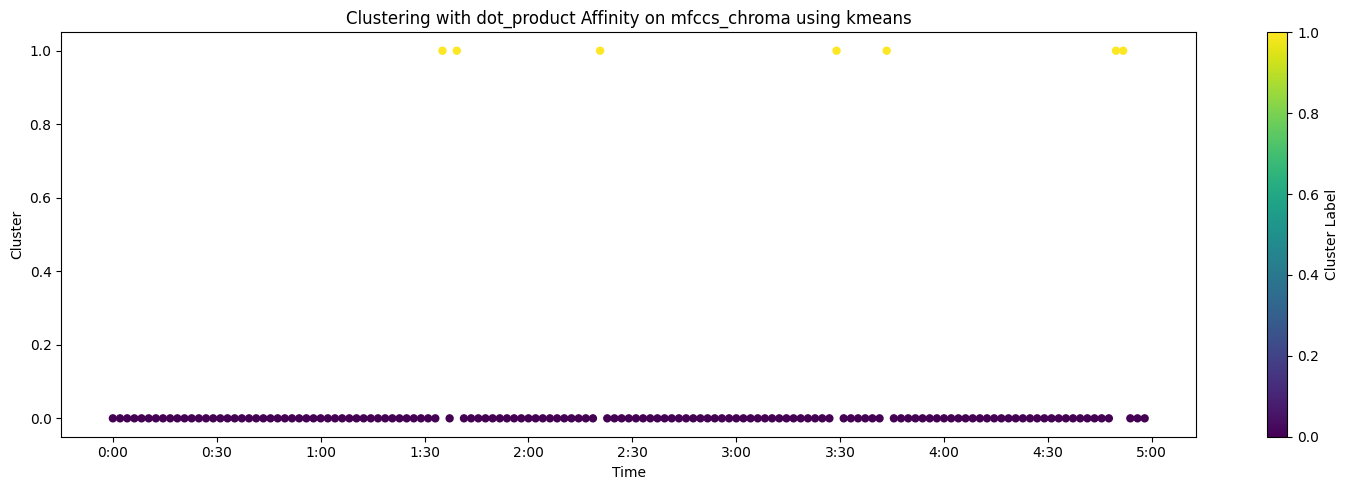

Feature Set: mfccs_chroma, Affinity: dot_product, Method: dbscan, Silhouette: None


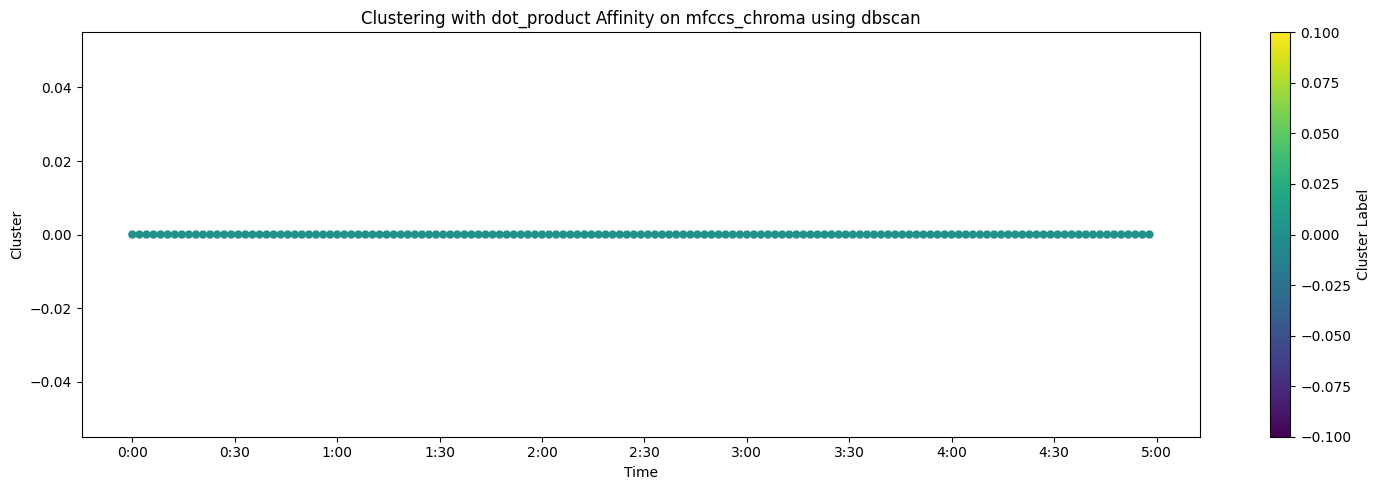

Feature Set: mfccs_chroma, Affinity: dot_product, Method: gmm, Silhouette: 0.3956079108240425


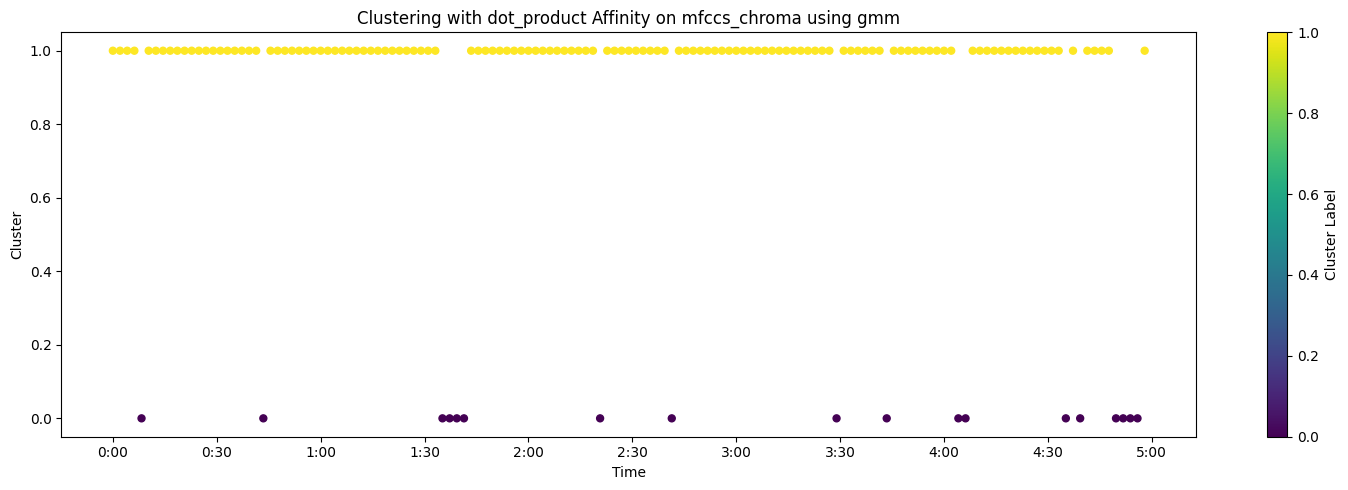

Feature Set: chroma_spectral, Affinity: rbf, Method: kmeans, Silhouette: 0.19733979459809003


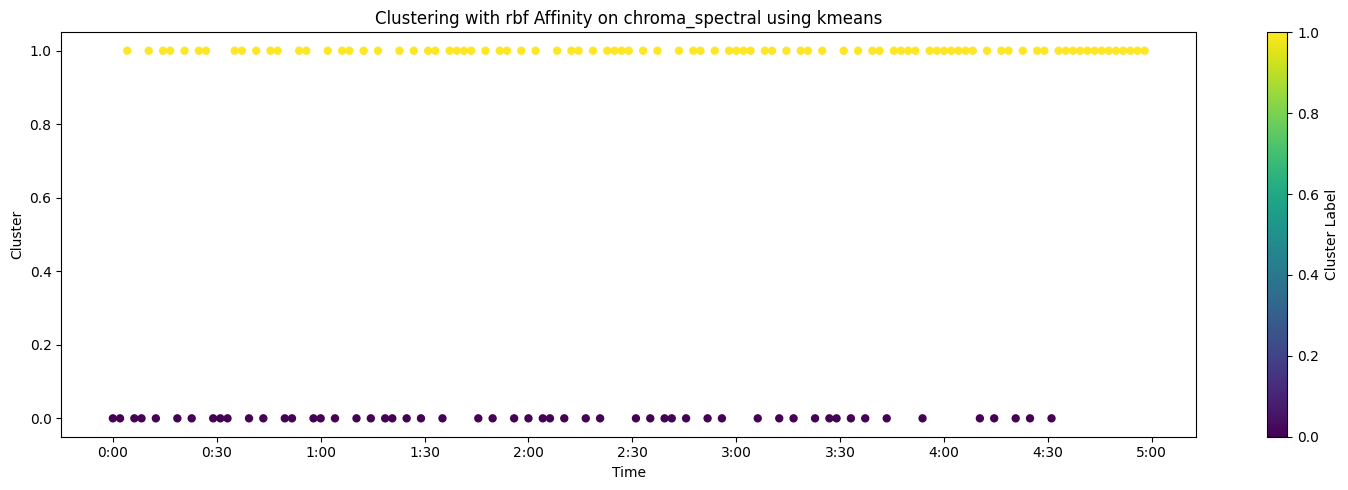

Feature Set: chroma_spectral, Affinity: rbf, Method: dbscan, Silhouette: None


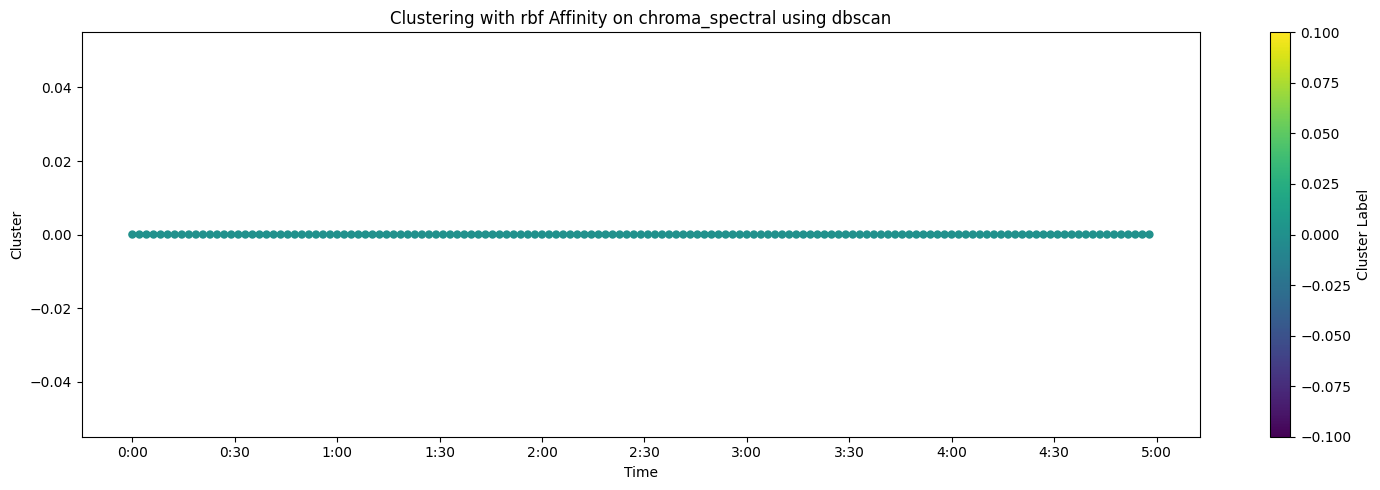

Feature Set: chroma_spectral, Affinity: rbf, Method: gmm, Silhouette: 0.1914504312952045


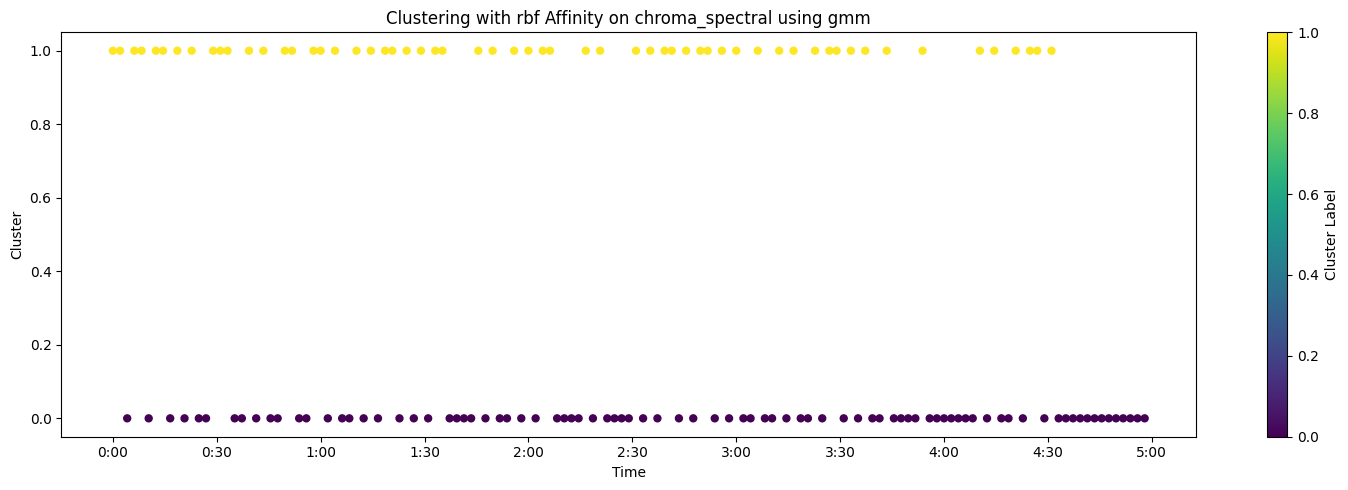

Feature Set: chroma_spectral, Affinity: cosine, Method: kmeans, Silhouette: 0.18839119250562572


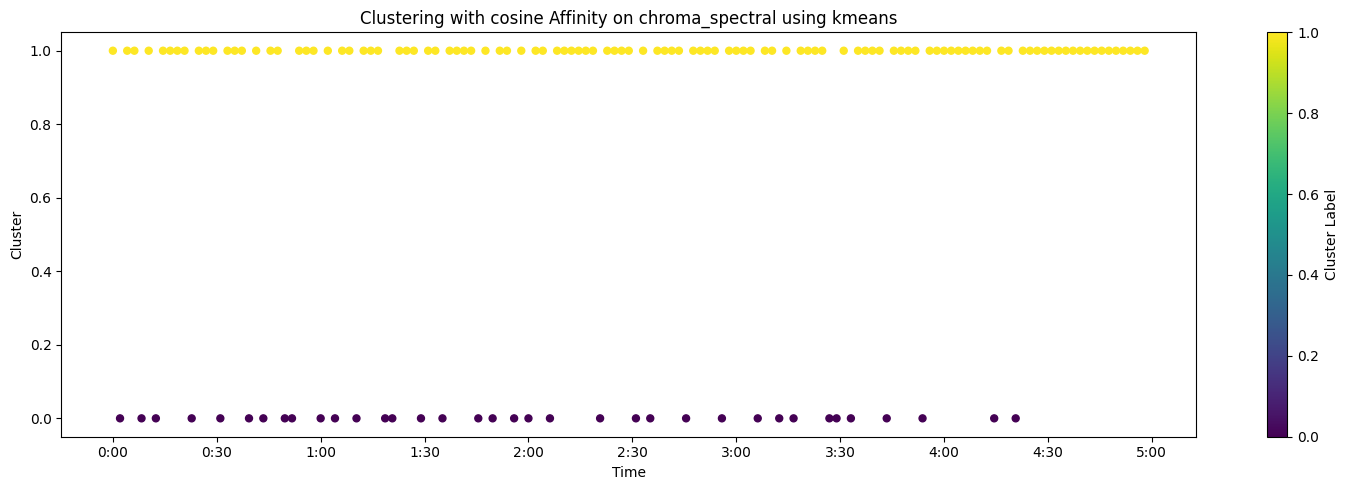

Feature Set: chroma_spectral, Affinity: cosine, Method: dbscan, Silhouette: None


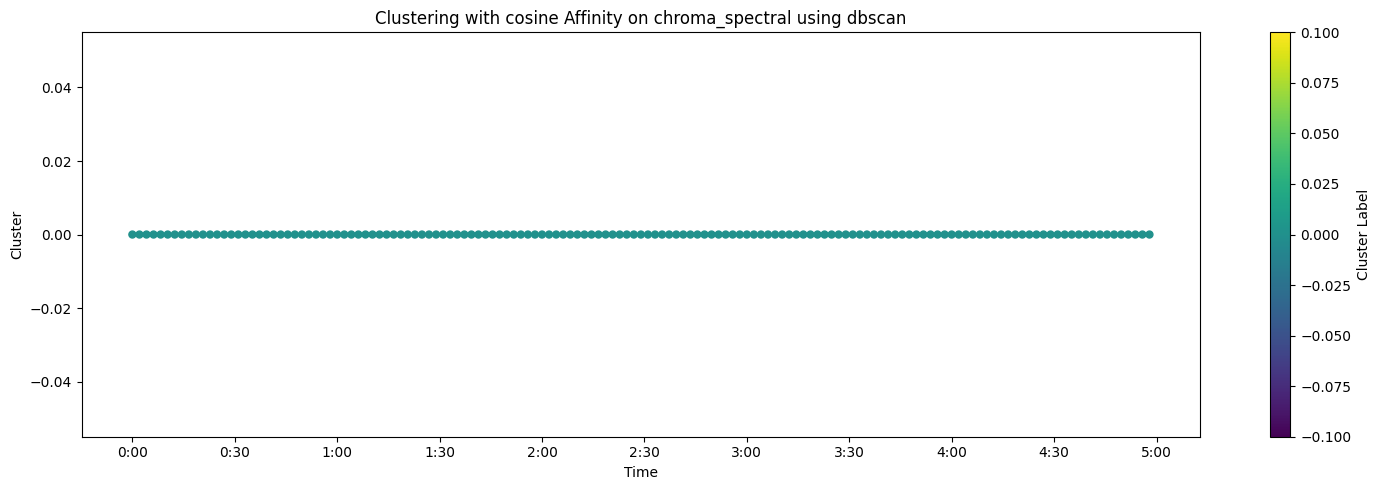

Feature Set: chroma_spectral, Affinity: cosine, Method: gmm, Silhouette: 0.18839119250562572


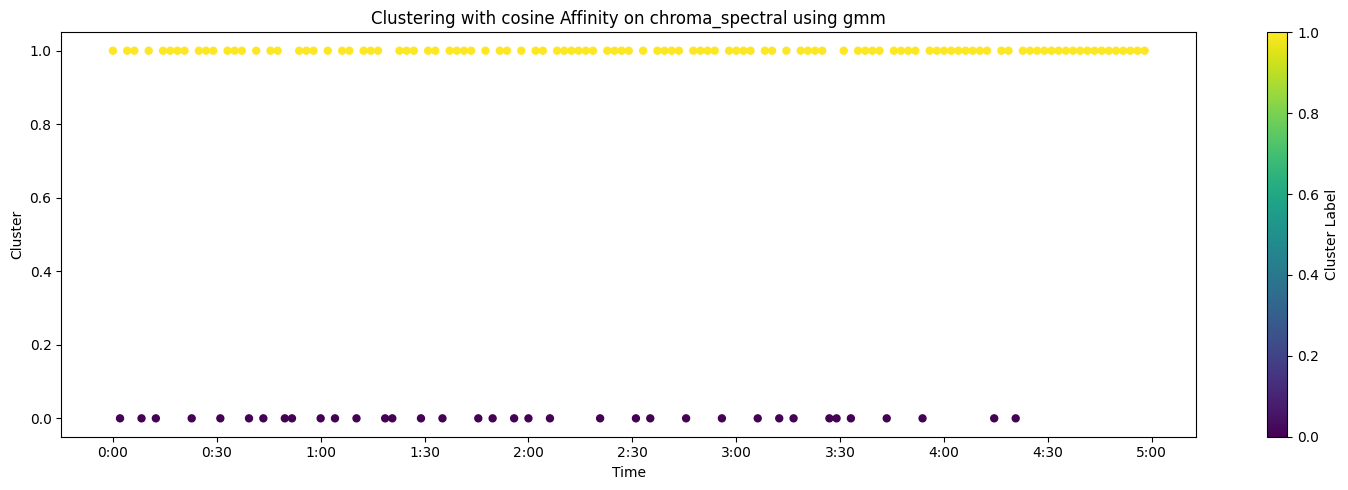

Feature Set: chroma_spectral, Affinity: polynomial, Method: kmeans, Silhouette: 0.20214925592665908


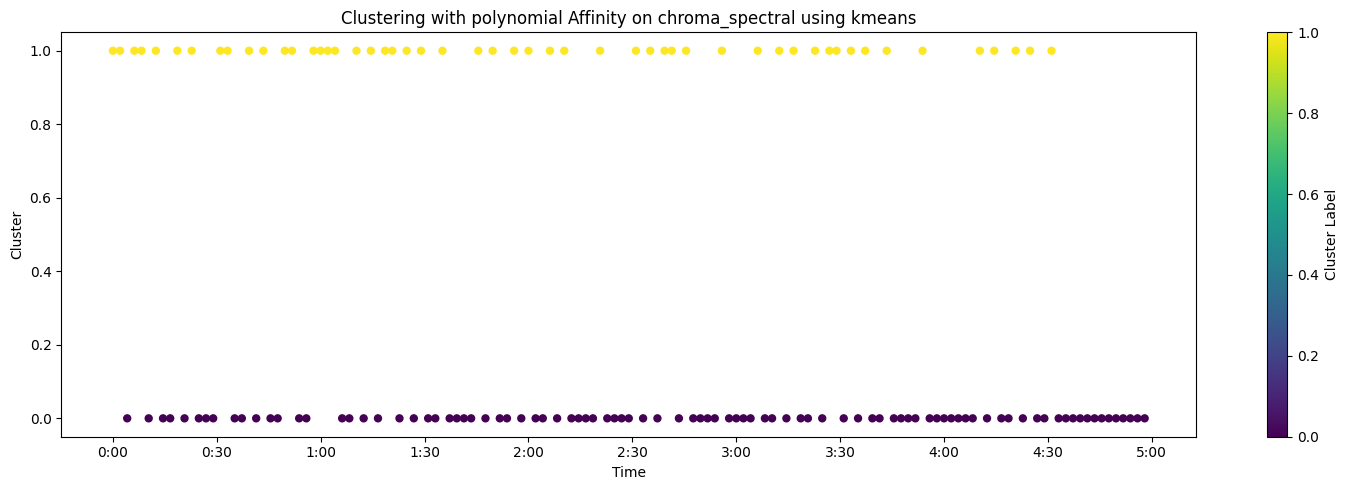

Feature Set: chroma_spectral, Affinity: polynomial, Method: dbscan, Silhouette: None


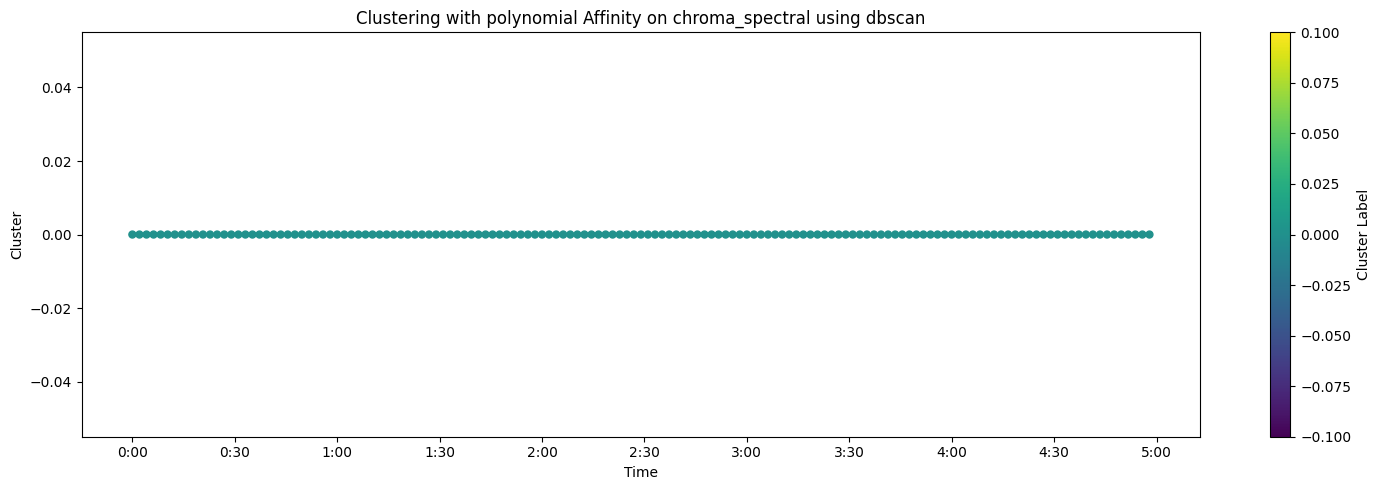

Feature Set: chroma_spectral, Affinity: polynomial, Method: gmm, Silhouette: 0.20049936278737923


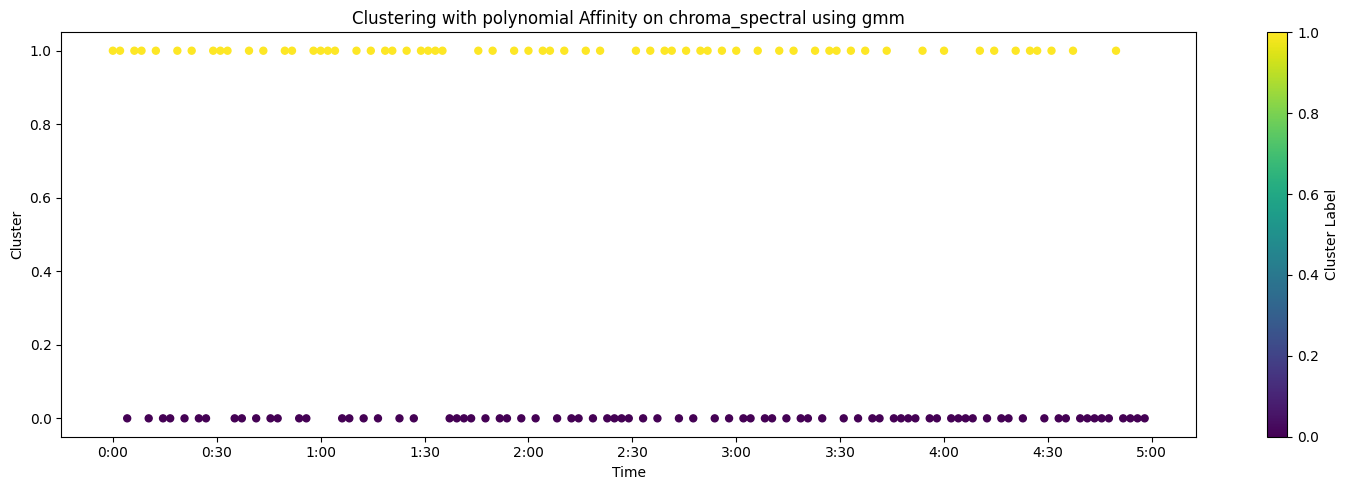

Feature Set: chroma_spectral, Affinity: linear, Method: kmeans, Silhouette: 0.19969292950400228


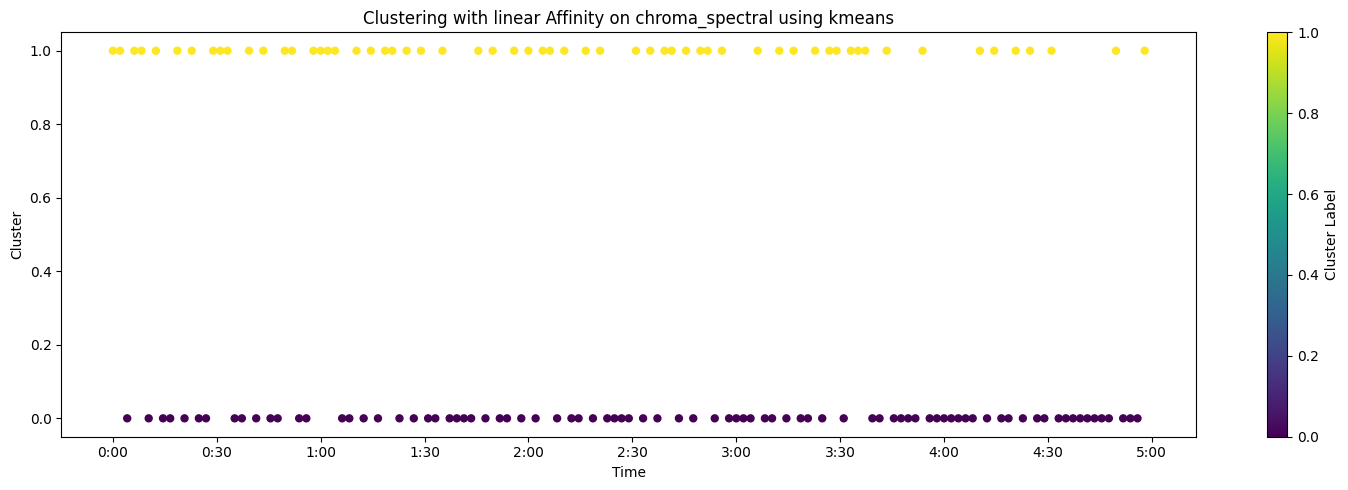

Feature Set: chroma_spectral, Affinity: linear, Method: dbscan, Silhouette: None


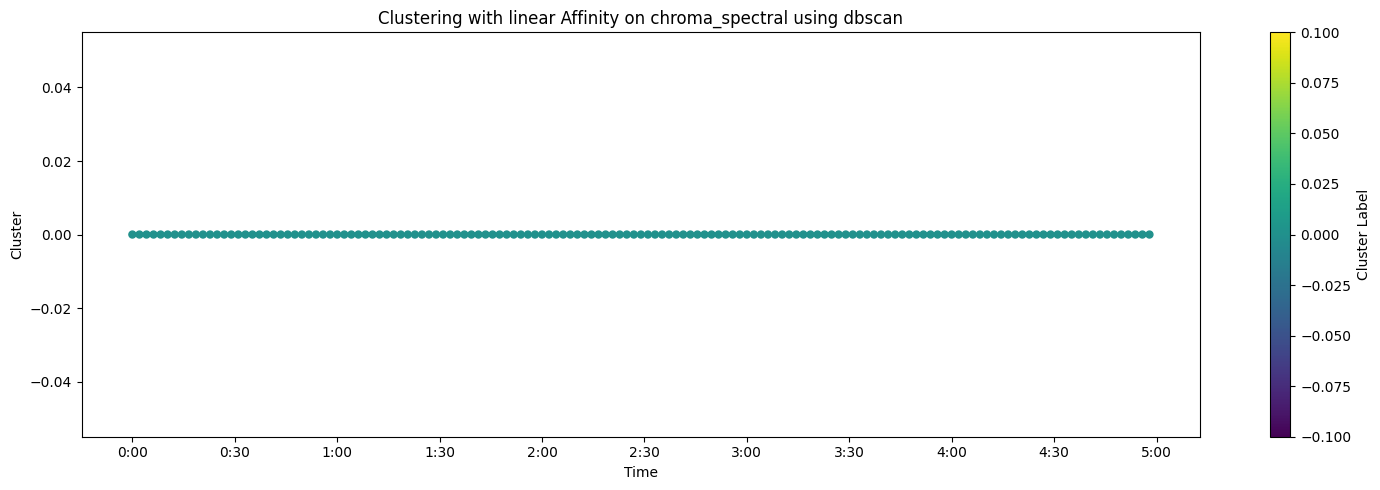

Feature Set: chroma_spectral, Affinity: linear, Method: gmm, Silhouette: 0.17359131827291158


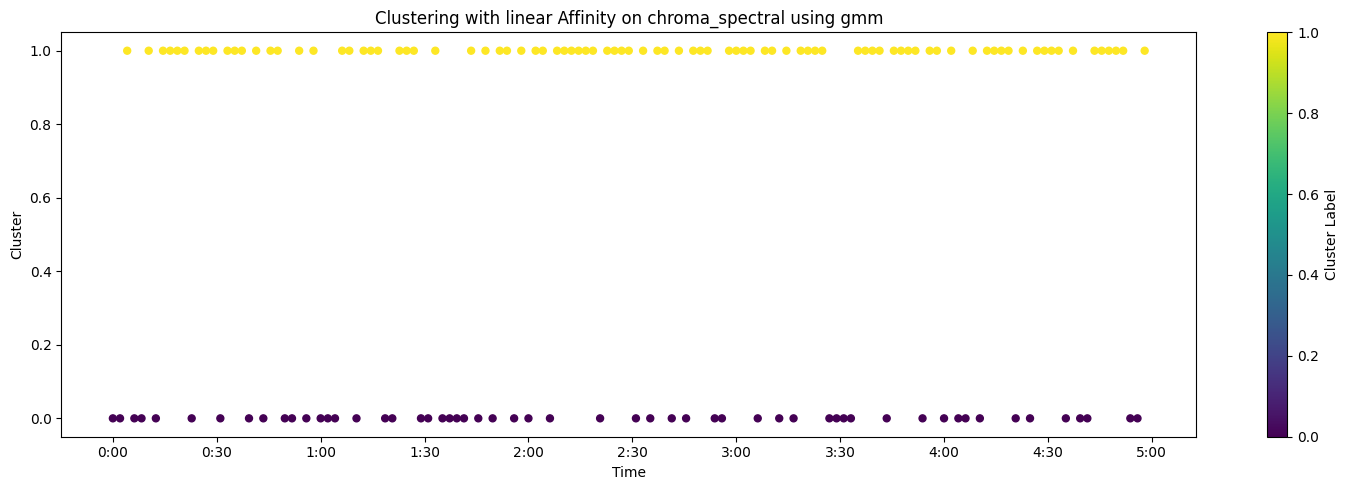

Feature Set: chroma_spectral, Affinity: dot_product, Method: kmeans, Silhouette: 0.19969292950400228


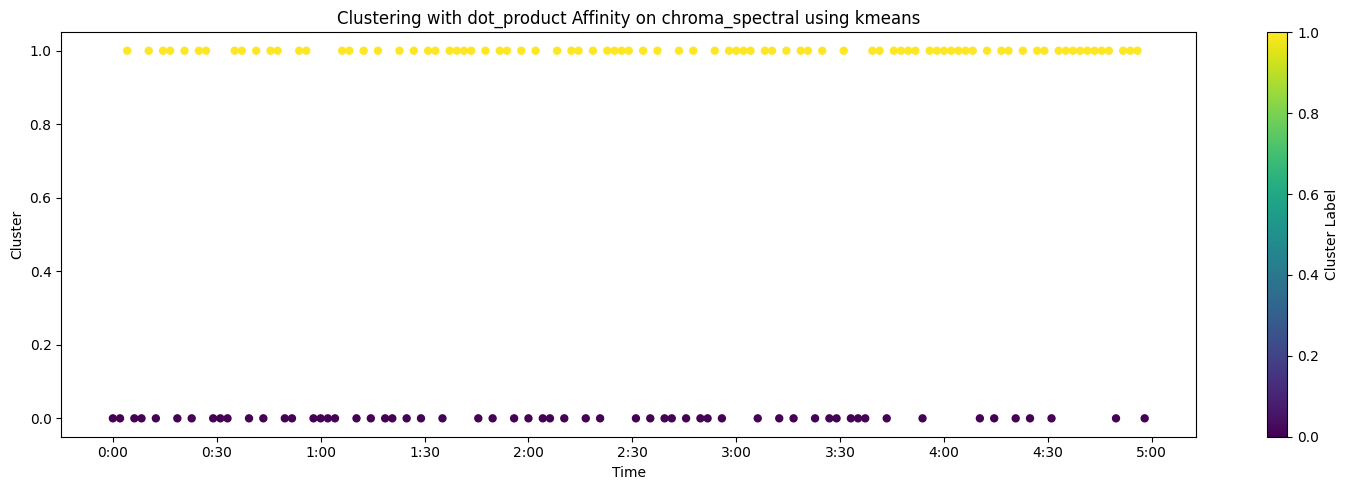

Feature Set: chroma_spectral, Affinity: dot_product, Method: dbscan, Silhouette: None


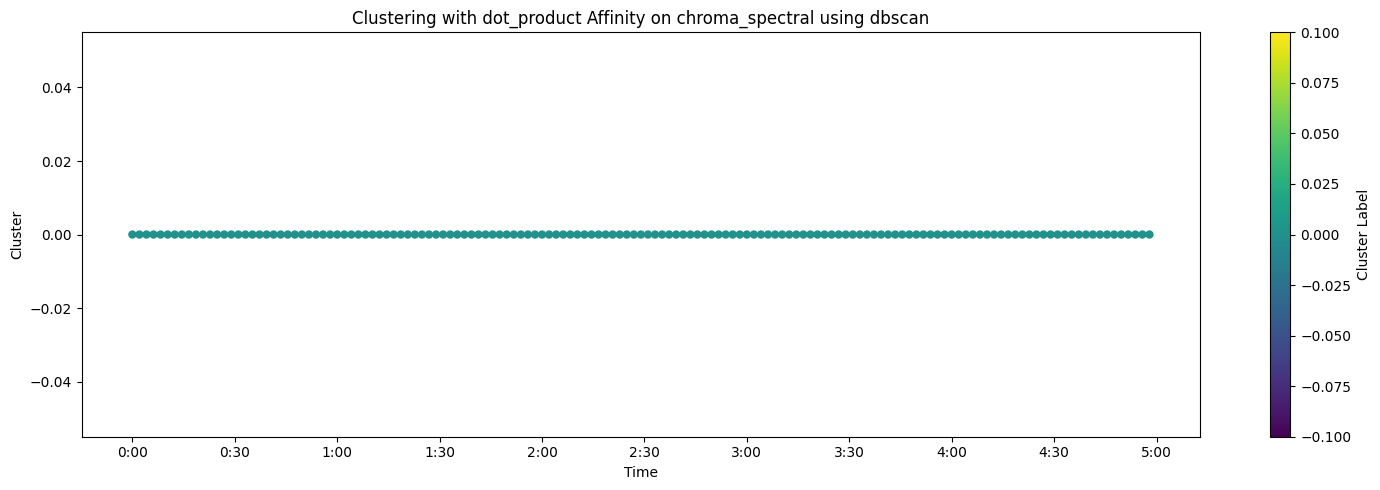

Feature Set: chroma_spectral, Affinity: dot_product, Method: gmm, Silhouette: 0.18867630872345784


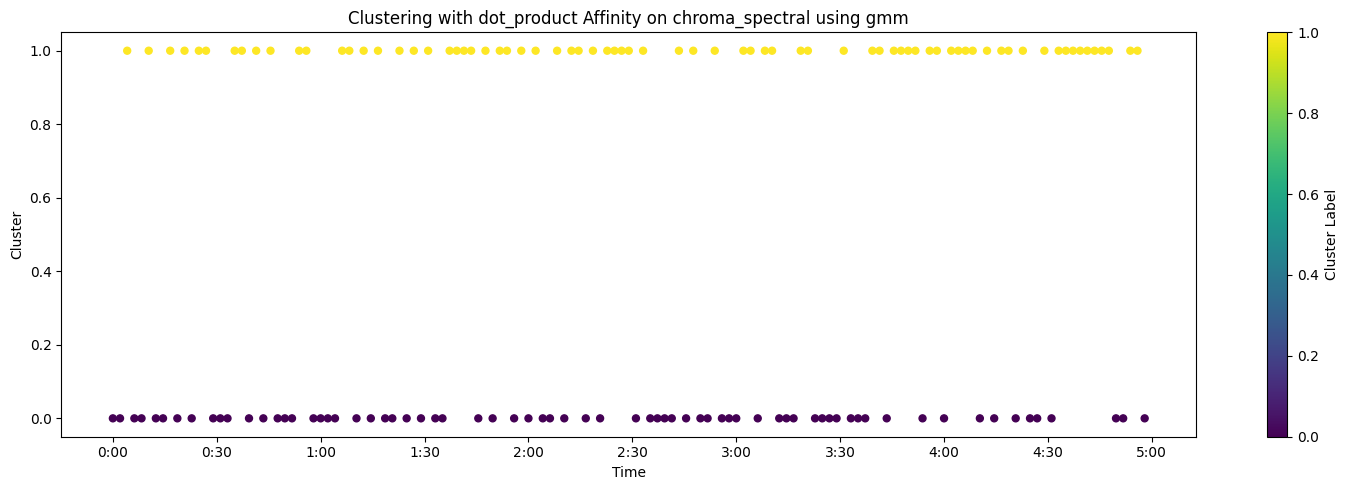

Feature Set: mfccs_chroma_spectral, Affinity: rbf, Method: kmeans, Silhouette: 0.6794361305720952


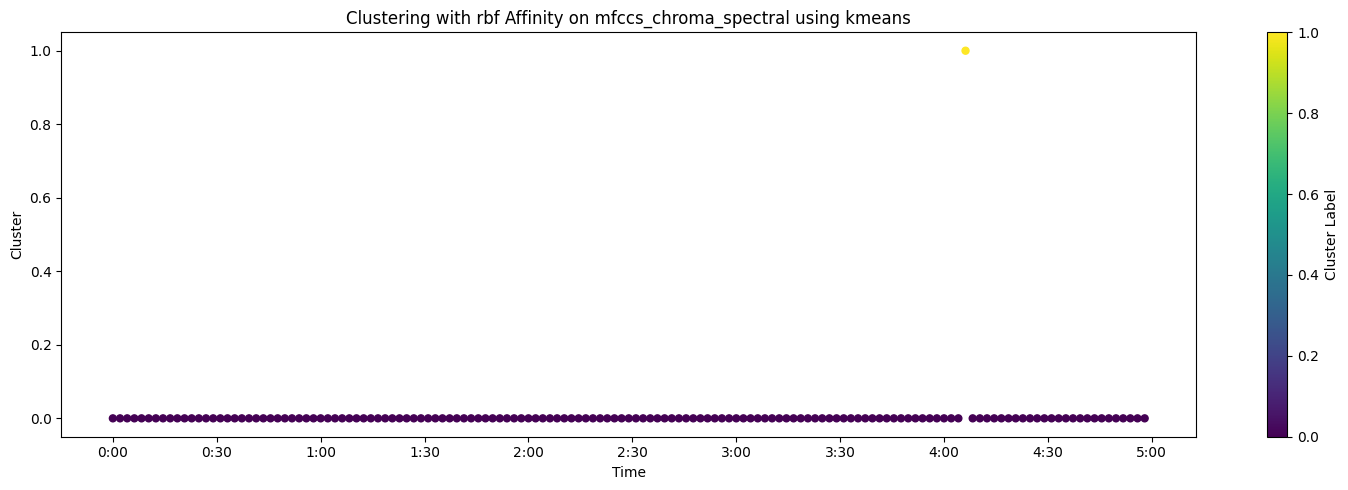

Feature Set: mfccs_chroma_spectral, Affinity: rbf, Method: dbscan, Silhouette: 0.6397364335489413


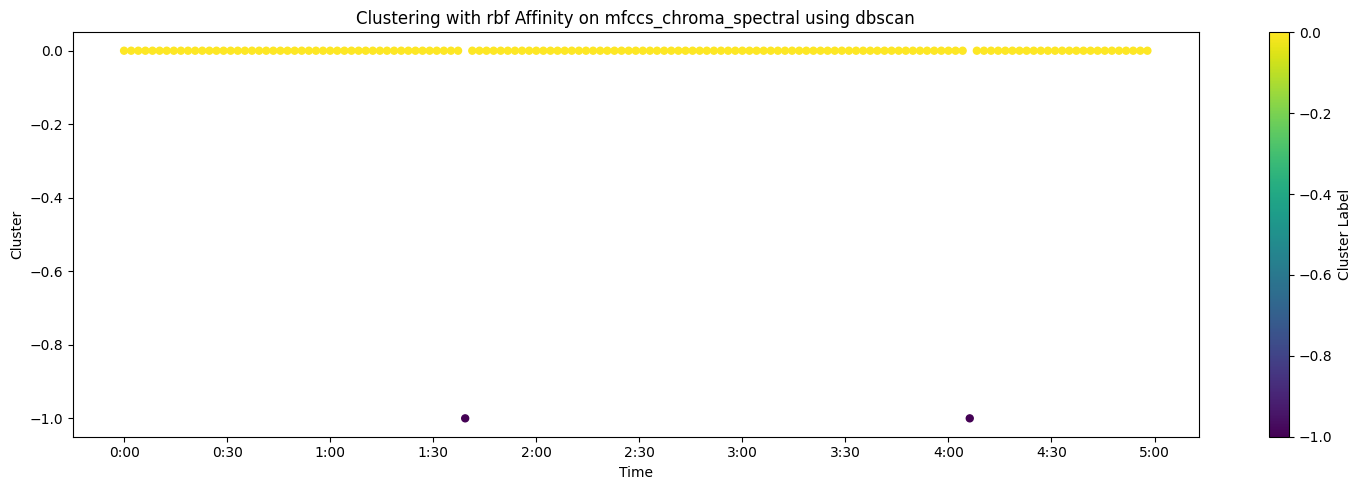

Feature Set: mfccs_chroma_spectral, Affinity: rbf, Method: gmm, Silhouette: 0.5706298160828506


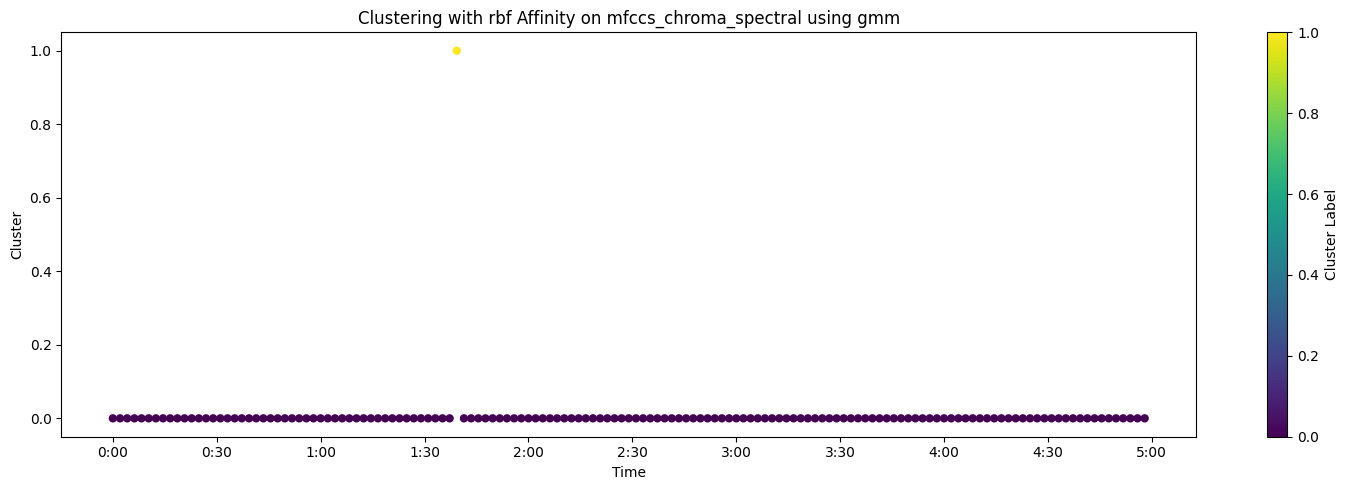

Feature Set: mfccs_chroma_spectral, Affinity: cosine, Method: kmeans, Silhouette: 0.20893206390563016


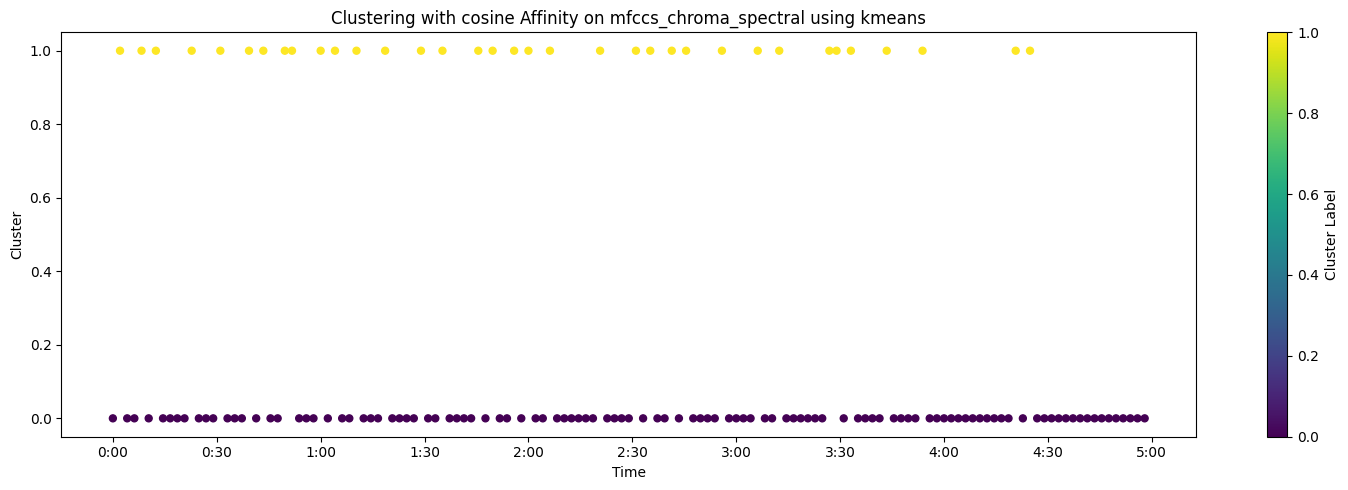

Feature Set: mfccs_chroma_spectral, Affinity: cosine, Method: dbscan, Silhouette: None


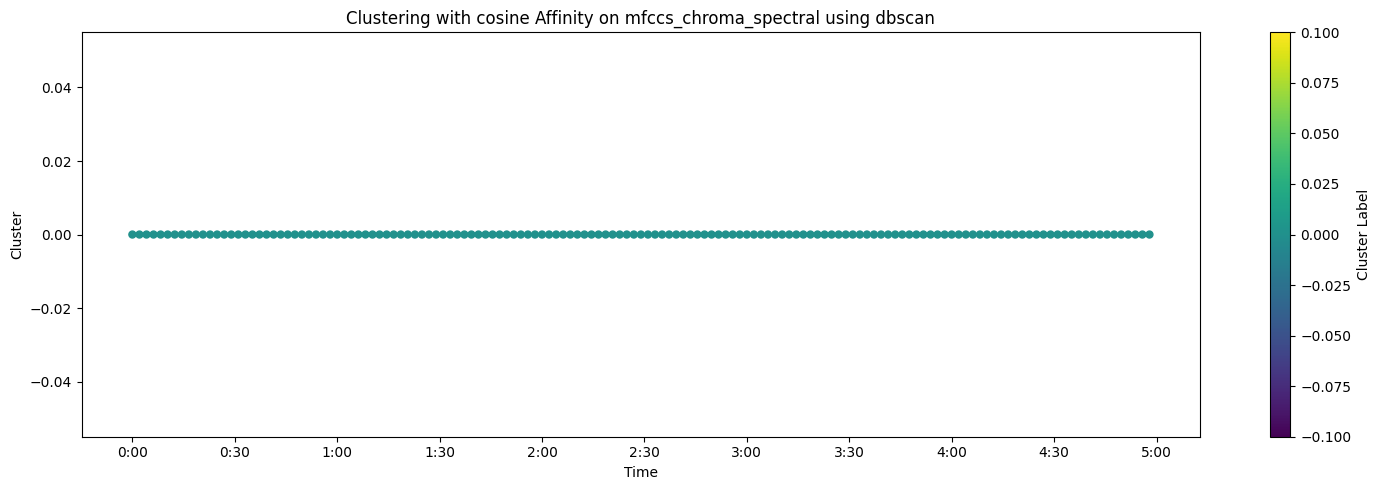

Feature Set: mfccs_chroma_spectral, Affinity: cosine, Method: gmm, Silhouette: 0.3253933190822374


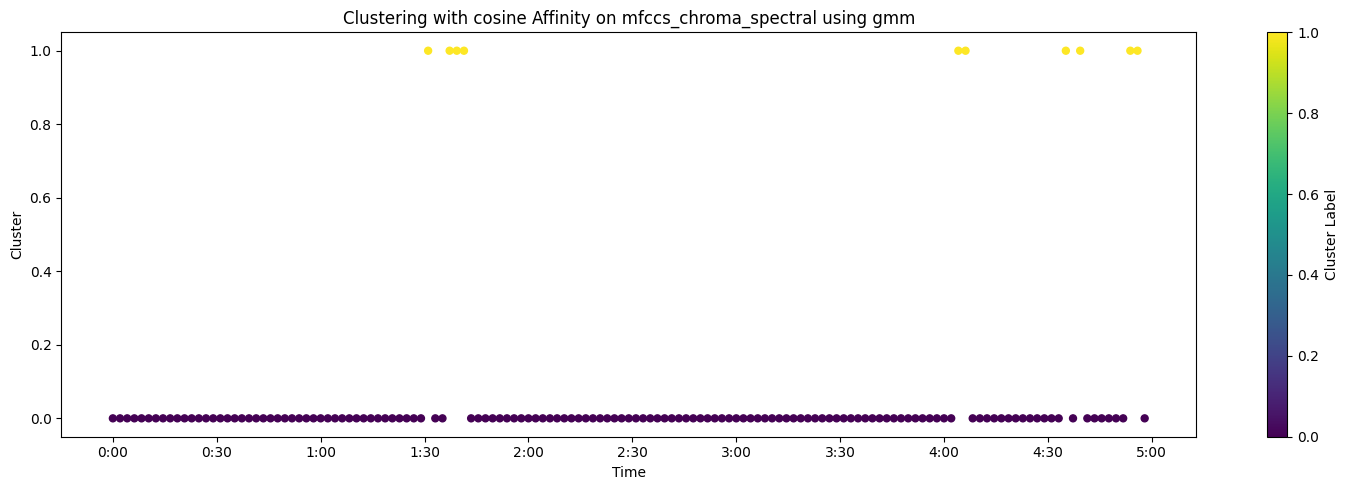

Feature Set: mfccs_chroma_spectral, Affinity: polynomial, Method: kmeans, Silhouette: 0.6794361305720952


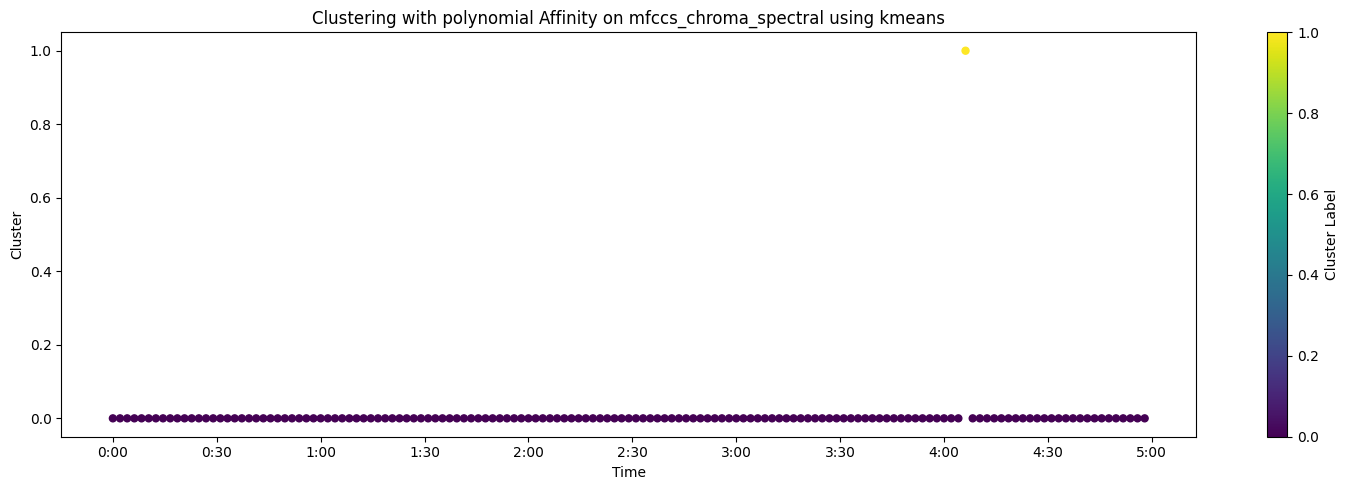

Feature Set: mfccs_chroma_spectral, Affinity: polynomial, Method: dbscan, Silhouette: 0.6794361305720952


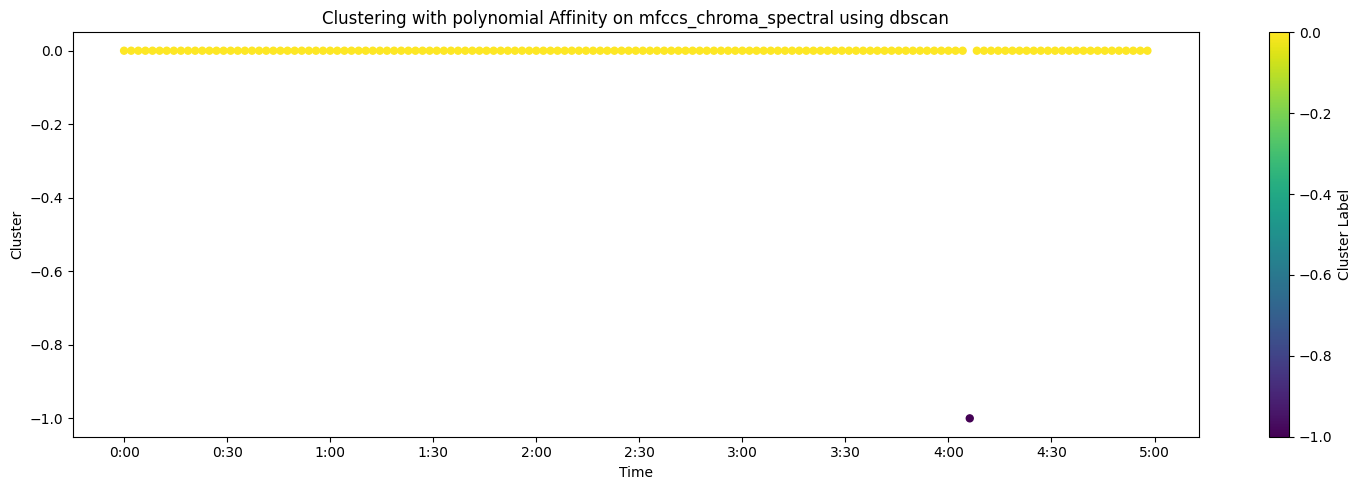

Feature Set: mfccs_chroma_spectral, Affinity: polynomial, Method: gmm, Silhouette: 0.3557170212902104


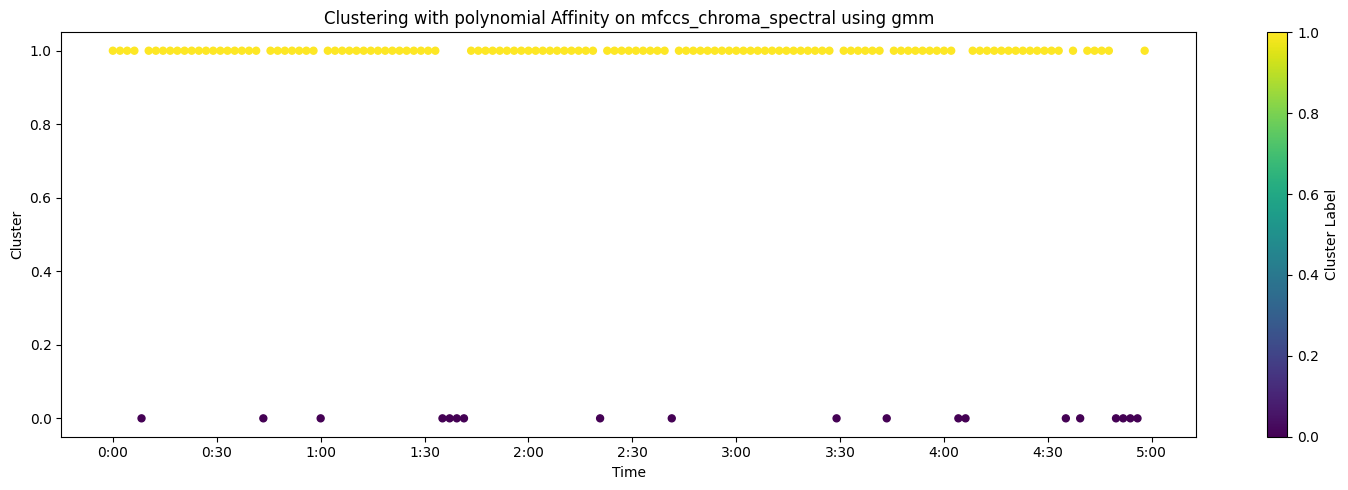

Feature Set: mfccs_chroma_spectral, Affinity: linear, Method: kmeans, Silhouette: 0.1690012681447446


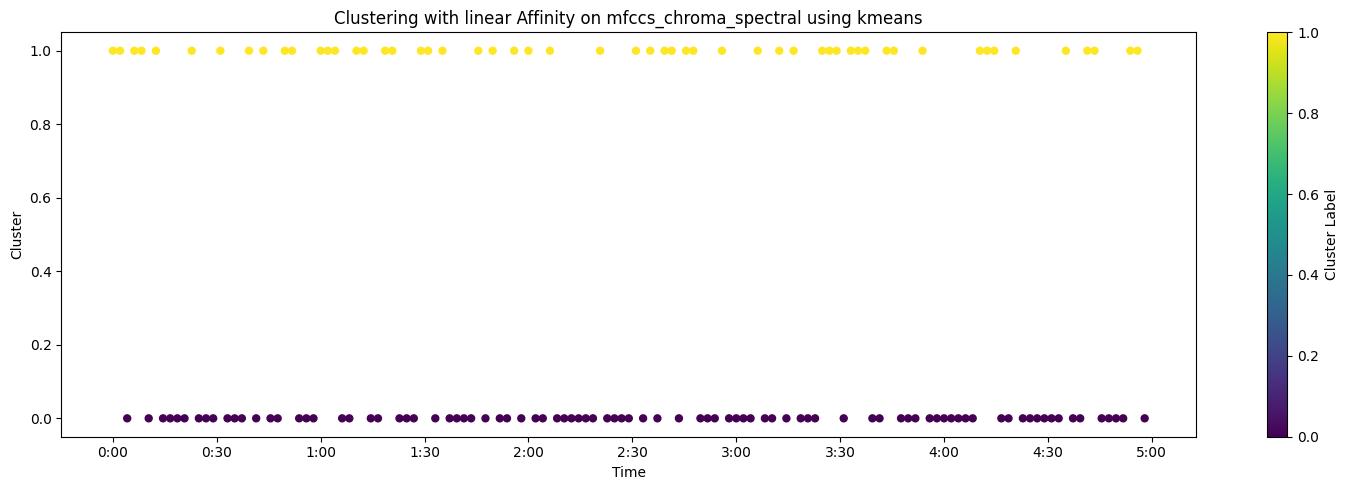

Feature Set: mfccs_chroma_spectral, Affinity: linear, Method: dbscan, Silhouette: None


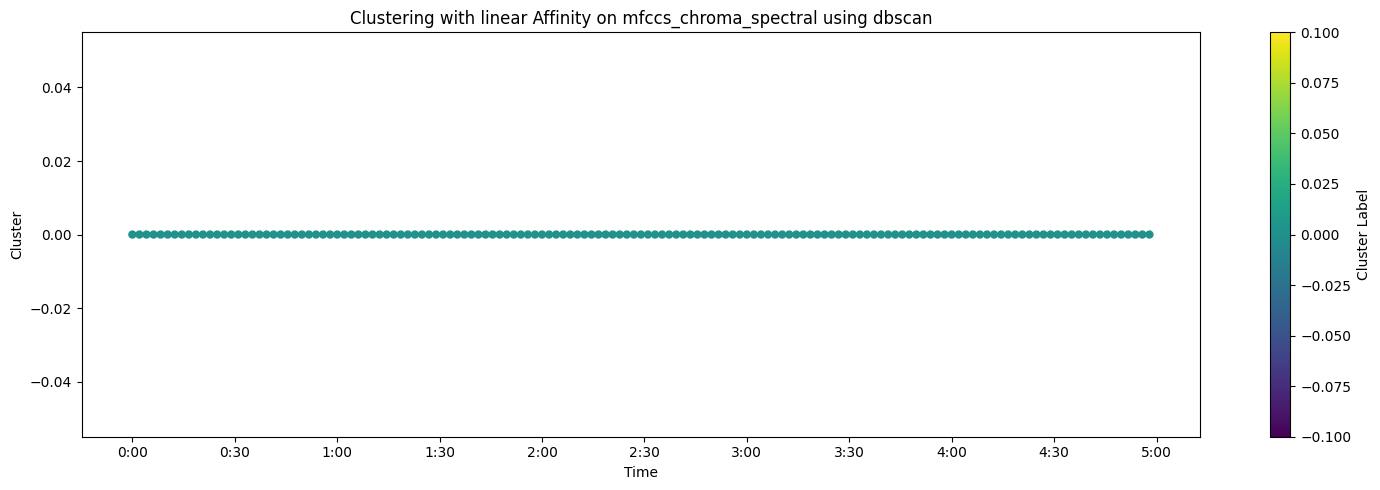

Feature Set: mfccs_chroma_spectral, Affinity: linear, Method: gmm, Silhouette: 0.34674293718204063


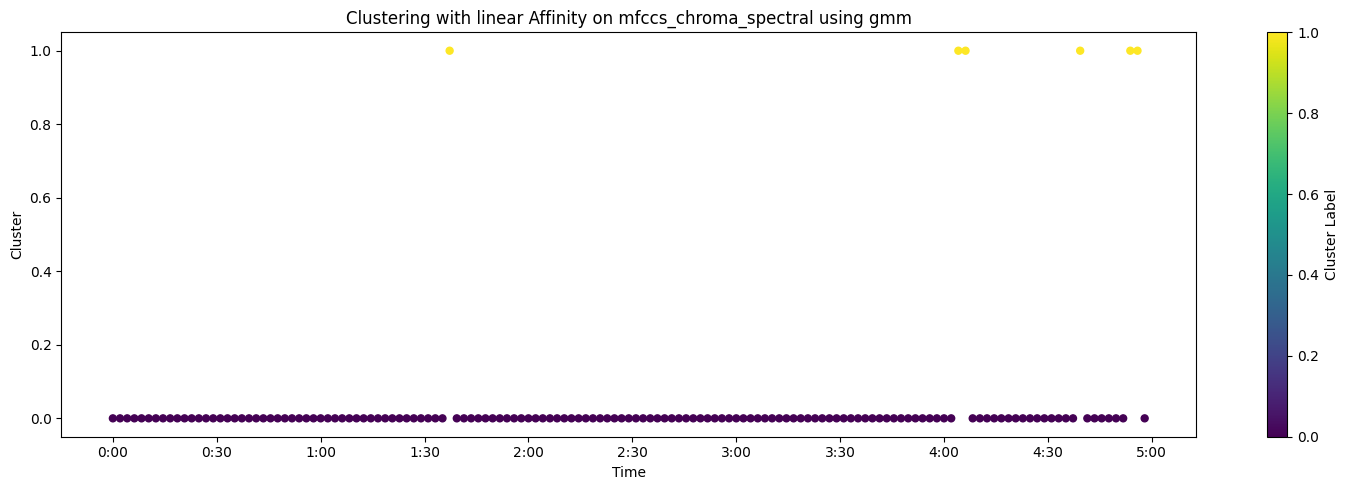

Feature Set: mfccs_chroma_spectral, Affinity: dot_product, Method: kmeans, Silhouette: 0.1690012681447446


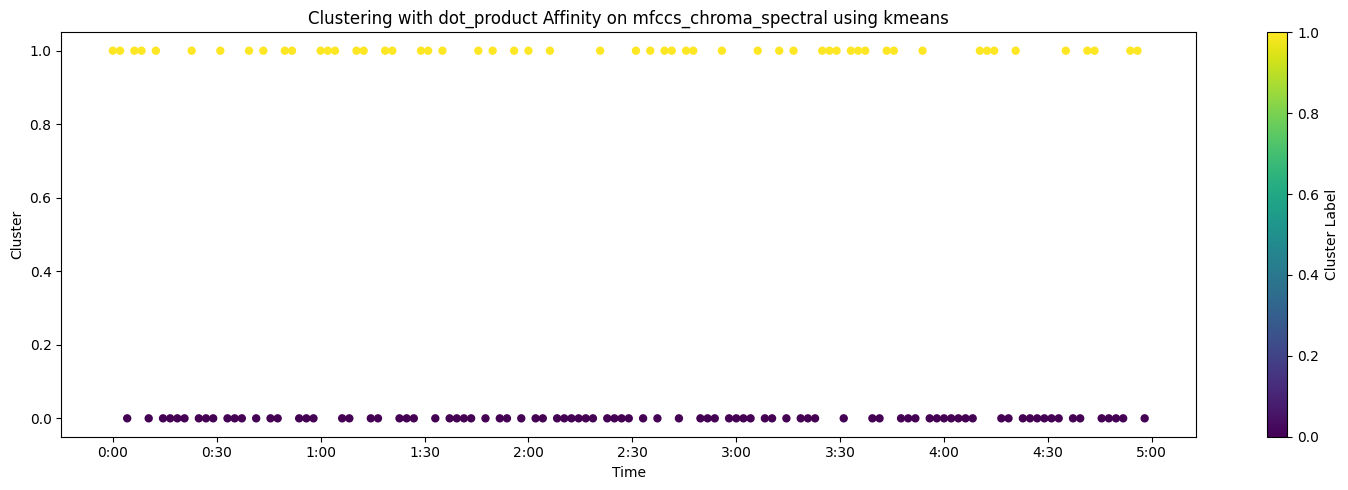

Feature Set: mfccs_chroma_spectral, Affinity: dot_product, Method: dbscan, Silhouette: None


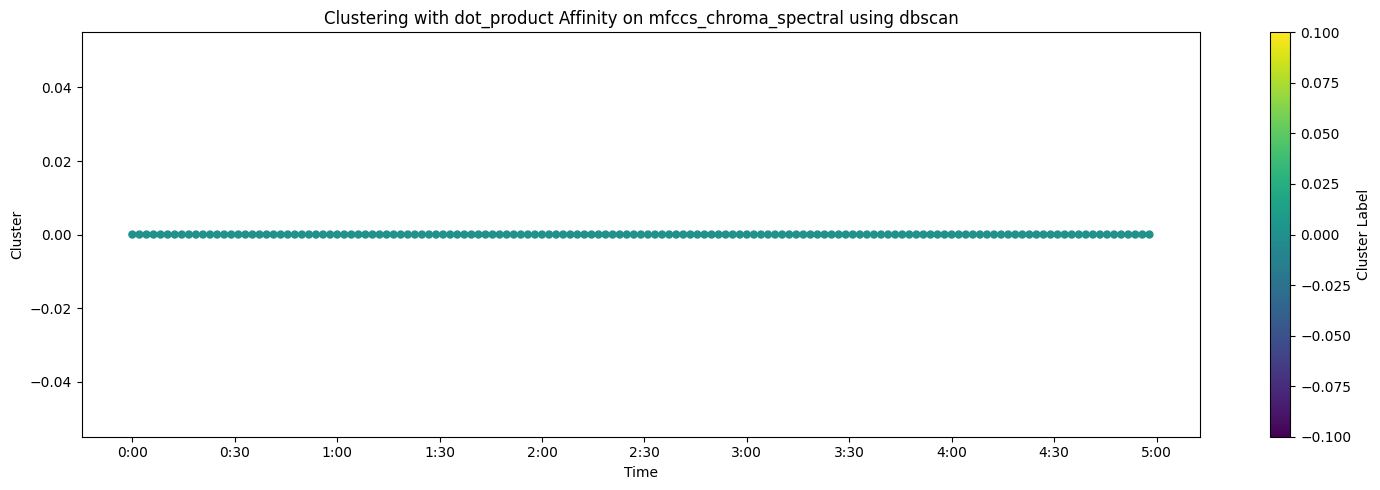

Feature Set: mfccs_chroma_spectral, Affinity: dot_product, Method: gmm, Silhouette: 0.37359080843798226


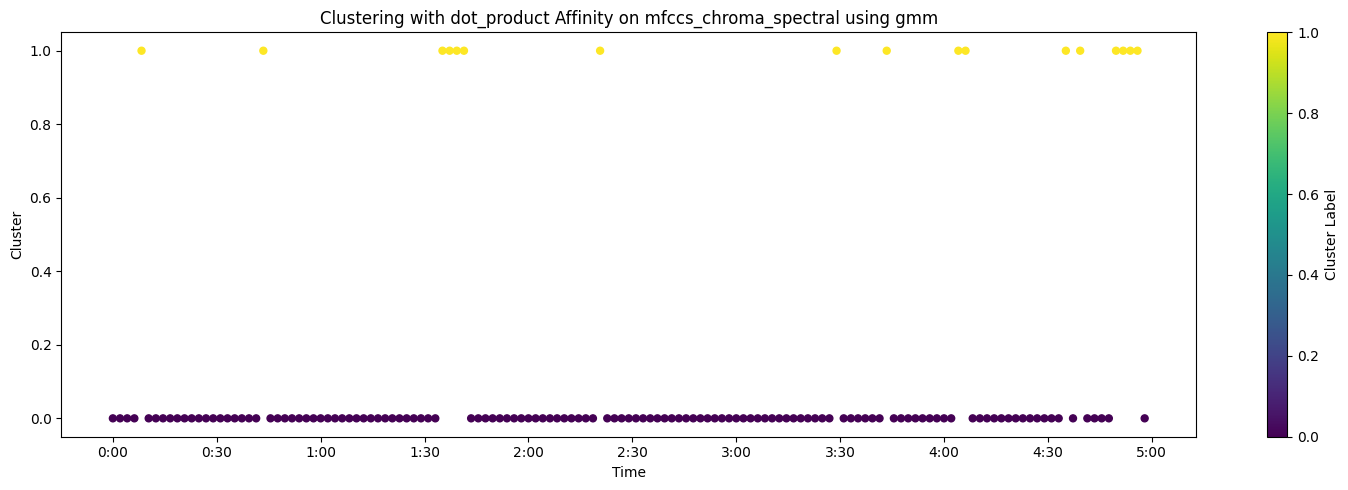

In [18]:
affinity_matrices = {
    'rbf': rbf_kernel,
    'cosine':cosine_similarity,
    'polynomial': polynomial_kernel,
    'linear': linear_kernel,
    'dot_product': lambda X: np.dot(X,X.T)
    }

clustering_methods = ['kmeans', 'dbscan', 'gmm']

mfccs_scaled, delta_scaled, chroma_scaled, spectral_scaled = extract_features(audio_data, sampling_rate)

feature_sets = {
    'mfccs': mfccs_scaled,
    'delta': delta_scaled,
    'chroma': chroma_scaled,
    'spectral': spectral_scaled,
    'mfccs_delta': np.vstack([mfccs_scaled, delta_scaled]),
    'mfccs_chroma': np.vstack([mfccs_scaled, chroma_scaled]),
    'chroma_spectral': np.vstack([chroma_scaled, spectral_scaled]),
    'mfccs_chroma_spectral': np.vstack([mfccs_scaled, chroma_scaled, spectral_scaled])
}

for feature_name, features in feature_sets.items():
    for affinity_name, affinity_func in affinity_matrices.items():
        affinity_matrix = affinity_func(features.T)
        
        for method in clustering_methods:
            labels, silhouette = clustering(features.T, affinity_matrix, n_clusters=2, clustering_method=method)
            print(f'Feature Set: {feature_name}, Affinity: {affinity_name}, Method: {method}, Silhouette: {silhouette}')
            time_axis = np.arange(len(labels)) * (duration / len(labels))  # Adjust time axis
            plt.figure(figsize=(15, 5))
            plt.scatter(time_axis, labels, c=labels, cmap='viridis', s=25)
            plt.colorbar(label='Cluster Label')
            plt.title(f'Clustering with {affinity_name} Affinity on {feature_name} using {method}')
            plt.xlabel('Time')
            plt.ylabel('Cluster')
            ax = plt.gca()
            ax.xaxis.set_major_formatter(FuncFormatter(time_ticks))
            plt.xticks(np.arange(0, duration + 30, 30))
            plt.tight_layout()
            plt.show()
            

In [10]:
def plot_clusters(time_axis, labels, feature_name, method):
    plt.figure(figsize=(15, 5))
    plt.scatter(time_axis, labels, c=labels, cmap='viridis', s=25)
    plt.colorbar(label='Cluster Label')
    plt.title(f'{feature_name} - {method}')
    plt.xlabel('Time (s)')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()
